<a href="https://colab.research.google.com/github/johnryantaylor/QCES/blob/main/Project3_tsunami.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 3: Tsunami
In this project, we will use Dedalus to model the propagation of Tsunami waves. Tsunami typically have wavelengths larger than 100km and periods of about 1 hour. Since their wavelength is much larger than the depth of the ocean, Tsunami can be modelled using the shallow water equations.

Here, we will use Dedalus to solve an initial value problem for the shallow water equations. We will generate a Tsunami using a localized disturbance to the water height.

Student tasks are in [Section 1.3]( #section1pt3 ), [Section 2.3]( #section2pt3 ), and [Section 3.3]( #section3pt3 ).

## Setup
If you are using Google colab, run the script below to install Dedalus

In [3]:
# Set environment variables for best performance
%env OMP_NUM_THREADS=1
%env NUMEXPR_MAX_THREADS=1

# Minimize logging output
import logging
logging.disable(logging.DEBUG)

# Check if running on google colab
import os
using_google_colab = bool(os.getenv("COLAB_RELEASE_TAG"))

# Check for Dedalus
try:
    import dedalus.public as de
    print("Dedalus already installed :)")
except:
    print("Dedalus not installed yet.")
    if using_google_colab:
        print("Installing for Google Colab.")
        print()
        # Step 1: Install FFTW
        !apt-get install libfftw3-dev
        !apt-get install libfftw3-mpi-dev
        # Step 2: Set paths for Dedalus installation
        import os
        os.environ['MPI_INCLUDE_PATH'] = "/usr/lib/x86_64-linux-gnu/openmpi/include"
        os.environ['MPI_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        os.environ['FFTW_INCLUDE_PATH'] = "/usr/include"
        os.environ['FFTW_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        # Step 3: Install Dedalus using pip
        !pip3 install cython "mpi4py<4.0" numpy setuptools wheel
        !CC=mpicc pip3 install --no-cache --no-build-isolation http://github.com/dedalusproject/dedalus/zipball/master/
        !pip3 install -q ipympl
        # Step 4: Check installation
        print()
        try:
            import dedalus.public as de
            print("Dedalus successfully installed :)")
        except:
            print("Error installing Dedalus :(")
            raise
    else:
        print("See website for installation instructions:")
        print("https://dedalus-project.readthedocs.io/en/latest/pages/installation.html")

# Setup interactive matplotlib
if using_google_colab:
    from google.colab import output
    output.enable_custom_widget_manager()

env: OMP_NUM_THREADS=1
env: NUMEXPR_MAX_THREADS=1
Dedalus not installed yet.
Installing for Google Colab.

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfftw3-bin libfftw3-double3 libfftw3-long3 libfftw3-quad3 libfftw3-single3
Suggested packages:
  libfftw3-doc
The following NEW packages will be installed:
  libfftw3-bin libfftw3-dev libfftw3-double3 libfftw3-long3 libfftw3-quad3
  libfftw3-single3
0 upgraded, 6 newly installed, 0 to remove and 41 not upgraded.
Need to get 4,654 kB of archives.
After this operation, 24.7 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-double3 amd64 3.3.8-2ubuntu8 [770 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-long3 amd64 3.3.8-2ubuntu8 [335 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-quad3 amd64 3.3.8-2ubuntu8 [614 kB]
Get:4 http://arch

## 1.  1D shallow water equations
Let's start by solving the shallow water equations in 1D with periodic boundary conditions in our spatial variable, $x$. The script below solves the following equations:

$$ \partial_t u + g \partial_x(h) = - u\partial_x u$$
$$ \partial_t h + \partial_x(Hu) = -\partial_x(hu)$$

In these equations, $g$ is the constant gravitational acceleration, $u$ is the velocity in the $x$ direction, $H$ is the resting height, and $h$ is the height of the free surface relative to $H$. Note that the terms on the right hand side are nonlinear in our dependent variables, and we will use an explicit timestepping method for these terms. Recall that Dedalus uses explicit timestepping for terms on the right hand side of the inputted equation.

Because we are interested in an application to Tsunami, we will solve the equations using dimensional variables. It is convenient to define simulation units at the start of the script so that we can be explicit about the units.

We will start with the following initial conditions:
$$ h=e^{-(x-x_1)^2/w_1^2} $$
$$ u=(c/g)h $$
where $x_1$ is the center and $w_1=100$ km is the width of the Gaussian perturbation. This generates a wave that will propagate to the right with speed $c$ before it encounters the seamount.

To see how the waves change as they approach shallow water, we will set the resting water depth to include a localized seamount using the form:
$$ H=H_0-(H_0-H_{min})e^{(-(x-x_2)^2/w_2^2)} $$
where $x_2$ is the location of the seamount, $H_0=4$ km is the depth of the ocean away from the seamount, and $H_{min}$ is the minimum water depth above the seamount. Note that since $H\ll w$, the shallow water approximation is appropriate here.

### 1.1  Dedalus script to solve the 1D shallow water equations

The script below solves the 1D shallow water equations with the initial conditions given above.

In [32]:
# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Define the simulation units. This is optional, but will help us keep track of units
meter = 1
kilometer = meter * 1e3
second = 1
minute = 60
hour = 3600
day = hour * 24

# Specify the simulation parameters
Lx = 1000 * kilometer # The domain size
Nx = 512 # The number of gridpoints in x
g = 9.81 * meter / second**2 # Gravitational acceleration
H0 = 4 * kilometer # Reference ocean depth
w1 = 20 * kilometer # Width of the initial perturbation
x1 = 200 * kilometer # Center of the initial perturbation
x2 = 500 * kilometer # Center of the seamount
w2 = 100 * kilometer # Width of the seamount
H_min = 100 * meter # minimum depth above the seamount
c = np.sqrt(g*H0) # Wave speed

timestep = 60 * second # Specify the timestep
stop_sim_time = 100 * minute # Specify the stopping time

timestepper = dedalus.RK222
max_timestep = 0.125

# Create an x-coordinate, a corresponding basis, and a distributor
xcoord = dedalus.Coordinate('x')
dist = dedalus.Distributor(xcoord, dtype=np.float64) # No mesh for serial / automatic parallelization
x_basis = dedalus.RealFourier(xcoord, size=Nx, bounds=(0, Lx))
x = dist.local_grid(x_basis)

# Specify the Fields and set the initial conditions
u = dist.Field(name='u', bases=x_basis)
h = dist.Field(name='h', bases=x_basis)
H = dist.Field(name='H', bases=x_basis)
h.change_scales(1)
H.change_scales(1)
u.change_scales(1)
H['g'] = H0-(H0-H_min)*np.exp(-(x-x2)**2.0/w2**2.0)
h['g'] = np.exp(-(x-x1)**2.0/w1**2.0)  # Initialize the height with a Gaussian function with width set above
u['g'] = (g/c)*h['g']

# Operators
dx = lambda a: dedalus.Differentiate(a, xcoord)

# Problem
problem = dedalus.IVP([u, h], namespace=locals())
problem.add_equation("dt(u) + g*dx(h) = - u*dx(u)")
problem.add_equation("dt(h) + dx(H*u) = - dx(h*u)")

# Solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Analysis
snapshots = solver.evaluator.add_file_handler('snapshots', sim_dt=1*hour, max_writes=10)
snapshots.add_task(h, name='h')
snapshots.add_task(u, name='u')

h.change_scales(1)
h_save = [np.copy(h['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 1 == 0:
            h.change_scales(1)
            h_save.append(np.copy(h['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

h_save=np.array(h_save) # convert h_save to an np.array type to allow data slicing

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.9e+01/s


2025-11-26 15:42:50,194 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.9e+01/s


INFO:__main__:Starting main loop


2025-11-26 15:42:50,201 __main__ 0/1 INFO :: Starting main loop


INFO:solvers:Simulation stop time reached.


2025-11-26 15:42:50,397 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 100


2025-11-26 15:42:50,399 solvers 0/1 INFO :: Final iteration: 100


INFO:solvers:Final sim time: 6000.0


2025-11-26 15:42:50,400 solvers 0/1 INFO :: Final sim time: 6000.0


INFO:solvers:Setup time (init - iter 0): 0.0662 sec


2025-11-26 15:42:50,401 solvers 0/1 INFO :: Setup time (init - iter 0): 0.0662 sec


INFO:solvers:Warmup time (iter 0-10): 0.0446 sec


2025-11-26 15:42:50,402 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.0446 sec


INFO:solvers:Run time (iter 10-end): 0.151 sec


2025-11-26 15:42:50,405 solvers 0/1 INFO :: Run time (iter 10-end): 0.151 sec


INFO:solvers:CPU time (iter 10-end): 4.196e-05 cpu-hr


2025-11-26 15:42:50,406 solvers 0/1 INFO :: CPU time (iter 10-end): 4.196e-05 cpu-hr


INFO:solvers:Speed: 1.218e+06 mode-stages/cpu-sec


2025-11-26 15:42:50,407 solvers 0/1 INFO :: Speed: 1.218e+06 mode-stages/cpu-sec


### 1.2  Plotting
The code below will make a movie of the height.

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2025-11-26 15:42:51,341 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1200x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpsux9_ngg/temp.m4v


2025-11-26 15:42:51,344 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1200x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpsux9_ngg/temp.m4v


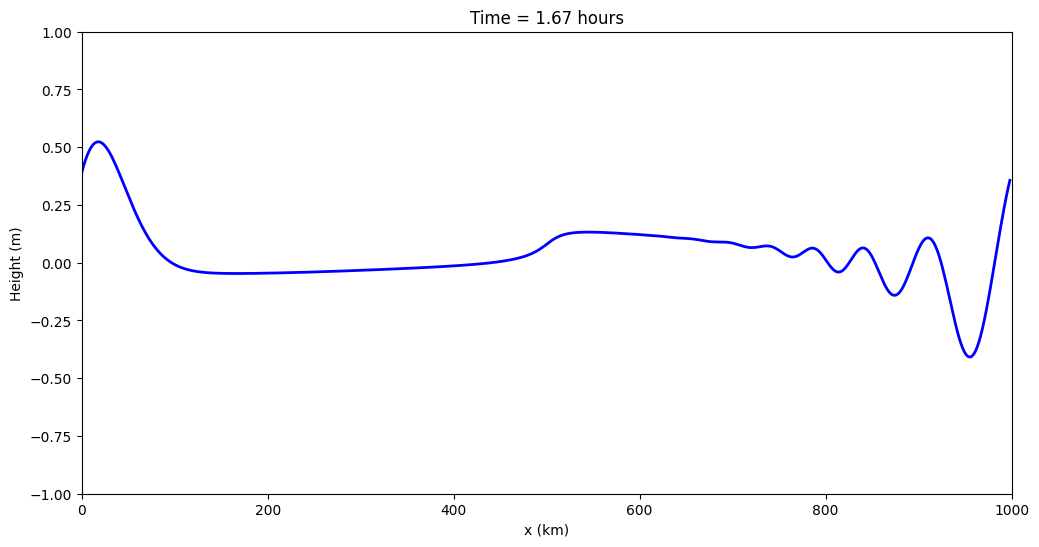

In [33]:
# create a figure and axes
fig = plt.figure(figsize=(12,6))

# Specify the axis limits and labels
plt.xlim((0, Lx / (1*kilometer)))
plt.ylim((-1, 1))
plt.xlabel('x (km)')
plt.ylabel('Height (m)')

# Create objects that will change during the animation
txt_title = plt.title('')
height, = plt.plot([], [], 'b', lw=2)

# Define an animation function
def drawframe(n):
    height.set_data(x/(1*kilometer), h_save[n,:])
    txt_title.set_text('Time = {0:.2f} hours'.format(t_save[n]/(1*hour)))
    return (height,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())


### 1.3 Student investigation
<a id='section1pt3'></a>
In the cells below, provide an expression for the expected wave speed and state any assumptions that are necessary to arrive at this. Then plot the wave speed from the output above and compare this with the expected value.

From the linear shallow water equations:
$$\frac{\partial u}{\partial t} = -g \frac{\partial h}{\partial x}$$
and using the anzatz $u=u_0 cos(k(x-ct))$ , $h=H_0 cos(k(x-ct))$

we get $$u_0 k c sin(k(x-ct))=g H_0 k sin(k(x-ct))$$
from which can get an expression for $u_0 = gH_0/c$. Subbing this back in gives us


$c=\pm \sqrt{g H_0}$ which is a constant value away from the sea mount. Therefore, using $H_0=4km$, we expect the waves to propogate a  constant speed of 198 m/s which doesn't vary in time or distance.

In this we have used the assumptions that the background ocean waves $u$ are small compared to the wave speed $c$ allowing the non-linear terms to be neglected due to scaling as the full shallow water equations scale like (using $t \approx 1/kc$, $x \approx 1/k$, $v \approx 0$ from continuity scaling):
$$u_0kc + u_0^2 k = -gH_0k$$
To obtain a linear equation we require $$\frac{u_0^2k}{u_0kc}= \frac{u_0}{c} << 1$$

Hence we require the background wave speed to be much smaller than the phase speed of the perturbed wave.

We can use the above forms of of $c$ and $u=gh/c$ to rewrite the relation as
$$\frac{u}{c}= \frac{gh}{gH_0}= \frac{h}{H_0}$$
Therefore, we also assume that the pertubations $h$ from the average sea level $H_0$ are small, so that they may be considered pertubations of the orignial situation, and that $H_0$ is constant far from the seamount.

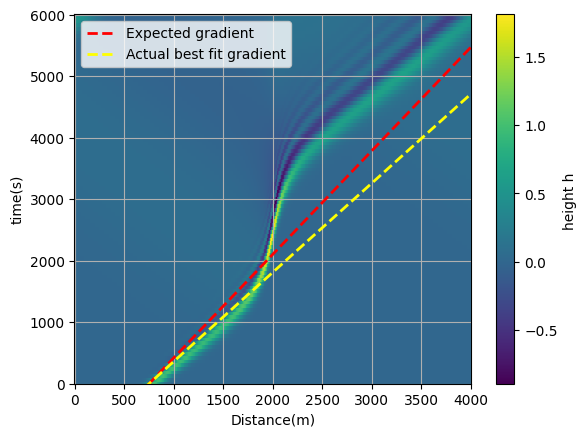

In [34]:

X=np.linspace(0, 4000, 512)
T=np.linspace(0, 6012, 101)
X, T= np.meshgrid(X, T)
plt.figure()
plt.pcolormesh(X, T, h_save)

plt.xlabel('Distance(m)')
plt.ylabel('time(s)')
line_x= np.linspace(0,4000,1000)
line_y= line_x * 1.684 -1263
line_z= line_x * 1.45 -1087.5
plt.plot(line_x, line_y, color='red', linewidth=2, linestyle='--', label='Expected gradient' )
plt.plot(line_x, line_z, color='yellow', linewidth=2, linestyle='--', label='Actual best fit gradient' )
plt.ylim(0,6012)
plt.colorbar(label='height h ')
plt.legend()
plt.grid(True)
plt.show()

In [35]:
print(h_save.shape)

(101, 512)


We can see here that the expected gradient is not a bad fit although it is a little steep, reflecting that the wave is travelling slightly faster than the theory, perhaps due to contributions from the background ocean waves. The expected gradient is a good fit for the model when the wave is far away from the sea mount whicg is located at 4km. However, when it reaches the sea mount, the gradient quickly increases, reflecting a reduction in phasepeed of the maximum point of the wave, shown in yellow. This is due to the reduction in H, which as we can see from the linear shallow water equations, is roughly proportional to the phase speed c. After the sea mount, as H_0 returns to its original level, the gradient returns to near its orginal value, showing how the peak of the wave acelerates back to pre sea mount behavour.

## 2.  2D Shallow water equations

Now, let's see how things change if we move to two dimensions. The script below solves the 2D shallow water equations:

$$ \partial_t u + g \partial_x(h) = - u*\partial_x u - v*\partial_y u$$
$$ \partial_t u + g \partial_y(h) = - u*\partial_x v - v*\partial_y v$$
$$ \partial_t h + \partial_x(u*H) + \partial_y(v*H)) = -\partial_x(h*u) - \partial_y(h*v)$$

We will initilize the Tsunami with the following equation
$$ h=e^{-x^2/w_1^2} $$
$$ u=(g/c)*h $$

where $c=\sqrt{gH_0}$ and $H_0$ is the constant reference depth. The relationship between $u$ and $h$ follows from linearized shallow water equations and corresponds to a wave propagating in the $+x$ direction with a speed $c$.

We will solve the equations in a square domain with periodic boundary conditions and a Gaussian seamount in the middle of the domain with total undisturbed fluid height

$$ H=H_0 - (H_0 - H_{min})e^{-(x^2+y^2)/w_2^2} $$

The Tsunami should propagate with speed $c$ over the deep ocean where the depth is constant, but the wave will be modified as it passes over the seamount.

### 2.1  Dedalus script to solve the 2D shallow water equations

In [36]:
# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Define the simulation units. This is optional, but will help us keep track of units
meter = 1
kilometer = meter * 1e3
second = 1
minute = 60
hour = 3600
day = hour * 24

# Specify the simulation parameters
Lx = 1000 * kilometer # The domain size in x
Ly = 1000 * kilometer # The domain size in y
Nx = 64 # The number of gridpoints in x
Ny = 64 # The number of gridpoints in y
g = 9.81 * meter / second**2 # Gravitational acceleration
H0 = 4 * kilometer # Reference ocean depth
c = np.sqrt(g*H0) # Wave speed over the deep ocean
H_min = 1 * kilometer # minimum depth above the seamount
w1 = 50 * kilometer # Set the width of the wave
w2 = 200 * kilometer # Width of the seamount
x1 = -300 * kilometer # Center of the wave at t=0

timestep = 60 * second # Specify the timestep
stop_sim_time = 60 * minute # Specify the stopping time

timestepper = dedalus.RK222
max_timestep = 0.125

# Bases
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(-Lx/2, Lx/2), dealias=3/2)
ybasis = dedalus.RealFourier(coords['y'], size=Ny, bounds=(-Ly/2, Ly/2), dealias=3/2)

x, y = dist.local_grids(xbasis, ybasis)

# Fields
u = dist.Field(name='u', bases=(xbasis, ybasis))
v = dist.Field(name='v', bases=(xbasis, ybasis))
h = dist.Field(name='h', bases=(xbasis, ybasis))
H = dist.Field(name='H', bases=(xbasis, ybasis))

# Initial conditions
H.change_scales(1)
h.change_scales(1) # Set values on regular grid
u.change_scales(1)
v.change_scales(1)
H['g'] = H0-(H0-H_min)*np.exp(-x**2.0/w2**2.0 - y**2.0/w2**2.0)
h['g'] = np.exp(-(x-x1)**2/w1**2)  # Initialize the dependent variable c with a Gaussian function (note ** is the exponentiation operator)
u['g'] = (g/c)*h['g']
v['g'] = 0

# Operators
dx = lambda a: dedalus.Differentiate(a, coords['x'])
dy = lambda a: dedalus.Differentiate(a, coords['y'])

# Problem
problem = dedalus.IVP([u, v, h], namespace=locals())
problem.add_equation("dt(u) + g*dx(h) = - u*dx(u) - v*dy(u)")
problem.add_equation("dt(v) + g*dy(h) = - u*dx(v) - v*dy(v)")
problem.add_equation("dt(h) + (dx(H*u) + dy(H*v)) = - dx(h*u) - dy(h*v)")

# Solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Analysis
snapshots = solver.evaluator.add_file_handler('snapshots', sim_dt=1*hour, max_writes=10)
snapshots.add_task(h, name='h')
snapshots.add_task(u, name='u')
snapshots.add_task(v, name='v')

h.change_scales(1)
h_save = [np.copy(h['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 1 == 0:
            h.change_scales(1)
            h_save.append(np.copy(h['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

h_save=np.array(h_save) # convert h_save to an np.array type to allow data slicing

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 18s, Remaining: 0s, Rate: 5.6e-02/s


2025-11-26 15:43:19,132 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 18s, Remaining: 0s, Rate: 5.6e-02/s


INFO:__main__:Starting main loop


2025-11-26 15:43:19,139 __main__ 0/1 INFO :: Starting main loop


INFO:solvers:Simulation stop time reached.


2025-11-26 15:43:28,585 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 60


2025-11-26 15:43:28,587 solvers 0/1 INFO :: Final iteration: 60


INFO:solvers:Final sim time: 3600.0


2025-11-26 15:43:28,590 solvers 0/1 INFO :: Final sim time: 3600.0


INFO:solvers:Setup time (init - iter 0): 17.75 sec


2025-11-26 15:43:28,592 solvers 0/1 INFO :: Setup time (init - iter 0): 17.75 sec


INFO:solvers:Warmup time (iter 0-10): 4.373 sec


2025-11-26 15:43:28,593 solvers 0/1 INFO :: Warmup time (iter 0-10): 4.373 sec


INFO:solvers:Run time (iter 10-end): 5.074 sec


2025-11-26 15:43:28,594 solvers 0/1 INFO :: Run time (iter 10-end): 5.074 sec


INFO:solvers:CPU time (iter 10-end): 0.00141 cpu-hr


2025-11-26 15:43:28,596 solvers 0/1 INFO :: CPU time (iter 10-end): 0.00141 cpu-hr


INFO:solvers:Speed: 2.347e+05 mode-stages/cpu-sec


2025-11-26 15:43:28,597 solvers 0/1 INFO :: Speed: 2.347e+05 mode-stages/cpu-sec


### 2.2  Plotting
The code below will make a movie of the height as a function of x and y

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2025-11-26 15:43:28,663 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp446932aj/temp.m4v


2025-11-26 15:43:28,665 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp446932aj/temp.m4v


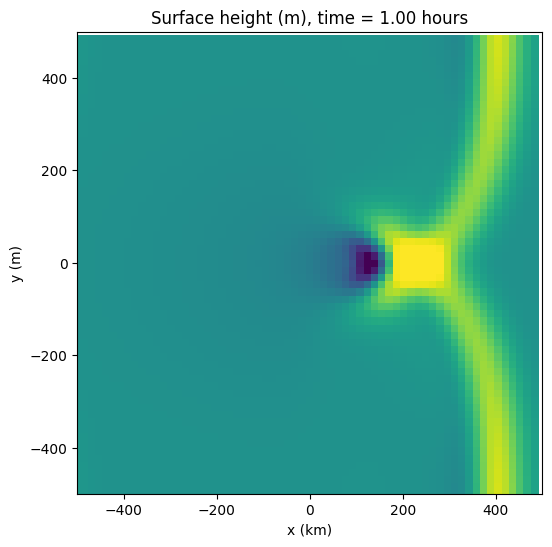

In [37]:
# create a figure and axes
fig = plt.figure(figsize=(6,6))

# Create arrays with the x and y coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))

# Define an animation function
def drawframe(n):
    plt.clf # clear the figure before plotting the next frame
    height = plt.pcolor(X/(1*kilometer), Y/(1*kilometer), h_save[n,:,:].T, vmin=-1, vmax=1)
    # Specify the axis limits and labels
    plt.xlim((-Lx/2 / (1*kilometer),Lx/2 / (1*kilometer)))
    plt.ylim((-Ly/2 / (1*kilometer),Ly/2 / (1*kilometer)))
    plt.xlabel('x (km)')
    plt.ylabel('y (m)')
    plt.title('Surface height (m), time = {0:.2f} hours'.format(t_save[n]/(1*hour)))
    return (height,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

### 2.3 Student investigation
<a id='section2pt3'></a>
Qualitatively describe the influence of the seamount and explain this behavior using the shallow water equations. You can assume that the wave amplitude and velocity are small in the shallow water equations.


The wave propogates as a plane wave away from the sea mount. As it approaches the sea mount, the water height($H_0$) decreases. Since the wave amplitude $u_0$ is small, the wave obeys the linear shallow water equations and so c is proportional to $\sqrt {H_0}$. Therefore the wave speed also reduces locally, creating a pertubation in the wave in the position of the sea mount. As the wave leaves the seamount, the water height increases again and the perturbed section of the wavefront accelerates, and begins to catch up to the rest of the front as seen in the video.

Try varying some parameters (e.g. the width and height of the wave and/or seamount) and comment on the results. When does the wave no longer obey the linear shallow water equations which are valid for small waves You don't need to do a comprehensive parameter space search, but you should run several simulations with one or two parameters varied.

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 18s, Remaining: 0s, Rate: 5.5e-02/s


2025-11-26 15:45:16,198 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 18s, Remaining: 0s, Rate: 5.5e-02/s


INFO:__main__:Starting main loop


2025-11-26 15:45:16,205 __main__ 0/1 INFO :: Starting main loop


INFO:solvers:Simulation stop time reached.


2025-11-26 15:45:25,203 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 60


2025-11-26 15:45:25,205 solvers 0/1 INFO :: Final iteration: 60


INFO:solvers:Final sim time: 3600.0


2025-11-26 15:45:25,206 solvers 0/1 INFO :: Final sim time: 3600.0


INFO:solvers:Setup time (init - iter 0): 18.07 sec


2025-11-26 15:45:25,208 solvers 0/1 INFO :: Setup time (init - iter 0): 18.07 sec


INFO:solvers:Warmup time (iter 0-10): 4.759 sec


2025-11-26 15:45:25,209 solvers 0/1 INFO :: Warmup time (iter 0-10): 4.759 sec


INFO:solvers:Run time (iter 10-end): 4.239 sec


2025-11-26 15:45:25,211 solvers 0/1 INFO :: Run time (iter 10-end): 4.239 sec


INFO:solvers:CPU time (iter 10-end): 0.001177 cpu-hr


2025-11-26 15:45:25,212 solvers 0/1 INFO :: CPU time (iter 10-end): 0.001177 cpu-hr


INFO:solvers:Speed: 2.809e+05 mode-stages/cpu-sec


2025-11-26 15:45:25,214 solvers 0/1 INFO :: Speed: 2.809e+05 mode-stages/cpu-sec


INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2025-11-26 15:45:25,275 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpg3k5x78g/temp.m4v


2025-11-26 15:45:25,277 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpg3k5x78g/temp.m4v


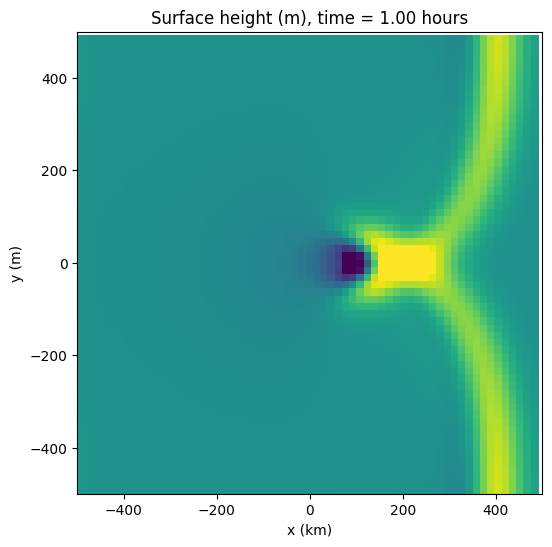

In [38]:
#SEA MOUNT = higher (hmin= 0.75 original), H0 = origninal
logger = logging.getLogger(__name__)

# Define the simulation units. This is optional, but will help us keep track of units
meter = 1
kilometer = meter * 1e3
second = 1
minute = 60
hour = 3600
day = hour * 24

# Specify the simulation parameters
Lx = 1000 * kilometer # The domain size in x
Ly = 1000 * kilometer # The domain size in y
Nx = 64 # The number of gridpoints in x
Ny = 64 # The number of gridpoints in y
g = 9.81 * meter / second**2 # Gravitational acceleration
H0 = 4 * kilometer # Reference ocean depth
c = np.sqrt(g*H0) # Wave speed over the deep ocean
H_min = 0.75 * kilometer # minimum depth above the seamount #NEW
w1 = 50 * kilometer # Set the width of the wave
w2 = 200 * kilometer # Width of the seamount
x1 = -300 * kilometer # Center of the wave at t=0

timestep = 60 * second # Specify the timestep
stop_sim_time = 60 * minute # Specify the stopping time

timestepper = dedalus.RK222
max_timestep = 0.125

# Bases
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(-Lx/2, Lx/2), dealias=3/2)
ybasis = dedalus.RealFourier(coords['y'], size=Ny, bounds=(-Ly/2, Ly/2), dealias=3/2)

x, y = dist.local_grids(xbasis, ybasis)

# Fields
u = dist.Field(name='u', bases=(xbasis, ybasis))
v = dist.Field(name='v', bases=(xbasis, ybasis))
h = dist.Field(name='h', bases=(xbasis, ybasis))
H = dist.Field(name='H', bases=(xbasis, ybasis))

# Initial conditions
H.change_scales(1)
h.change_scales(1) # Set values on regular grid
u.change_scales(1)
v.change_scales(1)
H['g'] = H0-(H0-H_min)*np.exp(-x**2.0/w2**2.0 - y**2.0/w2**2.0)
h['g'] = np.exp(-(x-x1)**2/w1**2)  # Initialize the dependent variable c with a Gaussian function (note ** is the exponentiation operator)
u['g'] = (g/c)*h['g']
v['g'] = 0

# Operators
dx = lambda a: dedalus.Differentiate(a, coords['x'])
dy = lambda a: dedalus.Differentiate(a, coords['y'])

# Problem
problem = dedalus.IVP([u, v, h], namespace=locals())
problem.add_equation("dt(u) + g*dx(h) = - u*dx(u) - v*dy(u)")
problem.add_equation("dt(v) + g*dy(h) = - u*dx(v) - v*dy(v)")
problem.add_equation("dt(h) + (dx(H*u) + dy(H*v)) = - dx(h*u) - dy(h*v)")

# Solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Analysis
snapshots = solver.evaluator.add_file_handler('snapshots', sim_dt=1*hour, max_writes=10)
snapshots.add_task(h, name='h')
snapshots.add_task(u, name='u')
snapshots.add_task(v, name='v')

h.change_scales(1)
h_save = [np.copy(h['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 1 == 0:
            h.change_scales(1)
            h_save.append(np.copy(h['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

h_save=np.array(h_save) # convert h_save to an np.array type to allow data slicing

# create a figure and axes
fig = plt.figure(figsize=(6,6))

# Create arrays with the x and y coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))

# Define an animation function
def drawframe(n):
    plt.clf # clear the figure before plotting the next frame
    height = plt.pcolor(X/(1*kilometer), Y/(1*kilometer), h_save[n,:,:].T, vmin=-1, vmax=1)
    # Specify the axis limits and labels
    plt.xlim((-Lx/2 / (1*kilometer),Lx/2 / (1*kilometer)))
    plt.ylim((-Ly/2 / (1*kilometer),Ly/2 / (1*kilometer)))
    plt.xlabel('x (km)')
    plt.ylabel('y (m)')
    plt.title('Surface height (m), time = {0:.2f} hours'.format(t_save[n]/(1*hour)))
    return (height,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 20s, Remaining: 0s, Rate: 5.0e-02/s


2025-11-26 16:20:27,664 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 20s, Remaining: 0s, Rate: 5.0e-02/s


INFO:__main__:Starting main loop


2025-11-26 16:20:27,670 __main__ 0/1 INFO :: Starting main loop


INFO:solvers:Simulation stop time reached.


2025-11-26 16:20:36,354 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 60


2025-11-26 16:20:36,356 solvers 0/1 INFO :: Final iteration: 60


INFO:solvers:Final sim time: 3600.0


2025-11-26 16:20:36,358 solvers 0/1 INFO :: Final sim time: 3600.0


INFO:solvers:Setup time (init - iter 0): 20.15 sec


2025-11-26 16:20:36,360 solvers 0/1 INFO :: Setup time (init - iter 0): 20.15 sec


INFO:solvers:Warmup time (iter 0-10): 4.398 sec


2025-11-26 16:20:36,361 solvers 0/1 INFO :: Warmup time (iter 0-10): 4.398 sec


INFO:solvers:Run time (iter 10-end): 4.285 sec


2025-11-26 16:20:36,363 solvers 0/1 INFO :: Run time (iter 10-end): 4.285 sec


INFO:solvers:CPU time (iter 10-end): 0.00119 cpu-hr


2025-11-26 16:20:36,365 solvers 0/1 INFO :: CPU time (iter 10-end): 0.00119 cpu-hr


INFO:solvers:Speed: 2.778e+05 mode-stages/cpu-sec


2025-11-26 16:20:36,366 solvers 0/1 INFO :: Speed: 2.778e+05 mode-stages/cpu-sec


INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2025-11-26 16:20:36,472 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpmzsz1q84/temp.m4v


2025-11-26 16:20:36,475 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpmzsz1q84/temp.m4v


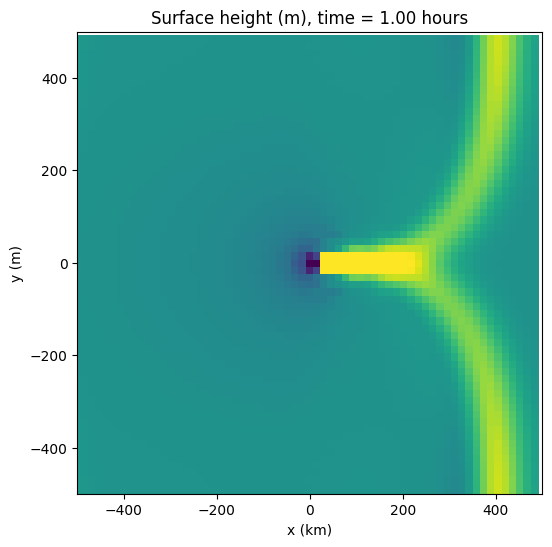

In [47]:
#SEA MOUNT = higher (hmin= 0.2 original), H0 = origninal
logger = logging.getLogger(__name__)

# Define the simulation units. This is optional, but will help us keep track of units
meter = 1
kilometer = meter * 1e3
second = 1
minute = 60
hour = 3600
day = hour * 24

# Specify the simulation parameters
Lx = 1000 * kilometer # The domain size in x
Ly = 1000 * kilometer # The domain size in y
Nx = 64 # The number of gridpoints in x
Ny = 64 # The number of gridpoints in y
g = 9.81 * meter / second**2 # Gravitational acceleration
H0 = 4 * kilometer # Reference ocean depth
c = np.sqrt(g*H0) # Wave speed over the deep ocean
H_min = 0.2 * kilometer # minimum depth above the seamount #NEW
w1 = 50 * kilometer # Set the width of the wave
w2 = 200 * kilometer # Width of the seamount
x1 = -300 * kilometer # Center of the wave at t=0

timestep = 60 * second # Specify the timestep
stop_sim_time = 60 * minute # Specify the stopping time

timestepper = dedalus.RK222
max_timestep = 0.125

# Bases
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(-Lx/2, Lx/2), dealias=3/2)
ybasis = dedalus.RealFourier(coords['y'], size=Ny, bounds=(-Ly/2, Ly/2), dealias=3/2)

x, y = dist.local_grids(xbasis, ybasis)

# Fields
u = dist.Field(name='u', bases=(xbasis, ybasis))
v = dist.Field(name='v', bases=(xbasis, ybasis))
h = dist.Field(name='h', bases=(xbasis, ybasis))
H = dist.Field(name='H', bases=(xbasis, ybasis))

# Initial conditions
H.change_scales(1)
h.change_scales(1) # Set values on regular grid
u.change_scales(1)
v.change_scales(1)
H['g'] = H0-(H0-H_min)*np.exp(-x**2.0/w2**2.0 - y**2.0/w2**2.0)
h['g'] = np.exp(-(x-x1)**2/w1**2)  # Initialize the dependent variable c with a Gaussian function (note ** is the exponentiation operator)
u['g'] = (g/c)*h['g']
v['g'] = 0

# Operators
dx = lambda a: dedalus.Differentiate(a, coords['x'])
dy = lambda a: dedalus.Differentiate(a, coords['y'])

# Problem
problem = dedalus.IVP([u, v, h], namespace=locals())
problem.add_equation("dt(u) + g*dx(h) = - u*dx(u) - v*dy(u)")
problem.add_equation("dt(v) + g*dy(h) = - u*dx(v) - v*dy(v)")
problem.add_equation("dt(h) + (dx(H*u) + dy(H*v)) = - dx(h*u) - dy(h*v)")

# Solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Analysis
snapshots = solver.evaluator.add_file_handler('snapshots', sim_dt=1*hour, max_writes=10)
snapshots.add_task(h, name='h')
snapshots.add_task(u, name='u')
snapshots.add_task(v, name='v')

h.change_scales(1)
h_save = [np.copy(h['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 1 == 0:
            h.change_scales(1)
            h_save.append(np.copy(h['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

h_save=np.array(h_save) # convert h_save to an np.array type to allow data slicing

# create a figure and axes
fig = plt.figure(figsize=(6,6))

# Create arrays with the x and y coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))

# Define an animation function
def drawframe(n):
    plt.clf # clear the figure before plotting the next frame
    height = plt.pcolor(X/(1*kilometer), Y/(1*kilometer), h_save[n,:,:].T, vmin=-1, vmax=1)
    # Specify the axis limits and labels
    plt.xlim((-Lx/2 / (1*kilometer),Lx/2 / (1*kilometer)))
    plt.ylim((-Ly/2 / (1*kilometer),Ly/2 / (1*kilometer)))
    plt.xlabel('x (km)')
    plt.ylabel('y (m)')
    plt.title('Surface height (m), time = {0:.2f} hours'.format(t_save[n]/(1*hour)))
    return (height,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 36s, Remaining: 0s, Rate: 2.8e-02/s


2025-11-26 16:18:19,927 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 36s, Remaining: 0s, Rate: 2.8e-02/s


INFO:__main__:Starting main loop


2025-11-26 16:18:19,936 __main__ 0/1 INFO :: Starting main loop


INFO:solvers:Simulation stop time reached.


2025-11-26 16:18:28,890 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 60


2025-11-26 16:18:28,892 solvers 0/1 INFO :: Final iteration: 60


INFO:solvers:Final sim time: 3600.0


2025-11-26 16:18:28,893 solvers 0/1 INFO :: Final sim time: 3600.0


INFO:solvers:Setup time (init - iter 0): 36.09 sec


2025-11-26 16:18:28,894 solvers 0/1 INFO :: Setup time (init - iter 0): 36.09 sec


INFO:solvers:Warmup time (iter 0-10): 4.344 sec


2025-11-26 16:18:28,896 solvers 0/1 INFO :: Warmup time (iter 0-10): 4.344 sec


INFO:solvers:Run time (iter 10-end): 4.609 sec


2025-11-26 16:18:28,897 solvers 0/1 INFO :: Run time (iter 10-end): 4.609 sec


INFO:solvers:CPU time (iter 10-end): 0.00128 cpu-hr


2025-11-26 16:18:28,898 solvers 0/1 INFO :: CPU time (iter 10-end): 0.00128 cpu-hr


INFO:solvers:Speed: 2.583e+05 mode-stages/cpu-sec


2025-11-26 16:18:28,900 solvers 0/1 INFO :: Speed: 2.583e+05 mode-stages/cpu-sec


INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2025-11-26 16:18:29,015 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpatg4cwx8/temp.m4v


2025-11-26 16:18:29,017 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpatg4cwx8/temp.m4v


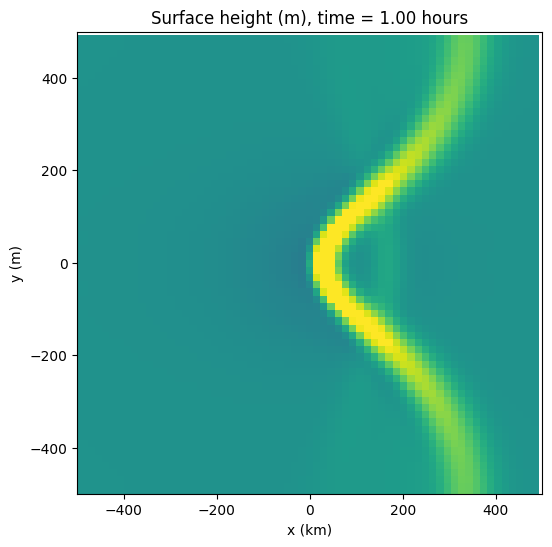

In [46]:
# sea mount = higher (0.5) and wider
logger = logging.getLogger(__name__)

# Define the simulation units. This is optional, but will help us keep track of units
meter = 1
kilometer = meter * 1e3
second = 1
minute = 60
hour = 3600
day = hour * 24

# Specify the simulation parameters
Lx = 1000 * kilometer # The domain size in x
Ly = 1000 * kilometer # The domain size in y
Nx = 64 # The number of gridpoints in x
Ny = 64 # The number of gridpoints in y
g = 9.81 * meter / second**2 # Gravitational acceleration
H0 = 4 * kilometer # Reference ocean depth NEW
c = np.sqrt(g*H0) # Wave speed over the deep ocean
H_min = 0.5 * kilometer # minimum depth above the seamount
w1 = 50 * kilometer # Set the width of the wave
w2 = 400 * kilometer # Width of the seamount
x1 = -300 * kilometer # Center of the wave at t=0

timestep = 60 * second # Specify the timestep
stop_sim_time = 60 * minute # Specify the stopping time

timestepper = dedalus.RK222
max_timestep = 0.125

# Bases
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(-Lx/2, Lx/2), dealias=3/2)
ybasis = dedalus.RealFourier(coords['y'], size=Ny, bounds=(-Ly/2, Ly/2), dealias=3/2)

x, y = dist.local_grids(xbasis, ybasis)

# Fields
u = dist.Field(name='u', bases=(xbasis, ybasis))
v = dist.Field(name='v', bases=(xbasis, ybasis))
h = dist.Field(name='h', bases=(xbasis, ybasis))
H = dist.Field(name='H', bases=(xbasis, ybasis))

# Initial conditions
H.change_scales(1)
h.change_scales(1) # Set values on regular grid
u.change_scales(1)
v.change_scales(1)
H['g'] = H0-(H0-H_min)*np.exp(-x**2.0/w2**2.0 - y**2.0/w2**2.0)
h['g'] = np.exp(-(x-x1)**2/w1**2)  # Initialize the dependent variable c with a Gaussian function (note ** is the exponentiation operator)
u['g'] = (g/c)*h['g']
v['g'] = 0

# Operators
dx = lambda a: dedalus.Differentiate(a, coords['x'])
dy = lambda a: dedalus.Differentiate(a, coords['y'])

# Problem
problem = dedalus.IVP([u, v, h], namespace=locals())
problem.add_equation("dt(u) + g*dx(h) = - u*dx(u) - v*dy(u)")
problem.add_equation("dt(v) + g*dy(h) = - u*dx(v) - v*dy(v)")
problem.add_equation("dt(h) + (dx(H*u) + dy(H*v)) = - dx(h*u) - dy(h*v)")

# Solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Analysis
snapshots = solver.evaluator.add_file_handler('snapshots', sim_dt=1*hour, max_writes=10)
snapshots.add_task(h, name='h')
snapshots.add_task(u, name='u')
snapshots.add_task(v, name='v')

h.change_scales(1)
h_save = [np.copy(h['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 1 == 0:
            h.change_scales(1)
            h_save.append(np.copy(h['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

h_save=np.array(h_save) # convert h_save to an np.array type to allow data slicing

# create a figure and axes
fig = plt.figure(figsize=(6,6))

# Create arrays with the x and y coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))

# Define an animation function
def drawframe(n):
    plt.clf # clear the figure before plotting the next frame
    height = plt.pcolor(X/(1*kilometer), Y/(1*kilometer), h_save[n,:,:].T, vmin=-1, vmax=1)
    # Specify the axis limits and labels
    plt.xlim((-Lx/2 / (1*kilometer),Lx/2 / (1*kilometer)))
    plt.ylim((-Ly/2 / (1*kilometer),Ly/2 / (1*kilometer)))
    plt.xlabel('x (km)')
    plt.ylabel('y (m)')
    plt.title('Surface height (m), time = {0:.2f} hours'.format(t_save[n]/(1*hour)))
    return (height,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 18s, Remaining: 0s, Rate: 5.5e-02/s


2025-11-26 15:51:21,699 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 18s, Remaining: 0s, Rate: 5.5e-02/s


INFO:__main__:Starting main loop


2025-11-26 15:51:21,705 __main__ 0/1 INFO :: Starting main loop


INFO:solvers:Simulation stop time reached.


2025-11-26 15:51:29,965 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 60


2025-11-26 15:51:29,966 solvers 0/1 INFO :: Final iteration: 60


INFO:solvers:Final sim time: 3600.0


2025-11-26 15:51:29,970 solvers 0/1 INFO :: Final sim time: 3600.0


INFO:solvers:Setup time (init - iter 0): 18.06 sec


2025-11-26 15:51:29,973 solvers 0/1 INFO :: Setup time (init - iter 0): 18.06 sec


INFO:solvers:Warmup time (iter 0-10): 4.198 sec


2025-11-26 15:51:29,976 solvers 0/1 INFO :: Warmup time (iter 0-10): 4.198 sec


INFO:solvers:Run time (iter 10-end): 4.06 sec


2025-11-26 15:51:29,977 solvers 0/1 INFO :: Run time (iter 10-end): 4.06 sec


INFO:solvers:CPU time (iter 10-end): 0.001128 cpu-hr


2025-11-26 15:51:29,978 solvers 0/1 INFO :: CPU time (iter 10-end): 0.001128 cpu-hr


INFO:solvers:Speed: 2.933e+05 mode-stages/cpu-sec


2025-11-26 15:51:29,979 solvers 0/1 INFO :: Speed: 2.933e+05 mode-stages/cpu-sec


INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2025-11-26 15:51:30,037 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmprgooxl9v/temp.m4v


2025-11-26 15:51:30,040 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmprgooxl9v/temp.m4v


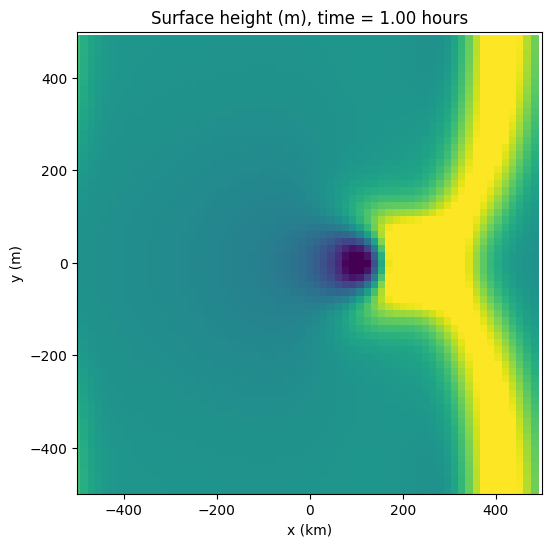

In [41]:
# WAVE= 1.5 X HIGHER, 1.5 X WIDER
logger = logging.getLogger(__name__)

# Define the simulation units. This is optional, but will help us keep track of units
meter = 1
kilometer = meter * 1e3
second = 1
minute = 60
hour = 3600
day = hour * 24

# Specify the simulation parameters
Lx = 1000 * kilometer # The domain size in x
Ly = 1000 * kilometer # The domain size in y
Nx = 64 # The number of gridpoints in x
Ny = 64 # The number of gridpoints in y
g = 9.81 * meter / second**2 # Gravitational acceleration
H0 = 4 * kilometer # Reference ocean depth
c = np.sqrt(g*H0) # Wave speed over the deep ocean
H_min = 1 * kilometer # minimum depth above the seamount
w1 = 75 * kilometer # Set the width of the wave NEW
w2 = 200 * kilometer # Width of the seamount
x1 = -300 * kilometer # Center of the wave at t=0

timestep = 60 * second # Specify the timestep
stop_sim_time = 60 * minute # Specify the stopping time

timestepper = dedalus.RK222
max_timestep = 0.125

# Bases
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(-Lx/2, Lx/2), dealias=3/2)
ybasis = dedalus.RealFourier(coords['y'], size=Ny, bounds=(-Ly/2, Ly/2), dealias=3/2)

x, y = dist.local_grids(xbasis, ybasis)

# Fields
u = dist.Field(name='u', bases=(xbasis, ybasis))
v = dist.Field(name='v', bases=(xbasis, ybasis))
h = dist.Field(name='h', bases=(xbasis, ybasis))
H = dist.Field(name='H', bases=(xbasis, ybasis))

# Initial conditions
H.change_scales(1)
h.change_scales(1) # Set values on regular grid
u.change_scales(1)
v.change_scales(1)
H['g'] = H0-(H0-H_min)*np.exp(-x**2.0/w2**2.0 - y**2.0/w2**2.0)
h['g'] = 1.5*np.exp(-(x-x1)**2/w1**2)  # Initialize the dependent variable c with a Gaussian function (note ** is the exponentiation operator)
u['g'] = (g/c)*h['g']
v['g'] = 0

# Operators
dx = lambda a: dedalus.Differentiate(a, coords['x'])
dy = lambda a: dedalus.Differentiate(a, coords['y'])

# Problem
problem = dedalus.IVP([u, v, h], namespace=locals())
problem.add_equation("dt(u) + g*dx(h) = - u*dx(u) - v*dy(u)")
problem.add_equation("dt(v) + g*dy(h) = - u*dx(v) - v*dy(v)")
problem.add_equation("dt(h) + (dx(H*u) + dy(H*v)) = - dx(h*u) - dy(h*v)")

# Solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Analysis
snapshots = solver.evaluator.add_file_handler('snapshots', sim_dt=1*hour, max_writes=10)
snapshots.add_task(h, name='h')
snapshots.add_task(u, name='u')
snapshots.add_task(v, name='v')

h.change_scales(1)
h_save = [np.copy(h['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 1 == 0:
            h.change_scales(1)
            h_save.append(np.copy(h['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

h_save=np.array(h_save) # convert h_save to an np.array type to allow data slicing

# create a figure and axes
fig = plt.figure(figsize=(6,6))

# Create arrays with the x and y coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))

# Define an animation function
def drawframe(n):
    plt.clf # clear the figure before plotting the next frame
    height = plt.pcolor(X/(1*kilometer), Y/(1*kilometer), h_save[n,:,:].T, vmin=-1, vmax=1)
    # Specify the axis limits and labels
    plt.xlim((-Lx/2 / (1*kilometer),Lx/2 / (1*kilometer)))
    plt.ylim((-Ly/2 / (1*kilometer),Ly/2 / (1*kilometer)))
    plt.xlabel('x (km)')
    plt.ylabel('y (m)')
    plt.title('Surface height (m), time = {0:.2f} hours'.format(t_save[n]/(1*hour)))
    return (height,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 21s, Remaining: 0s, Rate: 4.7e-02/s


2025-11-26 16:38:49,713 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 21s, Remaining: 0s, Rate: 4.7e-02/s


INFO:__main__:Starting main loop


2025-11-26 16:38:49,720 __main__ 0/1 INFO :: Starting main loop


INFO:solvers:Simulation stop time reached.


2025-11-26 16:38:58,707 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 60


2025-11-26 16:38:58,710 solvers 0/1 INFO :: Final iteration: 60


INFO:solvers:Final sim time: 3600.0


2025-11-26 16:38:58,712 solvers 0/1 INFO :: Final sim time: 3600.0


INFO:solvers:Setup time (init - iter 0): 21.44 sec


2025-11-26 16:38:58,714 solvers 0/1 INFO :: Setup time (init - iter 0): 21.44 sec


INFO:solvers:Warmup time (iter 0-10): 4.783 sec


2025-11-26 16:38:58,716 solvers 0/1 INFO :: Warmup time (iter 0-10): 4.783 sec


INFO:solvers:Run time (iter 10-end): 4.204 sec


2025-11-26 16:38:58,717 solvers 0/1 INFO :: Run time (iter 10-end): 4.204 sec


INFO:solvers:CPU time (iter 10-end): 0.001168 cpu-hr


2025-11-26 16:38:58,718 solvers 0/1 INFO :: CPU time (iter 10-end): 0.001168 cpu-hr


INFO:solvers:Speed: 2.832e+05 mode-stages/cpu-sec


2025-11-26 16:38:58,720 solvers 0/1 INFO :: Speed: 2.832e+05 mode-stages/cpu-sec


INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2025-11-26 16:38:58,785 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp8810ixph/temp.m4v


2025-11-26 16:38:58,787 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp8810ixph/temp.m4v


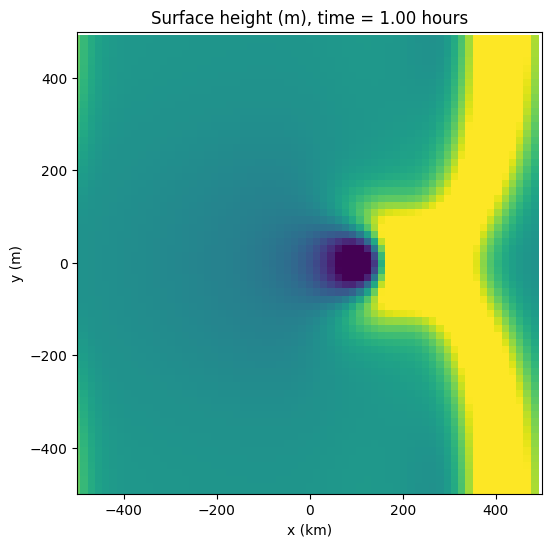

In [48]:
# WAVE= 2 X HIGHER, 1.5 X WIDER
logger = logging.getLogger(__name__)

# Define the simulation units. This is optional, but will help us keep track of units
meter = 1
kilometer = meter * 1e3
second = 1
minute = 60
hour = 3600
day = hour * 24

# Specify the simulation parameters
Lx = 1000 * kilometer # The domain size in x
Ly = 1000 * kilometer # The domain size in y
Nx = 64 # The number of gridpoints in x
Ny = 64 # The number of gridpoints in y
g = 9.81 * meter / second**2 # Gravitational acceleration
H0 = 4 * kilometer # Reference ocean depth NEW
c = np.sqrt(g*H0) # Wave speed over the deep ocean
H_min = 1 * kilometer # minimum depth above the seamount
w1 = 75 * kilometer # Set the width of the wave
w2 = 200 * kilometer # Width of the seamount
x1 = -300 * kilometer # Center of the wave at t=0

timestep = 60 * second # Specify the timestep
stop_sim_time = 60 * minute # Specify the stopping time

timestepper = dedalus.RK222
max_timestep = 0.125

# Bases
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(-Lx/2, Lx/2), dealias=3/2)
ybasis = dedalus.RealFourier(coords['y'], size=Ny, bounds=(-Ly/2, Ly/2), dealias=3/2)

x, y = dist.local_grids(xbasis, ybasis)

# Fields
u = dist.Field(name='u', bases=(xbasis, ybasis))
v = dist.Field(name='v', bases=(xbasis, ybasis))
h = dist.Field(name='h', bases=(xbasis, ybasis))
H = dist.Field(name='H', bases=(xbasis, ybasis))

# Initial conditions
H.change_scales(1)
h.change_scales(1) # Set values on regular grid
u.change_scales(1)
v.change_scales(1)
H['g'] = H0-(H0-H_min)*np.exp(-x**2.0/w2**2.0 - y**2.0/w2**2.0)
h['g'] = 2*np.exp(-(x-x1)**2/w1**2)  # Initialize the dependent variable c with a Gaussian function (note ** is the exponentiation operator)
u['g'] = (g/c)*h['g']
v['g'] = 0

# Operators
dx = lambda a: dedalus.Differentiate(a, coords['x'])
dy = lambda a: dedalus.Differentiate(a, coords['y'])

# Problem
problem = dedalus.IVP([u, v, h], namespace=locals())
problem.add_equation("dt(u) + g*dx(h) = - u*dx(u) - v*dy(u)")
problem.add_equation("dt(v) + g*dy(h) = - u*dx(v) - v*dy(v)")
problem.add_equation("dt(h) + (dx(H*u) + dy(H*v)) = - dx(h*u) - dy(h*v)")

# Solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Analysis
snapshots = solver.evaluator.add_file_handler('snapshots', sim_dt=1*hour, max_writes=10)
snapshots.add_task(h, name='h')
snapshots.add_task(u, name='u')
snapshots.add_task(v, name='v')

h.change_scales(1)
h_save = [np.copy(h['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 1 == 0:
            h.change_scales(1)
            h_save.append(np.copy(h['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

h_save=np.array(h_save) # convert h_save to an np.array type to allow data slicing

# create a figure and axes
fig = plt.figure(figsize=(6,6))

# Create arrays with the x and y coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))

# Define an animation function
def drawframe(n):
    plt.clf # clear the figure before plotting the next frame
    height = plt.pcolor(X/(1*kilometer), Y/(1*kilometer), h_save[n,:,:].T, vmin=-1, vmax=1)
    # Specify the axis limits and labels
    plt.xlim((-Lx/2 / (1*kilometer),Lx/2 / (1*kilometer)))
    plt.ylim((-Ly/2 / (1*kilometer),Ly/2 / (1*kilometer)))
    plt.xlabel('x (km)')
    plt.ylabel('y (m)')
    plt.title('Surface height (m), time = {0:.2f} hours'.format(t_save[n]/(1*hour)))
    return (height,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 17s, Remaining: 0s, Rate: 5.8e-02/s


2025-11-26 16:40:46,877 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 17s, Remaining: 0s, Rate: 5.8e-02/s


INFO:__main__:Starting main loop


2025-11-26 16:40:46,883 __main__ 0/1 INFO :: Starting main loop


INFO:solvers:Simulation stop time reached.


2025-11-26 16:40:56,111 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 60


2025-11-26 16:40:56,112 solvers 0/1 INFO :: Final iteration: 60


INFO:solvers:Final sim time: 3600.0


2025-11-26 16:40:56,114 solvers 0/1 INFO :: Final sim time: 3600.0


INFO:solvers:Setup time (init - iter 0): 17.33 sec


2025-11-26 16:40:56,116 solvers 0/1 INFO :: Setup time (init - iter 0): 17.33 sec


INFO:solvers:Warmup time (iter 0-10): 5.156 sec


2025-11-26 16:40:56,118 solvers 0/1 INFO :: Warmup time (iter 0-10): 5.156 sec


INFO:solvers:Run time (iter 10-end): 4.071 sec


2025-11-26 16:40:56,121 solvers 0/1 INFO :: Run time (iter 10-end): 4.071 sec


INFO:solvers:CPU time (iter 10-end): 0.001131 cpu-hr


2025-11-26 16:40:56,124 solvers 0/1 INFO :: CPU time (iter 10-end): 0.001131 cpu-hr


INFO:solvers:Speed: 2.925e+05 mode-stages/cpu-sec


2025-11-26 16:40:56,126 solvers 0/1 INFO :: Speed: 2.925e+05 mode-stages/cpu-sec


INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2025-11-26 16:40:56,181 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpny26zx00/temp.m4v


2025-11-26 16:40:56,183 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpny26zx00/temp.m4v


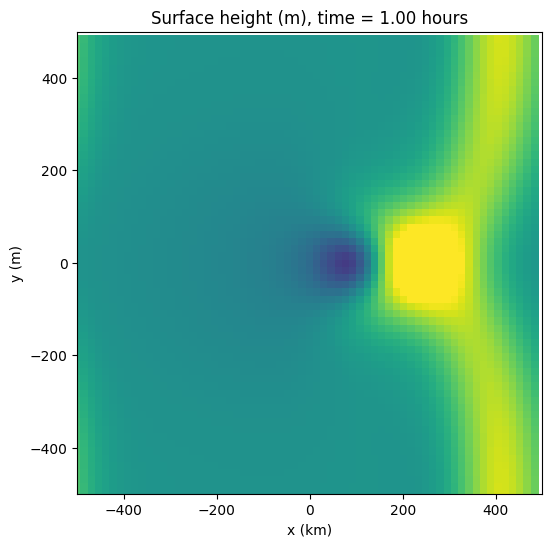

In [49]:
# WAVE= 1 X HIGHER, 2 X WIDER
logger = logging.getLogger(__name__)

# Define the simulation units. This is optional, but will help us keep track of units
meter = 1
kilometer = meter * 1e3
second = 1
minute = 60
hour = 3600
day = hour * 24

# Specify the simulation parameters
Lx = 1000 * kilometer # The domain size in x
Ly = 1000 * kilometer # The domain size in y
Nx = 64 # The number of gridpoints in x
Ny = 64 # The number of gridpoints in y
g = 9.81 * meter / second**2 # Gravitational acceleration
H0 = 4 * kilometer # Reference ocean depth
c = np.sqrt(g*H0) # Wave speed over the deep ocean
H_min = 1 * kilometer # minimum depth above the seamount
w1 = 100 * kilometer # Set the width of the wave
w2 = 200 * kilometer # Width of the seamount
x1 = -300 * kilometer # Center of the wave at t=0

timestep = 60 * second # Specify the timestep
stop_sim_time = 60 * minute # Specify the stopping time

timestepper = dedalus.RK222
max_timestep = 0.125

# Bases
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(-Lx/2, Lx/2), dealias=3/2)
ybasis = dedalus.RealFourier(coords['y'], size=Ny, bounds=(-Ly/2, Ly/2), dealias=3/2)

x, y = dist.local_grids(xbasis, ybasis)

# Fields
u = dist.Field(name='u', bases=(xbasis, ybasis))
v = dist.Field(name='v', bases=(xbasis, ybasis))
h = dist.Field(name='h', bases=(xbasis, ybasis))
H = dist.Field(name='H', bases=(xbasis, ybasis))

# Initial conditions
H.change_scales(1)
h.change_scales(1) # Set values on regular grid
u.change_scales(1)
v.change_scales(1)
H['g'] = H0-(H0-H_min)*np.exp(-x**2.0/w2**2.0 - y**2.0/w2**2.0)
h['g'] = np.exp(-(x-x1)**2/w1**2)  # Initialize the dependent variable c with a Gaussian function (note ** is the exponentiation operator)
u['g'] = (g/c)*h['g']
v['g'] = 0

# Operators
dx = lambda a: dedalus.Differentiate(a, coords['x'])
dy = lambda a: dedalus.Differentiate(a, coords['y'])

# Problem
problem = dedalus.IVP([u, v, h], namespace=locals())
problem.add_equation("dt(u) + g*dx(h) = - u*dx(u) - v*dy(u)")
problem.add_equation("dt(v) + g*dy(h) = - u*dx(v) - v*dy(v)")
problem.add_equation("dt(h) + (dx(H*u) + dy(H*v)) = - dx(h*u) - dy(h*v)")

# Solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Analysis
snapshots = solver.evaluator.add_file_handler('snapshots', sim_dt=1*hour, max_writes=10)
snapshots.add_task(h, name='h')
snapshots.add_task(u, name='u')
snapshots.add_task(v, name='v')

h.change_scales(1)
h_save = [np.copy(h['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 1 == 0:
            h.change_scales(1)
            h_save.append(np.copy(h['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

h_save=np.array(h_save) # convert h_save to an np.array type to allow data slicing

# create a figure and axes
fig = plt.figure(figsize=(6,6))

# Create arrays with the x and y coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))

# Define an animation function
def drawframe(n):
    plt.clf # clear the figure before plotting the next frame
    height = plt.pcolor(X/(1*kilometer), Y/(1*kilometer), h_save[n,:,:].T, vmin=-1, vmax=1)
    # Specify the axis limits and labels
    plt.xlim((-Lx/2 / (1*kilometer),Lx/2 / (1*kilometer)))
    plt.ylim((-Ly/2 / (1*kilometer),Ly/2 / (1*kilometer)))
    plt.xlabel('x (km)')
    plt.ylabel('y (m)')
    plt.title('Surface height (m), time = {0:.2f} hours'.format(t_save[n]/(1*hour)))
    return (height,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

STUDENT ANSWER HERE (~ 1 PARAGRAPH)

These results tell us something about the critical relationship between $h$ and $H_0$ or $u$ and $c$ causes the shallow water equations to break down. In plots 1 and 2 we can see that while when the seamount is 250m higher (Hmin=750m), the wave still proporates similarly to before, with plane waves that slow down and speed up around the mount. However, at Hmin=(), the shallow water equations no longer hold as qualitatively the perturbation no longer catches uo to the wave from after the mount and instead a large ripple effect is produced. This is because as the layer between the mount and the surface is very small, the wave slows down so much that $c$ is comparable to $u$ and the linear approximation no longer holds.

In plots 4 and 5, the starting wave has been varied to be both taller and wider. While the wave follows the expected behaviour at h=1.5h, at h=2h the wave starts to deform before the seamount and produces a large circular wave after the seamount. This is because h and H_0 are beginning to become comparable so the perturbations from the wave are harder to differentiate from the background ocean perturbations and also the wavelength is comparable to the gap between the sea mount and the surface meaning that it somewhat resembles a single slit interference pattern as only one wavefront fits through the gap and then spreads. This is further shown in the final picture from the video with alternating areas of high and low amplitude due to constructive and destructive interference instead of one continuous wavefront.

Expect to see that as we increase H0 (ie the wave gets larger) or decrease Hmin ie make the mount larger, the waves will at some point not obey the shallow water equations. this is because the height of the wave will become comaprarble to the height of the background ocean wave and ho will become comaprable to H0 ie we can no longer neglect the non linear terms.

this will look like the wave not holding its shape possibly even before the mount as it will be affected by the background ocean wave. as it passes over the mount it will no longer rebalacne the pertubation afterwards? because the perutbation will be too large and will create a growing instability?

## 3. Shallow water equations on a sphere

Of course the Earth isn't a flat plane. A great strength of Dedalus is its flexibility to solve equations in various geometries. The script below solves the 2D shallow water equations on a spherical shell, where the azimuth and colatitude are the independent variables. The colatitude is the complementary angle to the latitude such that the colatitude is $0^\circ$ at the North Pole, $90^\circ$ at the Equator, and $180^\circ$ at the South Pole. The spherical geometry also allows us to take into account the Earth's rotation in a realistic way. In this part of the project, we will assume that the bottom of the ocean is flat and that the resting height of the ocean is a constant $H$.  

We will use Dedalus to solve the following equations:
$$ \partial_t \mathbf{u} + g \nabla h + 2 \Omega \hat{\mathbf{z}} \times \mathbf{u} = -\mathbf{u} \cdot \nabla \mathbf{u} $$
$$ \partial_t + H \nabla \cdot \mathbf{u} = -\nabla \cdot (h \mathbf{u}) $$

where $\mathbf{u}$ is the velocity vector, $\Omega$ is the Earth's angular velocity (in radians per second), and $\hat{\mathbf{z}}$ is a unit vector aligned with the North Pole. Note that we have written the equations above in vector form. Dedalus includes vector calculus operators that make it very natural to solve equations like this without worrying about the particular form of the vector operators in a curvilinear coordinate system.

### 3.1  Dedalus script for 2D shallow water equations on a sphere

In [4]:
# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Define the simulation units. This is optional, but will help us keep track of units
meter = 1
kilometer = meter * 1e3
second = 1
minute = 60
hour = 3600
day = hour * 24

# Parameters
Nphi = 128 # Number of gridpoints in phi (longitude)
Ntheta = 64 # Number of gridpoints in theta (colatitude)
R = 6.37122e3 * kilometer
Omega = 2 * np.pi / (1 * day) # Earth's angular velocity in radians per second
g = 9.80616 * meter / second**2 # Gravitational acceleration
H = 4 * kilometer # Depth of the ocean
width = 2*np.pi*10/360 # Width of the initial Gaussian in radians
phi0 = np.pi # Longitude of the initial Gaussian height perturbation in radians
theta0 = np.pi/4 # Colatitude of the initial Gaussian height perturbation in radians

timestep = 600 * second
stop_sim_time = 10 * day

# Bases
coords = dedalus.S2Coordinates('phi', 'theta')
dist = dedalus.Distributor(coords, dtype=np.float64)
basis = dedalus.SphereBasis(coords, (Nphi, Ntheta), radius=R, dealias=3/2, dtype=np.float64)

# Define the coordinates
phi, theta = dist.local_grids(basis) # Longitude and colatitude
lat = 360*(np.pi / 2 - theta)/(2*np.pi)  # latitude in degrees

# Fields
u = dist.VectorField(coords, name='u', bases=basis)
h = dist.Field(name='h', bases=basis)

# Operators
# First, create an operator to perform the cross product: "z x ", where z is the local vertical unit vector
# The "skew" operator performs a 90 degree rotation of a vector field,
# so that skew([u,v]) = [-v, u].  MulCosine multiplies by the cosine of the latitude
zcross = lambda A: dedalus.MulCosine(dedalus.skew(A))

# Set the initial conditions
h.change_scales(1) # Set values on regular grid
u.change_scales(1)
h['g'] = np.exp(-((phi-phi0)**2+(theta-theta0)**2)/width**2)  # Initialize the dependent variable c with a Gaussian function (note ** is the exponentiation operator)
# Set the initial velocity to zero
u['g'][0] = 0 # the x-component of the velocity
u['g'][1] = 0 # the y-component of the velocity

# Problem
problem = dedalus.IVP([u, h], namespace=locals())
problem.add_equation("dt(u) + g*grad(h) + 2*Omega*zcross(u) = - u@grad(u)")
problem.add_equation("dt(h) + H*div(u) = - div(h*u)")

# Solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

h.change_scales(1)
h_save = [np.copy(h['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            h.change_scales(1)
            h_save.append(np.copy(h['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

h_save = np.array(h_save)

INFO:subsystems:Building subproblem matrices 1/63 (~2%) Elapsed: 0s, Remaining: 1s, Rate: 4.5e+01/s


2025-11-26 18:30:52,762 subsystems 0/1 INFO :: Building subproblem matrices 1/63 (~2%) Elapsed: 0s, Remaining: 1s, Rate: 4.5e+01/s


INFO:subsystems:Building subproblem matrices 7/63 (~11%) Elapsed: 0s, Remaining: 1s, Rate: 6.4e+01/s


2025-11-26 18:30:52,849 subsystems 0/1 INFO :: Building subproblem matrices 7/63 (~11%) Elapsed: 0s, Remaining: 1s, Rate: 6.4e+01/s


INFO:subsystems:Building subproblem matrices 14/63 (~22%) Elapsed: 0s, Remaining: 1s, Rate: 6.5e+01/s


2025-11-26 18:30:52,955 subsystems 0/1 INFO :: Building subproblem matrices 14/63 (~22%) Elapsed: 0s, Remaining: 1s, Rate: 6.5e+01/s


INFO:subsystems:Building subproblem matrices 21/63 (~33%) Elapsed: 0s, Remaining: 1s, Rate: 6.3e+01/s


2025-11-26 18:30:53,072 subsystems 0/1 INFO :: Building subproblem matrices 21/63 (~33%) Elapsed: 0s, Remaining: 1s, Rate: 6.3e+01/s


INFO:subsystems:Building subproblem matrices 28/63 (~44%) Elapsed: 0s, Remaining: 1s, Rate: 6.4e+01/s


2025-11-26 18:30:53,176 subsystems 0/1 INFO :: Building subproblem matrices 28/63 (~44%) Elapsed: 0s, Remaining: 1s, Rate: 6.4e+01/s


INFO:subsystems:Building subproblem matrices 35/63 (~56%) Elapsed: 1s, Remaining: 0s, Rate: 6.5e+01/s


2025-11-26 18:30:53,280 subsystems 0/1 INFO :: Building subproblem matrices 35/63 (~56%) Elapsed: 1s, Remaining: 0s, Rate: 6.5e+01/s


INFO:subsystems:Building subproblem matrices 42/63 (~67%) Elapsed: 1s, Remaining: 0s, Rate: 6.5e+01/s


2025-11-26 18:30:53,384 subsystems 0/1 INFO :: Building subproblem matrices 42/63 (~67%) Elapsed: 1s, Remaining: 0s, Rate: 6.5e+01/s


INFO:subsystems:Building subproblem matrices 49/63 (~78%) Elapsed: 1s, Remaining: 0s, Rate: 6.5e+01/s


2025-11-26 18:30:53,493 subsystems 0/1 INFO :: Building subproblem matrices 49/63 (~78%) Elapsed: 1s, Remaining: 0s, Rate: 6.5e+01/s


INFO:subsystems:Building subproblem matrices 56/63 (~89%) Elapsed: 1s, Remaining: 0s, Rate: 6.1e+01/s


2025-11-26 18:30:53,665 subsystems 0/1 INFO :: Building subproblem matrices 56/63 (~89%) Elapsed: 1s, Remaining: 0s, Rate: 6.1e+01/s


INFO:subsystems:Building subproblem matrices 63/63 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 5.9e+01/s


2025-11-26 18:30:53,815 subsystems 0/1 INFO :: Building subproblem matrices 63/63 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 5.9e+01/s


INFO:__main__:Starting main loop


2025-11-26 18:30:53,821 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=6.000000e+02, dt=6.000000e+02


2025-11-26 18:30:56,678 __main__ 0/1 INFO :: Iteration=1, Time=6.000000e+02, dt=6.000000e+02


INFO:__main__:Iteration=11, Time=6.600000e+03, dt=6.000000e+02


2025-11-26 18:30:57,333 __main__ 0/1 INFO :: Iteration=11, Time=6.600000e+03, dt=6.000000e+02


INFO:__main__:Iteration=21, Time=1.260000e+04, dt=6.000000e+02


2025-11-26 18:30:57,648 __main__ 0/1 INFO :: Iteration=21, Time=1.260000e+04, dt=6.000000e+02


INFO:__main__:Iteration=31, Time=1.860000e+04, dt=6.000000e+02


2025-11-26 18:30:57,954 __main__ 0/1 INFO :: Iteration=31, Time=1.860000e+04, dt=6.000000e+02


INFO:__main__:Iteration=41, Time=2.460000e+04, dt=6.000000e+02


2025-11-26 18:30:58,258 __main__ 0/1 INFO :: Iteration=41, Time=2.460000e+04, dt=6.000000e+02


INFO:__main__:Iteration=51, Time=3.060000e+04, dt=6.000000e+02


2025-11-26 18:30:58,625 __main__ 0/1 INFO :: Iteration=51, Time=3.060000e+04, dt=6.000000e+02


INFO:__main__:Iteration=61, Time=3.660000e+04, dt=6.000000e+02


2025-11-26 18:30:58,984 __main__ 0/1 INFO :: Iteration=61, Time=3.660000e+04, dt=6.000000e+02


INFO:__main__:Iteration=71, Time=4.260000e+04, dt=6.000000e+02


2025-11-26 18:30:59,362 __main__ 0/1 INFO :: Iteration=71, Time=4.260000e+04, dt=6.000000e+02


INFO:__main__:Iteration=81, Time=4.860000e+04, dt=6.000000e+02


2025-11-26 18:30:59,714 __main__ 0/1 INFO :: Iteration=81, Time=4.860000e+04, dt=6.000000e+02


INFO:__main__:Iteration=91, Time=5.460000e+04, dt=6.000000e+02


2025-11-26 18:31:00,074 __main__ 0/1 INFO :: Iteration=91, Time=5.460000e+04, dt=6.000000e+02


INFO:__main__:Iteration=101, Time=6.060000e+04, dt=6.000000e+02


2025-11-26 18:31:00,467 __main__ 0/1 INFO :: Iteration=101, Time=6.060000e+04, dt=6.000000e+02


INFO:__main__:Iteration=111, Time=6.660000e+04, dt=6.000000e+02


2025-11-26 18:31:00,832 __main__ 0/1 INFO :: Iteration=111, Time=6.660000e+04, dt=6.000000e+02


INFO:__main__:Iteration=121, Time=7.260000e+04, dt=6.000000e+02


2025-11-26 18:31:01,168 __main__ 0/1 INFO :: Iteration=121, Time=7.260000e+04, dt=6.000000e+02


INFO:__main__:Iteration=131, Time=7.860000e+04, dt=6.000000e+02


2025-11-26 18:31:01,537 __main__ 0/1 INFO :: Iteration=131, Time=7.860000e+04, dt=6.000000e+02


INFO:__main__:Iteration=141, Time=8.460000e+04, dt=6.000000e+02


2025-11-26 18:31:01,888 __main__ 0/1 INFO :: Iteration=141, Time=8.460000e+04, dt=6.000000e+02


INFO:__main__:Iteration=151, Time=9.060000e+04, dt=6.000000e+02


2025-11-26 18:31:02,244 __main__ 0/1 INFO :: Iteration=151, Time=9.060000e+04, dt=6.000000e+02


INFO:__main__:Iteration=161, Time=9.660000e+04, dt=6.000000e+02


2025-11-26 18:31:02,606 __main__ 0/1 INFO :: Iteration=161, Time=9.660000e+04, dt=6.000000e+02


INFO:__main__:Iteration=171, Time=1.026000e+05, dt=6.000000e+02


2025-11-26 18:31:02,961 __main__ 0/1 INFO :: Iteration=171, Time=1.026000e+05, dt=6.000000e+02


INFO:__main__:Iteration=181, Time=1.086000e+05, dt=6.000000e+02


2025-11-26 18:31:03,321 __main__ 0/1 INFO :: Iteration=181, Time=1.086000e+05, dt=6.000000e+02


INFO:__main__:Iteration=191, Time=1.146000e+05, dt=6.000000e+02


2025-11-26 18:31:03,686 __main__ 0/1 INFO :: Iteration=191, Time=1.146000e+05, dt=6.000000e+02


INFO:__main__:Iteration=201, Time=1.206000e+05, dt=6.000000e+02


2025-11-26 18:31:04,043 __main__ 0/1 INFO :: Iteration=201, Time=1.206000e+05, dt=6.000000e+02


INFO:__main__:Iteration=211, Time=1.266000e+05, dt=6.000000e+02


2025-11-26 18:31:04,402 __main__ 0/1 INFO :: Iteration=211, Time=1.266000e+05, dt=6.000000e+02


INFO:__main__:Iteration=221, Time=1.326000e+05, dt=6.000000e+02


2025-11-26 18:31:04,773 __main__ 0/1 INFO :: Iteration=221, Time=1.326000e+05, dt=6.000000e+02


INFO:__main__:Iteration=231, Time=1.386000e+05, dt=6.000000e+02


2025-11-26 18:31:05,241 __main__ 0/1 INFO :: Iteration=231, Time=1.386000e+05, dt=6.000000e+02


INFO:__main__:Iteration=241, Time=1.446000e+05, dt=6.000000e+02


2025-11-26 18:31:05,765 __main__ 0/1 INFO :: Iteration=241, Time=1.446000e+05, dt=6.000000e+02


INFO:__main__:Iteration=251, Time=1.506000e+05, dt=6.000000e+02


2025-11-26 18:31:06,330 __main__ 0/1 INFO :: Iteration=251, Time=1.506000e+05, dt=6.000000e+02


INFO:__main__:Iteration=261, Time=1.566000e+05, dt=6.000000e+02


2025-11-26 18:31:06,712 __main__ 0/1 INFO :: Iteration=261, Time=1.566000e+05, dt=6.000000e+02


INFO:__main__:Iteration=271, Time=1.626000e+05, dt=6.000000e+02


2025-11-26 18:31:07,021 __main__ 0/1 INFO :: Iteration=271, Time=1.626000e+05, dt=6.000000e+02


INFO:__main__:Iteration=281, Time=1.686000e+05, dt=6.000000e+02


2025-11-26 18:31:07,327 __main__ 0/1 INFO :: Iteration=281, Time=1.686000e+05, dt=6.000000e+02


INFO:__main__:Iteration=291, Time=1.746000e+05, dt=6.000000e+02


2025-11-26 18:31:07,644 __main__ 0/1 INFO :: Iteration=291, Time=1.746000e+05, dt=6.000000e+02


INFO:__main__:Iteration=301, Time=1.806000e+05, dt=6.000000e+02


2025-11-26 18:31:07,940 __main__ 0/1 INFO :: Iteration=301, Time=1.806000e+05, dt=6.000000e+02


INFO:__main__:Iteration=311, Time=1.866000e+05, dt=6.000000e+02


2025-11-26 18:31:08,276 __main__ 0/1 INFO :: Iteration=311, Time=1.866000e+05, dt=6.000000e+02


INFO:__main__:Iteration=321, Time=1.926000e+05, dt=6.000000e+02


2025-11-26 18:31:08,584 __main__ 0/1 INFO :: Iteration=321, Time=1.926000e+05, dt=6.000000e+02


INFO:__main__:Iteration=331, Time=1.986000e+05, dt=6.000000e+02


2025-11-26 18:31:08,911 __main__ 0/1 INFO :: Iteration=331, Time=1.986000e+05, dt=6.000000e+02


INFO:__main__:Iteration=341, Time=2.046000e+05, dt=6.000000e+02


2025-11-26 18:31:09,211 __main__ 0/1 INFO :: Iteration=341, Time=2.046000e+05, dt=6.000000e+02


INFO:__main__:Iteration=351, Time=2.106000e+05, dt=6.000000e+02


2025-11-26 18:31:09,515 __main__ 0/1 INFO :: Iteration=351, Time=2.106000e+05, dt=6.000000e+02


INFO:__main__:Iteration=361, Time=2.166000e+05, dt=6.000000e+02


2025-11-26 18:31:09,873 __main__ 0/1 INFO :: Iteration=361, Time=2.166000e+05, dt=6.000000e+02


INFO:__main__:Iteration=371, Time=2.226000e+05, dt=6.000000e+02


2025-11-26 18:31:10,223 __main__ 0/1 INFO :: Iteration=371, Time=2.226000e+05, dt=6.000000e+02


INFO:__main__:Iteration=381, Time=2.286000e+05, dt=6.000000e+02


2025-11-26 18:31:10,582 __main__ 0/1 INFO :: Iteration=381, Time=2.286000e+05, dt=6.000000e+02


INFO:__main__:Iteration=391, Time=2.346000e+05, dt=6.000000e+02


2025-11-26 18:31:10,903 __main__ 0/1 INFO :: Iteration=391, Time=2.346000e+05, dt=6.000000e+02


INFO:__main__:Iteration=401, Time=2.406000e+05, dt=6.000000e+02


2025-11-26 18:31:11,211 __main__ 0/1 INFO :: Iteration=401, Time=2.406000e+05, dt=6.000000e+02


INFO:__main__:Iteration=411, Time=2.466000e+05, dt=6.000000e+02


2025-11-26 18:31:11,522 __main__ 0/1 INFO :: Iteration=411, Time=2.466000e+05, dt=6.000000e+02


INFO:__main__:Iteration=421, Time=2.526000e+05, dt=6.000000e+02


2025-11-26 18:31:11,844 __main__ 0/1 INFO :: Iteration=421, Time=2.526000e+05, dt=6.000000e+02


INFO:__main__:Iteration=431, Time=2.586000e+05, dt=6.000000e+02


2025-11-26 18:31:12,150 __main__ 0/1 INFO :: Iteration=431, Time=2.586000e+05, dt=6.000000e+02


INFO:__main__:Iteration=441, Time=2.646000e+05, dt=6.000000e+02


2025-11-26 18:31:12,456 __main__ 0/1 INFO :: Iteration=441, Time=2.646000e+05, dt=6.000000e+02


INFO:__main__:Iteration=451, Time=2.706000e+05, dt=6.000000e+02


2025-11-26 18:31:12,770 __main__ 0/1 INFO :: Iteration=451, Time=2.706000e+05, dt=6.000000e+02


INFO:__main__:Iteration=461, Time=2.766000e+05, dt=6.000000e+02


2025-11-26 18:31:13,075 __main__ 0/1 INFO :: Iteration=461, Time=2.766000e+05, dt=6.000000e+02


INFO:__main__:Iteration=471, Time=2.826000e+05, dt=6.000000e+02


2025-11-26 18:31:13,365 __main__ 0/1 INFO :: Iteration=471, Time=2.826000e+05, dt=6.000000e+02


INFO:__main__:Iteration=481, Time=2.886000e+05, dt=6.000000e+02


2025-11-26 18:31:13,671 __main__ 0/1 INFO :: Iteration=481, Time=2.886000e+05, dt=6.000000e+02


INFO:__main__:Iteration=491, Time=2.946000e+05, dt=6.000000e+02


2025-11-26 18:31:13,978 __main__ 0/1 INFO :: Iteration=491, Time=2.946000e+05, dt=6.000000e+02


INFO:__main__:Iteration=501, Time=3.006000e+05, dt=6.000000e+02


2025-11-26 18:31:14,297 __main__ 0/1 INFO :: Iteration=501, Time=3.006000e+05, dt=6.000000e+02


INFO:__main__:Iteration=511, Time=3.066000e+05, dt=6.000000e+02


2025-11-26 18:31:14,600 __main__ 0/1 INFO :: Iteration=511, Time=3.066000e+05, dt=6.000000e+02


INFO:__main__:Iteration=521, Time=3.126000e+05, dt=6.000000e+02


2025-11-26 18:31:14,900 __main__ 0/1 INFO :: Iteration=521, Time=3.126000e+05, dt=6.000000e+02


INFO:__main__:Iteration=531, Time=3.186000e+05, dt=6.000000e+02


2025-11-26 18:31:15,193 __main__ 0/1 INFO :: Iteration=531, Time=3.186000e+05, dt=6.000000e+02


INFO:__main__:Iteration=541, Time=3.246000e+05, dt=6.000000e+02


2025-11-26 18:31:15,490 __main__ 0/1 INFO :: Iteration=541, Time=3.246000e+05, dt=6.000000e+02


INFO:__main__:Iteration=551, Time=3.306000e+05, dt=6.000000e+02


2025-11-26 18:31:15,783 __main__ 0/1 INFO :: Iteration=551, Time=3.306000e+05, dt=6.000000e+02


INFO:__main__:Iteration=561, Time=3.366000e+05, dt=6.000000e+02


2025-11-26 18:31:16,102 __main__ 0/1 INFO :: Iteration=561, Time=3.366000e+05, dt=6.000000e+02


INFO:__main__:Iteration=571, Time=3.426000e+05, dt=6.000000e+02


2025-11-26 18:31:16,401 __main__ 0/1 INFO :: Iteration=571, Time=3.426000e+05, dt=6.000000e+02


INFO:__main__:Iteration=581, Time=3.486000e+05, dt=6.000000e+02


2025-11-26 18:31:16,879 __main__ 0/1 INFO :: Iteration=581, Time=3.486000e+05, dt=6.000000e+02


INFO:__main__:Iteration=591, Time=3.546000e+05, dt=6.000000e+02


2025-11-26 18:31:17,342 __main__ 0/1 INFO :: Iteration=591, Time=3.546000e+05, dt=6.000000e+02


INFO:__main__:Iteration=601, Time=3.606000e+05, dt=6.000000e+02


2025-11-26 18:31:17,803 __main__ 0/1 INFO :: Iteration=601, Time=3.606000e+05, dt=6.000000e+02


INFO:__main__:Iteration=611, Time=3.666000e+05, dt=6.000000e+02


2025-11-26 18:31:18,100 __main__ 0/1 INFO :: Iteration=611, Time=3.666000e+05, dt=6.000000e+02


INFO:__main__:Iteration=621, Time=3.726000e+05, dt=6.000000e+02


2025-11-26 18:31:18,391 __main__ 0/1 INFO :: Iteration=621, Time=3.726000e+05, dt=6.000000e+02


INFO:__main__:Iteration=631, Time=3.786000e+05, dt=6.000000e+02


2025-11-26 18:31:18,694 __main__ 0/1 INFO :: Iteration=631, Time=3.786000e+05, dt=6.000000e+02


INFO:__main__:Iteration=641, Time=3.846000e+05, dt=6.000000e+02


2025-11-26 18:31:19,004 __main__ 0/1 INFO :: Iteration=641, Time=3.846000e+05, dt=6.000000e+02


INFO:__main__:Iteration=651, Time=3.906000e+05, dt=6.000000e+02


2025-11-26 18:31:19,342 __main__ 0/1 INFO :: Iteration=651, Time=3.906000e+05, dt=6.000000e+02


INFO:__main__:Iteration=661, Time=3.966000e+05, dt=6.000000e+02


2025-11-26 18:31:19,640 __main__ 0/1 INFO :: Iteration=661, Time=3.966000e+05, dt=6.000000e+02


INFO:__main__:Iteration=671, Time=4.026000e+05, dt=6.000000e+02


2025-11-26 18:31:19,935 __main__ 0/1 INFO :: Iteration=671, Time=4.026000e+05, dt=6.000000e+02


INFO:__main__:Iteration=681, Time=4.086000e+05, dt=6.000000e+02


2025-11-26 18:31:20,248 __main__ 0/1 INFO :: Iteration=681, Time=4.086000e+05, dt=6.000000e+02


INFO:__main__:Iteration=691, Time=4.146000e+05, dt=6.000000e+02


2025-11-26 18:31:20,552 __main__ 0/1 INFO :: Iteration=691, Time=4.146000e+05, dt=6.000000e+02


INFO:__main__:Iteration=701, Time=4.206000e+05, dt=6.000000e+02


2025-11-26 18:31:20,866 __main__ 0/1 INFO :: Iteration=701, Time=4.206000e+05, dt=6.000000e+02


INFO:__main__:Iteration=711, Time=4.266000e+05, dt=6.000000e+02


2025-11-26 18:31:21,178 __main__ 0/1 INFO :: Iteration=711, Time=4.266000e+05, dt=6.000000e+02


INFO:__main__:Iteration=721, Time=4.326000e+05, dt=6.000000e+02


2025-11-26 18:31:21,480 __main__ 0/1 INFO :: Iteration=721, Time=4.326000e+05, dt=6.000000e+02


INFO:__main__:Iteration=731, Time=4.386000e+05, dt=6.000000e+02


2025-11-26 18:31:21,796 __main__ 0/1 INFO :: Iteration=731, Time=4.386000e+05, dt=6.000000e+02


INFO:__main__:Iteration=741, Time=4.446000e+05, dt=6.000000e+02


2025-11-26 18:31:22,103 __main__ 0/1 INFO :: Iteration=741, Time=4.446000e+05, dt=6.000000e+02


INFO:__main__:Iteration=751, Time=4.506000e+05, dt=6.000000e+02


2025-11-26 18:31:22,399 __main__ 0/1 INFO :: Iteration=751, Time=4.506000e+05, dt=6.000000e+02


INFO:__main__:Iteration=761, Time=4.566000e+05, dt=6.000000e+02


2025-11-26 18:31:22,689 __main__ 0/1 INFO :: Iteration=761, Time=4.566000e+05, dt=6.000000e+02


INFO:__main__:Iteration=771, Time=4.626000e+05, dt=6.000000e+02


2025-11-26 18:31:22,986 __main__ 0/1 INFO :: Iteration=771, Time=4.626000e+05, dt=6.000000e+02


INFO:__main__:Iteration=781, Time=4.686000e+05, dt=6.000000e+02


2025-11-26 18:31:23,316 __main__ 0/1 INFO :: Iteration=781, Time=4.686000e+05, dt=6.000000e+02


INFO:__main__:Iteration=791, Time=4.746000e+05, dt=6.000000e+02


2025-11-26 18:31:23,615 __main__ 0/1 INFO :: Iteration=791, Time=4.746000e+05, dt=6.000000e+02


INFO:__main__:Iteration=801, Time=4.806000e+05, dt=6.000000e+02


2025-11-26 18:31:23,923 __main__ 0/1 INFO :: Iteration=801, Time=4.806000e+05, dt=6.000000e+02


INFO:__main__:Iteration=811, Time=4.866000e+05, dt=6.000000e+02


2025-11-26 18:31:24,235 __main__ 0/1 INFO :: Iteration=811, Time=4.866000e+05, dt=6.000000e+02


INFO:__main__:Iteration=821, Time=4.926000e+05, dt=6.000000e+02


2025-11-26 18:31:24,551 __main__ 0/1 INFO :: Iteration=821, Time=4.926000e+05, dt=6.000000e+02


INFO:__main__:Iteration=831, Time=4.986000e+05, dt=6.000000e+02


2025-11-26 18:31:24,858 __main__ 0/1 INFO :: Iteration=831, Time=4.986000e+05, dt=6.000000e+02


INFO:__main__:Iteration=841, Time=5.046000e+05, dt=6.000000e+02


2025-11-26 18:31:25,179 __main__ 0/1 INFO :: Iteration=841, Time=5.046000e+05, dt=6.000000e+02


INFO:__main__:Iteration=851, Time=5.106000e+05, dt=6.000000e+02


2025-11-26 18:31:25,488 __main__ 0/1 INFO :: Iteration=851, Time=5.106000e+05, dt=6.000000e+02


INFO:__main__:Iteration=861, Time=5.166000e+05, dt=6.000000e+02


2025-11-26 18:31:25,791 __main__ 0/1 INFO :: Iteration=861, Time=5.166000e+05, dt=6.000000e+02


INFO:__main__:Iteration=871, Time=5.226000e+05, dt=6.000000e+02


2025-11-26 18:31:26,088 __main__ 0/1 INFO :: Iteration=871, Time=5.226000e+05, dt=6.000000e+02


INFO:__main__:Iteration=881, Time=5.286000e+05, dt=6.000000e+02


2025-11-26 18:31:26,411 __main__ 0/1 INFO :: Iteration=881, Time=5.286000e+05, dt=6.000000e+02


INFO:__main__:Iteration=891, Time=5.346000e+05, dt=6.000000e+02


2025-11-26 18:31:26,719 __main__ 0/1 INFO :: Iteration=891, Time=5.346000e+05, dt=6.000000e+02


INFO:__main__:Iteration=901, Time=5.406000e+05, dt=6.000000e+02


2025-11-26 18:31:27,033 __main__ 0/1 INFO :: Iteration=901, Time=5.406000e+05, dt=6.000000e+02


INFO:__main__:Iteration=911, Time=5.466000e+05, dt=6.000000e+02


2025-11-26 18:31:27,364 __main__ 0/1 INFO :: Iteration=911, Time=5.466000e+05, dt=6.000000e+02


INFO:__main__:Iteration=921, Time=5.526000e+05, dt=6.000000e+02


2025-11-26 18:31:27,668 __main__ 0/1 INFO :: Iteration=921, Time=5.526000e+05, dt=6.000000e+02


INFO:__main__:Iteration=931, Time=5.586000e+05, dt=6.000000e+02


2025-11-26 18:31:28,124 __main__ 0/1 INFO :: Iteration=931, Time=5.586000e+05, dt=6.000000e+02


INFO:__main__:Iteration=941, Time=5.646000e+05, dt=6.000000e+02


2025-11-26 18:31:28,585 __main__ 0/1 INFO :: Iteration=941, Time=5.646000e+05, dt=6.000000e+02


INFO:__main__:Iteration=951, Time=5.706000e+05, dt=6.000000e+02


2025-11-26 18:31:29,114 __main__ 0/1 INFO :: Iteration=951, Time=5.706000e+05, dt=6.000000e+02


INFO:__main__:Iteration=961, Time=5.766000e+05, dt=6.000000e+02


2025-11-26 18:31:29,449 __main__ 0/1 INFO :: Iteration=961, Time=5.766000e+05, dt=6.000000e+02


INFO:__main__:Iteration=971, Time=5.826000e+05, dt=6.000000e+02


2025-11-26 18:31:29,734 __main__ 0/1 INFO :: Iteration=971, Time=5.826000e+05, dt=6.000000e+02


INFO:__main__:Iteration=981, Time=5.886000e+05, dt=6.000000e+02


2025-11-26 18:31:30,018 __main__ 0/1 INFO :: Iteration=981, Time=5.886000e+05, dt=6.000000e+02


INFO:__main__:Iteration=991, Time=5.946000e+05, dt=6.000000e+02


2025-11-26 18:31:30,399 __main__ 0/1 INFO :: Iteration=991, Time=5.946000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1001, Time=6.006000e+05, dt=6.000000e+02


2025-11-26 18:31:30,766 __main__ 0/1 INFO :: Iteration=1001, Time=6.006000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1011, Time=6.066000e+05, dt=6.000000e+02


2025-11-26 18:31:31,139 __main__ 0/1 INFO :: Iteration=1011, Time=6.066000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1021, Time=6.126000e+05, dt=6.000000e+02


2025-11-26 18:31:31,514 __main__ 0/1 INFO :: Iteration=1021, Time=6.126000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1031, Time=6.186000e+05, dt=6.000000e+02


2025-11-26 18:31:31,899 __main__ 0/1 INFO :: Iteration=1031, Time=6.186000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1041, Time=6.246000e+05, dt=6.000000e+02


2025-11-26 18:31:32,249 __main__ 0/1 INFO :: Iteration=1041, Time=6.246000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1051, Time=6.306000e+05, dt=6.000000e+02


2025-11-26 18:31:32,570 __main__ 0/1 INFO :: Iteration=1051, Time=6.306000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1061, Time=6.366000e+05, dt=6.000000e+02


2025-11-26 18:31:32,874 __main__ 0/1 INFO :: Iteration=1061, Time=6.366000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1071, Time=6.426000e+05, dt=6.000000e+02


2025-11-26 18:31:33,186 __main__ 0/1 INFO :: Iteration=1071, Time=6.426000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1081, Time=6.486000e+05, dt=6.000000e+02


2025-11-26 18:31:33,500 __main__ 0/1 INFO :: Iteration=1081, Time=6.486000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1091, Time=6.546000e+05, dt=6.000000e+02


2025-11-26 18:31:33,797 __main__ 0/1 INFO :: Iteration=1091, Time=6.546000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1101, Time=6.606000e+05, dt=6.000000e+02


2025-11-26 18:31:34,092 __main__ 0/1 INFO :: Iteration=1101, Time=6.606000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1111, Time=6.666000e+05, dt=6.000000e+02


2025-11-26 18:31:34,402 __main__ 0/1 INFO :: Iteration=1111, Time=6.666000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1121, Time=6.726000e+05, dt=6.000000e+02


2025-11-26 18:31:34,721 __main__ 0/1 INFO :: Iteration=1121, Time=6.726000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1131, Time=6.786000e+05, dt=6.000000e+02


2025-11-26 18:31:35,022 __main__ 0/1 INFO :: Iteration=1131, Time=6.786000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1141, Time=6.846000e+05, dt=6.000000e+02


2025-11-26 18:31:35,335 __main__ 0/1 INFO :: Iteration=1141, Time=6.846000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1151, Time=6.906000e+05, dt=6.000000e+02


2025-11-26 18:31:35,646 __main__ 0/1 INFO :: Iteration=1151, Time=6.906000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1161, Time=6.966000e+05, dt=6.000000e+02


2025-11-26 18:31:35,942 __main__ 0/1 INFO :: Iteration=1161, Time=6.966000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1171, Time=7.026000e+05, dt=6.000000e+02


2025-11-26 18:31:36,251 __main__ 0/1 INFO :: Iteration=1171, Time=7.026000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1181, Time=7.086000e+05, dt=6.000000e+02


2025-11-26 18:31:36,566 __main__ 0/1 INFO :: Iteration=1181, Time=7.086000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1191, Time=7.146000e+05, dt=6.000000e+02


2025-11-26 18:31:36,870 __main__ 0/1 INFO :: Iteration=1191, Time=7.146000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1201, Time=7.206000e+05, dt=6.000000e+02


2025-11-26 18:31:37,182 __main__ 0/1 INFO :: Iteration=1201, Time=7.206000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1211, Time=7.266000e+05, dt=6.000000e+02


2025-11-26 18:31:37,492 __main__ 0/1 INFO :: Iteration=1211, Time=7.266000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1221, Time=7.326000e+05, dt=6.000000e+02


2025-11-26 18:31:37,815 __main__ 0/1 INFO :: Iteration=1221, Time=7.326000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1231, Time=7.386000e+05, dt=6.000000e+02


2025-11-26 18:31:38,115 __main__ 0/1 INFO :: Iteration=1231, Time=7.386000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1241, Time=7.446000e+05, dt=6.000000e+02


2025-11-26 18:31:38,412 __main__ 0/1 INFO :: Iteration=1241, Time=7.446000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1251, Time=7.506000e+05, dt=6.000000e+02


2025-11-26 18:31:38,709 __main__ 0/1 INFO :: Iteration=1251, Time=7.506000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1261, Time=7.566000e+05, dt=6.000000e+02


2025-11-26 18:31:38,994 __main__ 0/1 INFO :: Iteration=1261, Time=7.566000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1271, Time=7.626000e+05, dt=6.000000e+02


2025-11-26 18:31:39,436 __main__ 0/1 INFO :: Iteration=1271, Time=7.626000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1281, Time=7.686000e+05, dt=6.000000e+02


2025-11-26 18:31:39,882 __main__ 0/1 INFO :: Iteration=1281, Time=7.686000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1291, Time=7.746000e+05, dt=6.000000e+02


2025-11-26 18:31:40,369 __main__ 0/1 INFO :: Iteration=1291, Time=7.746000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1301, Time=7.806000e+05, dt=6.000000e+02


2025-11-26 18:31:40,740 __main__ 0/1 INFO :: Iteration=1301, Time=7.806000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1311, Time=7.866000e+05, dt=6.000000e+02


2025-11-26 18:31:41,046 __main__ 0/1 INFO :: Iteration=1311, Time=7.866000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1321, Time=7.926000e+05, dt=6.000000e+02


2025-11-26 18:31:41,361 __main__ 0/1 INFO :: Iteration=1321, Time=7.926000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1331, Time=7.986000e+05, dt=6.000000e+02


2025-11-26 18:31:41,672 __main__ 0/1 INFO :: Iteration=1331, Time=7.986000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1341, Time=8.046000e+05, dt=6.000000e+02


2025-11-26 18:31:41,981 __main__ 0/1 INFO :: Iteration=1341, Time=8.046000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1351, Time=8.106000e+05, dt=6.000000e+02


2025-11-26 18:31:42,285 __main__ 0/1 INFO :: Iteration=1351, Time=8.106000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1361, Time=8.166000e+05, dt=6.000000e+02


2025-11-26 18:31:42,582 __main__ 0/1 INFO :: Iteration=1361, Time=8.166000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1371, Time=8.226000e+05, dt=6.000000e+02


2025-11-26 18:31:42,884 __main__ 0/1 INFO :: Iteration=1371, Time=8.226000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1381, Time=8.286000e+05, dt=6.000000e+02


2025-11-26 18:31:43,178 __main__ 0/1 INFO :: Iteration=1381, Time=8.286000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1391, Time=8.346000e+05, dt=6.000000e+02


2025-11-26 18:31:43,487 __main__ 0/1 INFO :: Iteration=1391, Time=8.346000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1401, Time=8.406000e+05, dt=6.000000e+02


2025-11-26 18:31:43,809 __main__ 0/1 INFO :: Iteration=1401, Time=8.406000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1411, Time=8.466000e+05, dt=6.000000e+02


2025-11-26 18:31:44,108 __main__ 0/1 INFO :: Iteration=1411, Time=8.466000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1421, Time=8.526000e+05, dt=6.000000e+02


2025-11-26 18:31:44,422 __main__ 0/1 INFO :: Iteration=1421, Time=8.526000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1431, Time=8.586000e+05, dt=6.000000e+02


2025-11-26 18:31:44,734 __main__ 0/1 INFO :: Iteration=1431, Time=8.586000e+05, dt=6.000000e+02


INFO:solvers:Simulation stop time reached.


2025-11-26 18:31:45,021 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 1440


2025-11-26 18:31:45,022 solvers 0/1 INFO :: Final iteration: 1440


INFO:solvers:Final sim time: 864000.0


2025-11-26 18:31:45,024 solvers 0/1 INFO :: Final sim time: 864000.0


INFO:solvers:Setup time (init - iter 0): 1.111 sec


2025-11-26 18:31:45,028 solvers 0/1 INFO :: Setup time (init - iter 0): 1.111 sec


INFO:solvers:Warmup time (iter 0-10): 3.478 sec


2025-11-26 18:31:45,031 solvers 0/1 INFO :: Warmup time (iter 0-10): 3.478 sec


INFO:solvers:Run time (iter 10-end): 47.72 sec


2025-11-26 18:31:45,032 solvers 0/1 INFO :: Run time (iter 10-end): 47.72 sec


INFO:solvers:CPU time (iter 10-end): 0.01326 cpu-hr


2025-11-26 18:31:45,037 solvers 0/1 INFO :: CPU time (iter 10-end): 0.01326 cpu-hr


INFO:solvers:Speed: 7.247e+05 mode-stages/cpu-sec


2025-11-26 18:31:45,039 solvers 0/1 INFO :: Speed: 7.247e+05 mode-stages/cpu-sec


### 3.2  Plotting
The code below will make a movie of the height as a function of x and y

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2025-11-26 18:31:45,146 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1200x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpeyl1v2s9/temp.m4v


2025-11-26 18:31:45,148 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1200x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpeyl1v2s9/temp.m4v


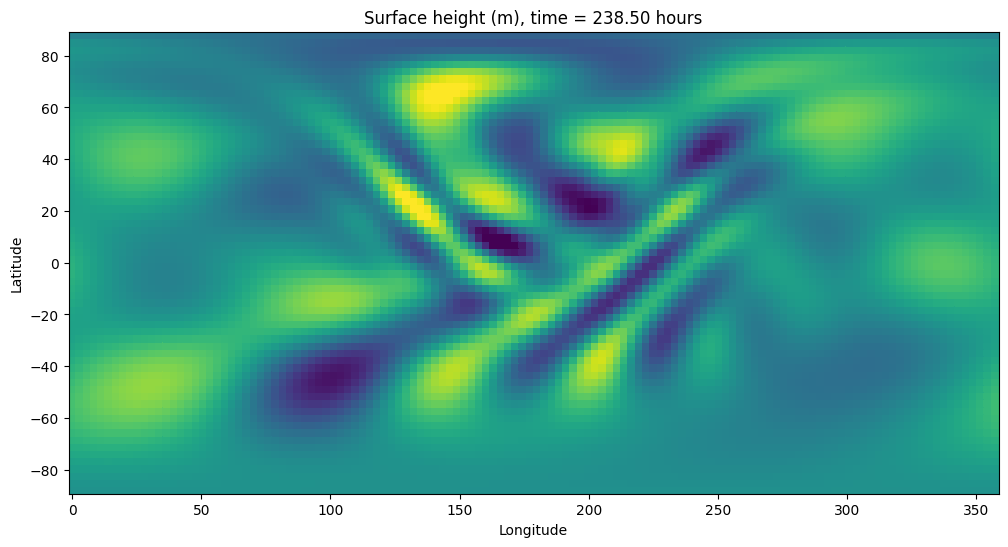

In [5]:
# create a figure and axes
fig = plt.figure(figsize=(12,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(np.pi/2 - theta)*360/2/np.pi, np.squeeze(phi)*360/2/np.pi)

# Define an animation function
def drawframe(n):
    plt.clf()
    height = plt.pcolor(Y, X, h_save[n,:,:], vmin=-0.1, vmax=0.1)
    # Specify the axis limits and labels
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Surface height (m), time = {0:.2f} hours'.format(t_save[n]/(1*hour)))
    return (height,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

### 3.3 Student investigation
<a id='section3pt3'></a>
Create a virtual tide gauge by sampling the height at a point at a latitude of 45ºN and longitude of 90ºW and plot the timeseries of the height at this point in the cells below. You should modifty the code to save the height more often so that you can clearly see the shape of the wave. Notice that as the waves propagate around the Earth, their shape changes. Discuss physical mechanisms that might cause the shape of the wave to change as the wave propagates.

In [6]:
print(h_save.shape)
#[t, phi, theta]

(145, 128, 64)


INFO:subsystems:Building subproblem matrices 1/63 (~2%) Elapsed: 0s, Remaining: 1s, Rate: 6.9e+01/s


2025-11-26 18:34:03,090 subsystems 0/1 INFO :: Building subproblem matrices 1/63 (~2%) Elapsed: 0s, Remaining: 1s, Rate: 6.9e+01/s


INFO:subsystems:Building subproblem matrices 7/63 (~11%) Elapsed: 0s, Remaining: 1s, Rate: 7.9e+01/s


2025-11-26 18:34:03,164 subsystems 0/1 INFO :: Building subproblem matrices 7/63 (~11%) Elapsed: 0s, Remaining: 1s, Rate: 7.9e+01/s


INFO:subsystems:Building subproblem matrices 14/63 (~22%) Elapsed: 0s, Remaining: 1s, Rate: 8.3e+01/s


2025-11-26 18:34:03,244 subsystems 0/1 INFO :: Building subproblem matrices 14/63 (~22%) Elapsed: 0s, Remaining: 1s, Rate: 8.3e+01/s


INFO:subsystems:Building subproblem matrices 21/63 (~33%) Elapsed: 0s, Remaining: 1s, Rate: 7.9e+01/s


2025-11-26 18:34:03,340 subsystems 0/1 INFO :: Building subproblem matrices 21/63 (~33%) Elapsed: 0s, Remaining: 1s, Rate: 7.9e+01/s


INFO:subsystems:Building subproblem matrices 28/63 (~44%) Elapsed: 0s, Remaining: 0s, Rate: 7.6e+01/s


2025-11-26 18:34:03,445 subsystems 0/1 INFO :: Building subproblem matrices 28/63 (~44%) Elapsed: 0s, Remaining: 0s, Rate: 7.6e+01/s


INFO:subsystems:Building subproblem matrices 35/63 (~56%) Elapsed: 0s, Remaining: 0s, Rate: 7.4e+01/s


2025-11-26 18:34:03,548 subsystems 0/1 INFO :: Building subproblem matrices 35/63 (~56%) Elapsed: 0s, Remaining: 0s, Rate: 7.4e+01/s


INFO:subsystems:Building subproblem matrices 42/63 (~67%) Elapsed: 1s, Remaining: 0s, Rate: 7.2e+01/s


2025-11-26 18:34:03,657 subsystems 0/1 INFO :: Building subproblem matrices 42/63 (~67%) Elapsed: 1s, Remaining: 0s, Rate: 7.2e+01/s


INFO:subsystems:Building subproblem matrices 49/63 (~78%) Elapsed: 1s, Remaining: 0s, Rate: 7.1e+01/s


2025-11-26 18:34:03,768 subsystems 0/1 INFO :: Building subproblem matrices 49/63 (~78%) Elapsed: 1s, Remaining: 0s, Rate: 7.1e+01/s


INFO:subsystems:Building subproblem matrices 56/63 (~89%) Elapsed: 1s, Remaining: 0s, Rate: 7.1e+01/s


2025-11-26 18:34:03,862 subsystems 0/1 INFO :: Building subproblem matrices 56/63 (~89%) Elapsed: 1s, Remaining: 0s, Rate: 7.1e+01/s


INFO:subsystems:Building subproblem matrices 63/63 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 7.4e+01/s


2025-11-26 18:34:03,924 subsystems 0/1 INFO :: Building subproblem matrices 63/63 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 7.4e+01/s


INFO:__main__:Starting main loop


2025-11-26 18:34:03,928 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=1.500000e+02, dt=1.500000e+02


2025-11-26 18:34:04,015 __main__ 0/1 INFO :: Iteration=1, Time=1.500000e+02, dt=1.500000e+02


INFO:__main__:Iteration=11, Time=1.650000e+03, dt=1.500000e+02


2025-11-26 18:34:04,318 __main__ 0/1 INFO :: Iteration=11, Time=1.650000e+03, dt=1.500000e+02


INFO:__main__:Iteration=21, Time=3.150000e+03, dt=1.500000e+02


2025-11-26 18:34:04,632 __main__ 0/1 INFO :: Iteration=21, Time=3.150000e+03, dt=1.500000e+02


INFO:__main__:Iteration=31, Time=4.650000e+03, dt=1.500000e+02


2025-11-26 18:34:04,915 __main__ 0/1 INFO :: Iteration=31, Time=4.650000e+03, dt=1.500000e+02


INFO:__main__:Iteration=41, Time=6.150000e+03, dt=1.500000e+02


2025-11-26 18:34:05,222 __main__ 0/1 INFO :: Iteration=41, Time=6.150000e+03, dt=1.500000e+02


INFO:__main__:Iteration=51, Time=7.650000e+03, dt=1.500000e+02


2025-11-26 18:34:05,524 __main__ 0/1 INFO :: Iteration=51, Time=7.650000e+03, dt=1.500000e+02


INFO:__main__:Iteration=61, Time=9.150000e+03, dt=1.500000e+02


2025-11-26 18:34:05,839 __main__ 0/1 INFO :: Iteration=61, Time=9.150000e+03, dt=1.500000e+02


INFO:__main__:Iteration=71, Time=1.065000e+04, dt=1.500000e+02


2025-11-26 18:34:06,129 __main__ 0/1 INFO :: Iteration=71, Time=1.065000e+04, dt=1.500000e+02


INFO:__main__:Iteration=81, Time=1.215000e+04, dt=1.500000e+02


2025-11-26 18:34:06,425 __main__ 0/1 INFO :: Iteration=81, Time=1.215000e+04, dt=1.500000e+02


INFO:__main__:Iteration=91, Time=1.365000e+04, dt=1.500000e+02


2025-11-26 18:34:06,732 __main__ 0/1 INFO :: Iteration=91, Time=1.365000e+04, dt=1.500000e+02


INFO:__main__:Iteration=101, Time=1.515000e+04, dt=1.500000e+02


2025-11-26 18:34:07,050 __main__ 0/1 INFO :: Iteration=101, Time=1.515000e+04, dt=1.500000e+02


INFO:__main__:Iteration=111, Time=1.665000e+04, dt=1.500000e+02


2025-11-26 18:34:07,362 __main__ 0/1 INFO :: Iteration=111, Time=1.665000e+04, dt=1.500000e+02


INFO:__main__:Iteration=121, Time=1.815000e+04, dt=1.500000e+02


2025-11-26 18:34:07,665 __main__ 0/1 INFO :: Iteration=121, Time=1.815000e+04, dt=1.500000e+02


INFO:__main__:Iteration=131, Time=1.965000e+04, dt=1.500000e+02


2025-11-26 18:34:07,990 __main__ 0/1 INFO :: Iteration=131, Time=1.965000e+04, dt=1.500000e+02


INFO:__main__:Iteration=141, Time=2.115000e+04, dt=1.500000e+02


2025-11-26 18:34:08,283 __main__ 0/1 INFO :: Iteration=141, Time=2.115000e+04, dt=1.500000e+02


INFO:__main__:Iteration=151, Time=2.265000e+04, dt=1.500000e+02


2025-11-26 18:34:08,587 __main__ 0/1 INFO :: Iteration=151, Time=2.265000e+04, dt=1.500000e+02


INFO:__main__:Iteration=161, Time=2.415000e+04, dt=1.500000e+02


2025-11-26 18:34:08,897 __main__ 0/1 INFO :: Iteration=161, Time=2.415000e+04, dt=1.500000e+02


INFO:__main__:Iteration=171, Time=2.565000e+04, dt=1.500000e+02


2025-11-26 18:34:09,197 __main__ 0/1 INFO :: Iteration=171, Time=2.565000e+04, dt=1.500000e+02


INFO:__main__:Iteration=181, Time=2.715000e+04, dt=1.500000e+02


2025-11-26 18:34:09,496 __main__ 0/1 INFO :: Iteration=181, Time=2.715000e+04, dt=1.500000e+02


INFO:__main__:Iteration=191, Time=2.865000e+04, dt=1.500000e+02


2025-11-26 18:34:09,806 __main__ 0/1 INFO :: Iteration=191, Time=2.865000e+04, dt=1.500000e+02


INFO:__main__:Iteration=201, Time=3.015000e+04, dt=1.500000e+02


2025-11-26 18:34:10,129 __main__ 0/1 INFO :: Iteration=201, Time=3.015000e+04, dt=1.500000e+02


INFO:__main__:Iteration=211, Time=3.165000e+04, dt=1.500000e+02


2025-11-26 18:34:10,430 __main__ 0/1 INFO :: Iteration=211, Time=3.165000e+04, dt=1.500000e+02


INFO:__main__:Iteration=221, Time=3.315000e+04, dt=1.500000e+02


2025-11-26 18:34:10,712 __main__ 0/1 INFO :: Iteration=221, Time=3.315000e+04, dt=1.500000e+02


INFO:__main__:Iteration=231, Time=3.465000e+04, dt=1.500000e+02


2025-11-26 18:34:11,016 __main__ 0/1 INFO :: Iteration=231, Time=3.465000e+04, dt=1.500000e+02


INFO:__main__:Iteration=241, Time=3.615000e+04, dt=1.500000e+02


2025-11-26 18:34:11,337 __main__ 0/1 INFO :: Iteration=241, Time=3.615000e+04, dt=1.500000e+02


INFO:__main__:Iteration=251, Time=3.765000e+04, dt=1.500000e+02


2025-11-26 18:34:11,643 __main__ 0/1 INFO :: Iteration=251, Time=3.765000e+04, dt=1.500000e+02


INFO:__main__:Iteration=261, Time=3.915000e+04, dt=1.500000e+02


2025-11-26 18:34:11,955 __main__ 0/1 INFO :: Iteration=261, Time=3.915000e+04, dt=1.500000e+02


INFO:__main__:Iteration=271, Time=4.065000e+04, dt=1.500000e+02


2025-11-26 18:34:12,253 __main__ 0/1 INFO :: Iteration=271, Time=4.065000e+04, dt=1.500000e+02


INFO:__main__:Iteration=281, Time=4.215000e+04, dt=1.500000e+02


2025-11-26 18:34:12,549 __main__ 0/1 INFO :: Iteration=281, Time=4.215000e+04, dt=1.500000e+02


INFO:__main__:Iteration=291, Time=4.365000e+04, dt=1.500000e+02


2025-11-26 18:34:12,844 __main__ 0/1 INFO :: Iteration=291, Time=4.365000e+04, dt=1.500000e+02


INFO:__main__:Iteration=301, Time=4.515000e+04, dt=1.500000e+02


2025-11-26 18:34:13,140 __main__ 0/1 INFO :: Iteration=301, Time=4.515000e+04, dt=1.500000e+02


INFO:__main__:Iteration=311, Time=4.665000e+04, dt=1.500000e+02


2025-11-26 18:34:13,444 __main__ 0/1 INFO :: Iteration=311, Time=4.665000e+04, dt=1.500000e+02


INFO:__main__:Iteration=321, Time=4.815000e+04, dt=1.500000e+02


2025-11-26 18:34:13,753 __main__ 0/1 INFO :: Iteration=321, Time=4.815000e+04, dt=1.500000e+02


INFO:__main__:Iteration=331, Time=4.965000e+04, dt=1.500000e+02


2025-11-26 18:34:14,209 __main__ 0/1 INFO :: Iteration=331, Time=4.965000e+04, dt=1.500000e+02


INFO:__main__:Iteration=341, Time=5.115000e+04, dt=1.500000e+02


2025-11-26 18:34:14,648 __main__ 0/1 INFO :: Iteration=341, Time=5.115000e+04, dt=1.500000e+02


INFO:__main__:Iteration=351, Time=5.265000e+04, dt=1.500000e+02


2025-11-26 18:34:15,160 __main__ 0/1 INFO :: Iteration=351, Time=5.265000e+04, dt=1.500000e+02


INFO:__main__:Iteration=361, Time=5.415000e+04, dt=1.500000e+02


2025-11-26 18:34:15,484 __main__ 0/1 INFO :: Iteration=361, Time=5.415000e+04, dt=1.500000e+02


INFO:__main__:Iteration=371, Time=5.565000e+04, dt=1.500000e+02


2025-11-26 18:34:15,787 __main__ 0/1 INFO :: Iteration=371, Time=5.565000e+04, dt=1.500000e+02


INFO:__main__:Iteration=381, Time=5.715000e+04, dt=1.500000e+02


2025-11-26 18:34:16,113 __main__ 0/1 INFO :: Iteration=381, Time=5.715000e+04, dt=1.500000e+02


INFO:__main__:Iteration=391, Time=5.865000e+04, dt=1.500000e+02


2025-11-26 18:34:16,426 __main__ 0/1 INFO :: Iteration=391, Time=5.865000e+04, dt=1.500000e+02


INFO:__main__:Iteration=401, Time=6.015000e+04, dt=1.500000e+02


2025-11-26 18:34:16,738 __main__ 0/1 INFO :: Iteration=401, Time=6.015000e+04, dt=1.500000e+02


INFO:__main__:Iteration=411, Time=6.165000e+04, dt=1.500000e+02


2025-11-26 18:34:17,053 __main__ 0/1 INFO :: Iteration=411, Time=6.165000e+04, dt=1.500000e+02


INFO:__main__:Iteration=421, Time=6.315000e+04, dt=1.500000e+02


2025-11-26 18:34:17,357 __main__ 0/1 INFO :: Iteration=421, Time=6.315000e+04, dt=1.500000e+02


INFO:__main__:Iteration=431, Time=6.465000e+04, dt=1.500000e+02


2025-11-26 18:34:17,657 __main__ 0/1 INFO :: Iteration=431, Time=6.465000e+04, dt=1.500000e+02


INFO:__main__:Iteration=441, Time=6.615000e+04, dt=1.500000e+02


2025-11-26 18:34:17,950 __main__ 0/1 INFO :: Iteration=441, Time=6.615000e+04, dt=1.500000e+02


INFO:__main__:Iteration=451, Time=6.765000e+04, dt=1.500000e+02


2025-11-26 18:34:18,256 __main__ 0/1 INFO :: Iteration=451, Time=6.765000e+04, dt=1.500000e+02


INFO:__main__:Iteration=461, Time=6.915000e+04, dt=1.500000e+02


2025-11-26 18:34:18,557 __main__ 0/1 INFO :: Iteration=461, Time=6.915000e+04, dt=1.500000e+02


INFO:__main__:Iteration=471, Time=7.065000e+04, dt=1.500000e+02


2025-11-26 18:34:18,848 __main__ 0/1 INFO :: Iteration=471, Time=7.065000e+04, dt=1.500000e+02


INFO:__main__:Iteration=481, Time=7.215000e+04, dt=1.500000e+02


2025-11-26 18:34:19,153 __main__ 0/1 INFO :: Iteration=481, Time=7.215000e+04, dt=1.500000e+02


INFO:__main__:Iteration=491, Time=7.365000e+04, dt=1.500000e+02


2025-11-26 18:34:19,459 __main__ 0/1 INFO :: Iteration=491, Time=7.365000e+04, dt=1.500000e+02


INFO:__main__:Iteration=501, Time=7.515000e+04, dt=1.500000e+02


2025-11-26 18:34:19,776 __main__ 0/1 INFO :: Iteration=501, Time=7.515000e+04, dt=1.500000e+02


INFO:__main__:Iteration=511, Time=7.665000e+04, dt=1.500000e+02


2025-11-26 18:34:20,089 __main__ 0/1 INFO :: Iteration=511, Time=7.665000e+04, dt=1.500000e+02


INFO:__main__:Iteration=521, Time=7.815000e+04, dt=1.500000e+02


2025-11-26 18:34:20,397 __main__ 0/1 INFO :: Iteration=521, Time=7.815000e+04, dt=1.500000e+02


INFO:__main__:Iteration=531, Time=7.965000e+04, dt=1.500000e+02


2025-11-26 18:34:20,696 __main__ 0/1 INFO :: Iteration=531, Time=7.965000e+04, dt=1.500000e+02


INFO:__main__:Iteration=541, Time=8.115000e+04, dt=1.500000e+02


2025-11-26 18:34:20,996 __main__ 0/1 INFO :: Iteration=541, Time=8.115000e+04, dt=1.500000e+02


INFO:__main__:Iteration=551, Time=8.265000e+04, dt=1.500000e+02


2025-11-26 18:34:21,321 __main__ 0/1 INFO :: Iteration=551, Time=8.265000e+04, dt=1.500000e+02


INFO:__main__:Iteration=561, Time=8.415000e+04, dt=1.500000e+02


2025-11-26 18:34:21,623 __main__ 0/1 INFO :: Iteration=561, Time=8.415000e+04, dt=1.500000e+02


INFO:__main__:Iteration=571, Time=8.565000e+04, dt=1.500000e+02


2025-11-26 18:34:21,924 __main__ 0/1 INFO :: Iteration=571, Time=8.565000e+04, dt=1.500000e+02


INFO:__main__:Iteration=581, Time=8.715000e+04, dt=1.500000e+02


2025-11-26 18:34:22,238 __main__ 0/1 INFO :: Iteration=581, Time=8.715000e+04, dt=1.500000e+02


INFO:__main__:Iteration=591, Time=8.865000e+04, dt=1.500000e+02


2025-11-26 18:34:22,529 __main__ 0/1 INFO :: Iteration=591, Time=8.865000e+04, dt=1.500000e+02


INFO:__main__:Iteration=601, Time=9.015000e+04, dt=1.500000e+02


2025-11-26 18:34:22,823 __main__ 0/1 INFO :: Iteration=601, Time=9.015000e+04, dt=1.500000e+02


INFO:__main__:Iteration=611, Time=9.165000e+04, dt=1.500000e+02


2025-11-26 18:34:23,121 __main__ 0/1 INFO :: Iteration=611, Time=9.165000e+04, dt=1.500000e+02


INFO:__main__:Iteration=621, Time=9.315000e+04, dt=1.500000e+02


2025-11-26 18:34:23,438 __main__ 0/1 INFO :: Iteration=621, Time=9.315000e+04, dt=1.500000e+02


INFO:__main__:Iteration=631, Time=9.465000e+04, dt=1.500000e+02


2025-11-26 18:34:23,761 __main__ 0/1 INFO :: Iteration=631, Time=9.465000e+04, dt=1.500000e+02


INFO:__main__:Iteration=641, Time=9.615000e+04, dt=1.500000e+02


2025-11-26 18:34:24,058 __main__ 0/1 INFO :: Iteration=641, Time=9.615000e+04, dt=1.500000e+02


INFO:__main__:Iteration=651, Time=9.765000e+04, dt=1.500000e+02


2025-11-26 18:34:24,384 __main__ 0/1 INFO :: Iteration=651, Time=9.765000e+04, dt=1.500000e+02


INFO:__main__:Iteration=661, Time=9.915000e+04, dt=1.500000e+02


2025-11-26 18:34:24,683 __main__ 0/1 INFO :: Iteration=661, Time=9.915000e+04, dt=1.500000e+02


INFO:__main__:Iteration=671, Time=1.006500e+05, dt=1.500000e+02


2025-11-26 18:34:24,981 __main__ 0/1 INFO :: Iteration=671, Time=1.006500e+05, dt=1.500000e+02


INFO:__main__:Iteration=681, Time=1.021500e+05, dt=1.500000e+02


2025-11-26 18:34:25,343 __main__ 0/1 INFO :: Iteration=681, Time=1.021500e+05, dt=1.500000e+02


INFO:__main__:Iteration=691, Time=1.036500e+05, dt=1.500000e+02


2025-11-26 18:34:25,786 __main__ 0/1 INFO :: Iteration=691, Time=1.036500e+05, dt=1.500000e+02


INFO:__main__:Iteration=701, Time=1.051500e+05, dt=1.500000e+02


2025-11-26 18:34:26,228 __main__ 0/1 INFO :: Iteration=701, Time=1.051500e+05, dt=1.500000e+02


INFO:__main__:Iteration=711, Time=1.066500e+05, dt=1.500000e+02


2025-11-26 18:34:26,672 __main__ 0/1 INFO :: Iteration=711, Time=1.066500e+05, dt=1.500000e+02


INFO:__main__:Iteration=721, Time=1.081500e+05, dt=1.500000e+02


2025-11-26 18:34:26,954 __main__ 0/1 INFO :: Iteration=721, Time=1.081500e+05, dt=1.500000e+02


INFO:__main__:Iteration=731, Time=1.096500e+05, dt=1.500000e+02


2025-11-26 18:34:27,250 __main__ 0/1 INFO :: Iteration=731, Time=1.096500e+05, dt=1.500000e+02


INFO:__main__:Iteration=741, Time=1.111500e+05, dt=1.500000e+02


2025-11-26 18:34:27,572 __main__ 0/1 INFO :: Iteration=741, Time=1.111500e+05, dt=1.500000e+02


INFO:__main__:Iteration=751, Time=1.126500e+05, dt=1.500000e+02


2025-11-26 18:34:27,882 __main__ 0/1 INFO :: Iteration=751, Time=1.126500e+05, dt=1.500000e+02


INFO:__main__:Iteration=761, Time=1.141500e+05, dt=1.500000e+02


2025-11-26 18:34:28,183 __main__ 0/1 INFO :: Iteration=761, Time=1.141500e+05, dt=1.500000e+02


INFO:__main__:Iteration=771, Time=1.156500e+05, dt=1.500000e+02


2025-11-26 18:34:28,491 __main__ 0/1 INFO :: Iteration=771, Time=1.156500e+05, dt=1.500000e+02


INFO:__main__:Iteration=781, Time=1.171500e+05, dt=1.500000e+02


2025-11-26 18:34:28,802 __main__ 0/1 INFO :: Iteration=781, Time=1.171500e+05, dt=1.500000e+02


INFO:__main__:Iteration=791, Time=1.186500e+05, dt=1.500000e+02


2025-11-26 18:34:29,128 __main__ 0/1 INFO :: Iteration=791, Time=1.186500e+05, dt=1.500000e+02


INFO:__main__:Iteration=801, Time=1.201500e+05, dt=1.500000e+02


2025-11-26 18:34:29,491 __main__ 0/1 INFO :: Iteration=801, Time=1.201500e+05, dt=1.500000e+02


INFO:__main__:Iteration=811, Time=1.216500e+05, dt=1.500000e+02


2025-11-26 18:34:29,799 __main__ 0/1 INFO :: Iteration=811, Time=1.216500e+05, dt=1.500000e+02


INFO:__main__:Iteration=821, Time=1.231500e+05, dt=1.500000e+02


2025-11-26 18:34:30,103 __main__ 0/1 INFO :: Iteration=821, Time=1.231500e+05, dt=1.500000e+02


INFO:__main__:Iteration=831, Time=1.246500e+05, dt=1.500000e+02


2025-11-26 18:34:30,430 __main__ 0/1 INFO :: Iteration=831, Time=1.246500e+05, dt=1.500000e+02


INFO:__main__:Iteration=841, Time=1.261500e+05, dt=1.500000e+02


2025-11-26 18:34:30,736 __main__ 0/1 INFO :: Iteration=841, Time=1.261500e+05, dt=1.500000e+02


INFO:__main__:Iteration=851, Time=1.276500e+05, dt=1.500000e+02


2025-11-26 18:34:31,038 __main__ 0/1 INFO :: Iteration=851, Time=1.276500e+05, dt=1.500000e+02


INFO:__main__:Iteration=861, Time=1.291500e+05, dt=1.500000e+02


2025-11-26 18:34:31,345 __main__ 0/1 INFO :: Iteration=861, Time=1.291500e+05, dt=1.500000e+02


INFO:__main__:Iteration=871, Time=1.306500e+05, dt=1.500000e+02


2025-11-26 18:34:31,658 __main__ 0/1 INFO :: Iteration=871, Time=1.306500e+05, dt=1.500000e+02


INFO:__main__:Iteration=881, Time=1.321500e+05, dt=1.500000e+02


2025-11-26 18:34:31,967 __main__ 0/1 INFO :: Iteration=881, Time=1.321500e+05, dt=1.500000e+02


INFO:__main__:Iteration=891, Time=1.336500e+05, dt=1.500000e+02


2025-11-26 18:34:32,284 __main__ 0/1 INFO :: Iteration=891, Time=1.336500e+05, dt=1.500000e+02


INFO:__main__:Iteration=901, Time=1.351500e+05, dt=1.500000e+02


2025-11-26 18:34:32,629 __main__ 0/1 INFO :: Iteration=901, Time=1.351500e+05, dt=1.500000e+02


INFO:__main__:Iteration=911, Time=1.366500e+05, dt=1.500000e+02


2025-11-26 18:34:32,935 __main__ 0/1 INFO :: Iteration=911, Time=1.366500e+05, dt=1.500000e+02


INFO:__main__:Iteration=921, Time=1.381500e+05, dt=1.500000e+02


2025-11-26 18:34:33,243 __main__ 0/1 INFO :: Iteration=921, Time=1.381500e+05, dt=1.500000e+02


INFO:__main__:Iteration=931, Time=1.396500e+05, dt=1.500000e+02


2025-11-26 18:34:33,581 __main__ 0/1 INFO :: Iteration=931, Time=1.396500e+05, dt=1.500000e+02


INFO:__main__:Iteration=941, Time=1.411500e+05, dt=1.500000e+02


2025-11-26 18:34:33,886 __main__ 0/1 INFO :: Iteration=941, Time=1.411500e+05, dt=1.500000e+02


INFO:__main__:Iteration=951, Time=1.426500e+05, dt=1.500000e+02


2025-11-26 18:34:34,193 __main__ 0/1 INFO :: Iteration=951, Time=1.426500e+05, dt=1.500000e+02


INFO:__main__:Iteration=961, Time=1.441500e+05, dt=1.500000e+02


2025-11-26 18:34:34,528 __main__ 0/1 INFO :: Iteration=961, Time=1.441500e+05, dt=1.500000e+02


INFO:__main__:Iteration=971, Time=1.456500e+05, dt=1.500000e+02


2025-11-26 18:34:34,838 __main__ 0/1 INFO :: Iteration=971, Time=1.456500e+05, dt=1.500000e+02


INFO:__main__:Iteration=981, Time=1.471500e+05, dt=1.500000e+02


2025-11-26 18:34:35,137 __main__ 0/1 INFO :: Iteration=981, Time=1.471500e+05, dt=1.500000e+02


INFO:__main__:Iteration=991, Time=1.486500e+05, dt=1.500000e+02


2025-11-26 18:34:35,441 __main__ 0/1 INFO :: Iteration=991, Time=1.486500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1001, Time=1.501500e+05, dt=1.500000e+02


2025-11-26 18:34:35,762 __main__ 0/1 INFO :: Iteration=1001, Time=1.501500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1011, Time=1.516500e+05, dt=1.500000e+02


2025-11-26 18:34:36,070 __main__ 0/1 INFO :: Iteration=1011, Time=1.516500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1021, Time=1.531500e+05, dt=1.500000e+02


2025-11-26 18:34:36,375 __main__ 0/1 INFO :: Iteration=1021, Time=1.531500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1031, Time=1.546500e+05, dt=1.500000e+02


2025-11-26 18:34:36,773 __main__ 0/1 INFO :: Iteration=1031, Time=1.546500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1041, Time=1.561500e+05, dt=1.500000e+02


2025-11-26 18:34:37,231 __main__ 0/1 INFO :: Iteration=1041, Time=1.561500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1051, Time=1.576500e+05, dt=1.500000e+02


2025-11-26 18:34:37,720 __main__ 0/1 INFO :: Iteration=1051, Time=1.576500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1061, Time=1.591500e+05, dt=1.500000e+02


2025-11-26 18:34:38,118 __main__ 0/1 INFO :: Iteration=1061, Time=1.591500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1071, Time=1.606500e+05, dt=1.500000e+02


2025-11-26 18:34:38,418 __main__ 0/1 INFO :: Iteration=1071, Time=1.606500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1081, Time=1.621500e+05, dt=1.500000e+02


2025-11-26 18:34:38,726 __main__ 0/1 INFO :: Iteration=1081, Time=1.621500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1091, Time=1.636500e+05, dt=1.500000e+02


2025-11-26 18:34:39,036 __main__ 0/1 INFO :: Iteration=1091, Time=1.636500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1101, Time=1.651500e+05, dt=1.500000e+02


2025-11-26 18:34:39,349 __main__ 0/1 INFO :: Iteration=1101, Time=1.651500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1111, Time=1.666500e+05, dt=1.500000e+02


2025-11-26 18:34:39,664 __main__ 0/1 INFO :: Iteration=1111, Time=1.666500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1121, Time=1.681500e+05, dt=1.500000e+02


2025-11-26 18:34:39,959 __main__ 0/1 INFO :: Iteration=1121, Time=1.681500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1131, Time=1.696500e+05, dt=1.500000e+02


2025-11-26 18:34:40,269 __main__ 0/1 INFO :: Iteration=1131, Time=1.696500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1141, Time=1.711500e+05, dt=1.500000e+02


2025-11-26 18:34:40,590 __main__ 0/1 INFO :: Iteration=1141, Time=1.711500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1151, Time=1.726500e+05, dt=1.500000e+02


2025-11-26 18:34:40,894 __main__ 0/1 INFO :: Iteration=1151, Time=1.726500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1161, Time=1.741500e+05, dt=1.500000e+02


2025-11-26 18:34:41,199 __main__ 0/1 INFO :: Iteration=1161, Time=1.741500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1171, Time=1.756500e+05, dt=1.500000e+02


2025-11-26 18:34:41,508 __main__ 0/1 INFO :: Iteration=1171, Time=1.756500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1181, Time=1.771500e+05, dt=1.500000e+02


2025-11-26 18:34:41,838 __main__ 0/1 INFO :: Iteration=1181, Time=1.771500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1191, Time=1.786500e+05, dt=1.500000e+02


2025-11-26 18:34:42,142 __main__ 0/1 INFO :: Iteration=1191, Time=1.786500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1201, Time=1.801500e+05, dt=1.500000e+02


2025-11-26 18:34:42,476 __main__ 0/1 INFO :: Iteration=1201, Time=1.801500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1211, Time=1.816500e+05, dt=1.500000e+02


2025-11-26 18:34:42,808 __main__ 0/1 INFO :: Iteration=1211, Time=1.816500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1221, Time=1.831500e+05, dt=1.500000e+02


2025-11-26 18:34:43,102 __main__ 0/1 INFO :: Iteration=1221, Time=1.831500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1231, Time=1.846500e+05, dt=1.500000e+02


2025-11-26 18:34:43,411 __main__ 0/1 INFO :: Iteration=1231, Time=1.846500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1241, Time=1.861500e+05, dt=1.500000e+02


2025-11-26 18:34:43,710 __main__ 0/1 INFO :: Iteration=1241, Time=1.861500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1251, Time=1.876500e+05, dt=1.500000e+02


2025-11-26 18:34:44,027 __main__ 0/1 INFO :: Iteration=1251, Time=1.876500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1261, Time=1.891500e+05, dt=1.500000e+02


2025-11-26 18:34:44,345 __main__ 0/1 INFO :: Iteration=1261, Time=1.891500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1271, Time=1.906500e+05, dt=1.500000e+02


2025-11-26 18:34:44,655 __main__ 0/1 INFO :: Iteration=1271, Time=1.906500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1281, Time=1.921500e+05, dt=1.500000e+02


2025-11-26 18:34:44,987 __main__ 0/1 INFO :: Iteration=1281, Time=1.921500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1291, Time=1.936500e+05, dt=1.500000e+02


2025-11-26 18:34:45,293 __main__ 0/1 INFO :: Iteration=1291, Time=1.936500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1301, Time=1.951500e+05, dt=1.500000e+02


2025-11-26 18:34:45,604 __main__ 0/1 INFO :: Iteration=1301, Time=1.951500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1311, Time=1.966500e+05, dt=1.500000e+02


2025-11-26 18:34:45,920 __main__ 0/1 INFO :: Iteration=1311, Time=1.966500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1321, Time=1.981500e+05, dt=1.500000e+02


2025-11-26 18:34:46,229 __main__ 0/1 INFO :: Iteration=1321, Time=1.981500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1331, Time=1.996500e+05, dt=1.500000e+02


2025-11-26 18:34:46,526 __main__ 0/1 INFO :: Iteration=1331, Time=1.996500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1341, Time=2.011500e+05, dt=1.500000e+02


2025-11-26 18:34:46,830 __main__ 0/1 INFO :: Iteration=1341, Time=2.011500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1351, Time=2.026500e+05, dt=1.500000e+02


2025-11-26 18:34:47,122 __main__ 0/1 INFO :: Iteration=1351, Time=2.026500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1361, Time=2.041500e+05, dt=1.500000e+02


2025-11-26 18:34:47,431 __main__ 0/1 INFO :: Iteration=1361, Time=2.041500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1371, Time=2.056500e+05, dt=1.500000e+02


2025-11-26 18:34:47,732 __main__ 0/1 INFO :: Iteration=1371, Time=2.056500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1381, Time=2.071500e+05, dt=1.500000e+02


2025-11-26 18:34:48,100 __main__ 0/1 INFO :: Iteration=1381, Time=2.071500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1391, Time=2.086500e+05, dt=1.500000e+02


2025-11-26 18:34:48,563 __main__ 0/1 INFO :: Iteration=1391, Time=2.086500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1401, Time=2.101500e+05, dt=1.500000e+02


2025-11-26 18:34:49,014 __main__ 0/1 INFO :: Iteration=1401, Time=2.101500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1411, Time=2.116500e+05, dt=1.500000e+02


2025-11-26 18:34:49,432 __main__ 0/1 INFO :: Iteration=1411, Time=2.116500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1421, Time=2.131500e+05, dt=1.500000e+02


2025-11-26 18:34:49,750 __main__ 0/1 INFO :: Iteration=1421, Time=2.131500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1431, Time=2.146500e+05, dt=1.500000e+02


2025-11-26 18:34:50,060 __main__ 0/1 INFO :: Iteration=1431, Time=2.146500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1441, Time=2.161500e+05, dt=1.500000e+02


2025-11-26 18:34:50,368 __main__ 0/1 INFO :: Iteration=1441, Time=2.161500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1451, Time=2.176500e+05, dt=1.500000e+02


2025-11-26 18:34:50,670 __main__ 0/1 INFO :: Iteration=1451, Time=2.176500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1461, Time=2.191500e+05, dt=1.500000e+02


2025-11-26 18:34:50,978 __main__ 0/1 INFO :: Iteration=1461, Time=2.191500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1471, Time=2.206500e+05, dt=1.500000e+02


2025-11-26 18:34:51,280 __main__ 0/1 INFO :: Iteration=1471, Time=2.206500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1481, Time=2.221500e+05, dt=1.500000e+02


2025-11-26 18:34:51,589 __main__ 0/1 INFO :: Iteration=1481, Time=2.221500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1491, Time=2.236500e+05, dt=1.500000e+02


2025-11-26 18:34:51,886 __main__ 0/1 INFO :: Iteration=1491, Time=2.236500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1501, Time=2.251500e+05, dt=1.500000e+02


2025-11-26 18:34:52,191 __main__ 0/1 INFO :: Iteration=1501, Time=2.251500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1511, Time=2.266500e+05, dt=1.500000e+02


2025-11-26 18:34:52,488 __main__ 0/1 INFO :: Iteration=1511, Time=2.266500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1521, Time=2.281500e+05, dt=1.500000e+02


2025-11-26 18:34:52,784 __main__ 0/1 INFO :: Iteration=1521, Time=2.281500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1531, Time=2.296500e+05, dt=1.500000e+02


2025-11-26 18:34:53,110 __main__ 0/1 INFO :: Iteration=1531, Time=2.296500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1541, Time=2.311500e+05, dt=1.500000e+02


2025-11-26 18:34:53,408 __main__ 0/1 INFO :: Iteration=1541, Time=2.311500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1551, Time=2.326500e+05, dt=1.500000e+02


2025-11-26 18:34:53,715 __main__ 0/1 INFO :: Iteration=1551, Time=2.326500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1561, Time=2.341500e+05, dt=1.500000e+02


2025-11-26 18:34:54,022 __main__ 0/1 INFO :: Iteration=1561, Time=2.341500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1571, Time=2.356500e+05, dt=1.500000e+02


2025-11-26 18:34:54,332 __main__ 0/1 INFO :: Iteration=1571, Time=2.356500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1581, Time=2.371500e+05, dt=1.500000e+02


2025-11-26 18:34:54,634 __main__ 0/1 INFO :: Iteration=1581, Time=2.371500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1591, Time=2.386500e+05, dt=1.500000e+02


2025-11-26 18:34:54,940 __main__ 0/1 INFO :: Iteration=1591, Time=2.386500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1601, Time=2.401500e+05, dt=1.500000e+02


2025-11-26 18:34:55,286 __main__ 0/1 INFO :: Iteration=1601, Time=2.401500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1611, Time=2.416500e+05, dt=1.500000e+02


2025-11-26 18:34:55,619 __main__ 0/1 INFO :: Iteration=1611, Time=2.416500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1621, Time=2.431500e+05, dt=1.500000e+02


2025-11-26 18:34:55,919 __main__ 0/1 INFO :: Iteration=1621, Time=2.431500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1631, Time=2.446500e+05, dt=1.500000e+02


2025-11-26 18:34:56,225 __main__ 0/1 INFO :: Iteration=1631, Time=2.446500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1641, Time=2.461500e+05, dt=1.500000e+02


2025-11-26 18:34:56,529 __main__ 0/1 INFO :: Iteration=1641, Time=2.461500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1651, Time=2.476500e+05, dt=1.500000e+02


2025-11-26 18:34:56,838 __main__ 0/1 INFO :: Iteration=1651, Time=2.476500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1661, Time=2.491500e+05, dt=1.500000e+02


2025-11-26 18:34:57,156 __main__ 0/1 INFO :: Iteration=1661, Time=2.491500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1671, Time=2.506500e+05, dt=1.500000e+02


2025-11-26 18:34:57,464 __main__ 0/1 INFO :: Iteration=1671, Time=2.506500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1681, Time=2.521500e+05, dt=1.500000e+02


2025-11-26 18:34:57,777 __main__ 0/1 INFO :: Iteration=1681, Time=2.521500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1691, Time=2.536500e+05, dt=1.500000e+02


2025-11-26 18:34:58,097 __main__ 0/1 INFO :: Iteration=1691, Time=2.536500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1701, Time=2.551500e+05, dt=1.500000e+02


2025-11-26 18:34:58,413 __main__ 0/1 INFO :: Iteration=1701, Time=2.551500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1711, Time=2.566500e+05, dt=1.500000e+02


2025-11-26 18:34:58,714 __main__ 0/1 INFO :: Iteration=1711, Time=2.566500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1721, Time=2.581500e+05, dt=1.500000e+02


2025-11-26 18:34:59,012 __main__ 0/1 INFO :: Iteration=1721, Time=2.581500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1731, Time=2.596500e+05, dt=1.500000e+02


2025-11-26 18:34:59,366 __main__ 0/1 INFO :: Iteration=1731, Time=2.596500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1741, Time=2.611500e+05, dt=1.500000e+02


2025-11-26 18:34:59,836 __main__ 0/1 INFO :: Iteration=1741, Time=2.611500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1751, Time=2.626500e+05, dt=1.500000e+02


2025-11-26 18:35:00,310 __main__ 0/1 INFO :: Iteration=1751, Time=2.626500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1761, Time=2.641500e+05, dt=1.500000e+02


2025-11-26 18:35:00,852 __main__ 0/1 INFO :: Iteration=1761, Time=2.641500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1771, Time=2.656500e+05, dt=1.500000e+02


2025-11-26 18:35:01,246 __main__ 0/1 INFO :: Iteration=1771, Time=2.656500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1781, Time=2.671500e+05, dt=1.500000e+02


2025-11-26 18:35:01,658 __main__ 0/1 INFO :: Iteration=1781, Time=2.671500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1791, Time=2.686500e+05, dt=1.500000e+02


2025-11-26 18:35:02,070 __main__ 0/1 INFO :: Iteration=1791, Time=2.686500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1801, Time=2.701500e+05, dt=1.500000e+02


2025-11-26 18:35:02,531 __main__ 0/1 INFO :: Iteration=1801, Time=2.701500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1811, Time=2.716500e+05, dt=1.500000e+02


2025-11-26 18:35:02,984 __main__ 0/1 INFO :: Iteration=1811, Time=2.716500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1821, Time=2.731500e+05, dt=1.500000e+02


2025-11-26 18:35:03,426 __main__ 0/1 INFO :: Iteration=1821, Time=2.731500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1831, Time=2.746500e+05, dt=1.500000e+02


2025-11-26 18:35:03,830 __main__ 0/1 INFO :: Iteration=1831, Time=2.746500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1841, Time=2.761500e+05, dt=1.500000e+02


2025-11-26 18:35:04,253 __main__ 0/1 INFO :: Iteration=1841, Time=2.761500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1851, Time=2.776500e+05, dt=1.500000e+02


2025-11-26 18:35:04,775 __main__ 0/1 INFO :: Iteration=1851, Time=2.776500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1861, Time=2.791500e+05, dt=1.500000e+02


2025-11-26 18:35:05,272 __main__ 0/1 INFO :: Iteration=1861, Time=2.791500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1871, Time=2.806500e+05, dt=1.500000e+02


2025-11-26 18:35:05,672 __main__ 0/1 INFO :: Iteration=1871, Time=2.806500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1881, Time=2.821500e+05, dt=1.500000e+02


2025-11-26 18:35:05,988 __main__ 0/1 INFO :: Iteration=1881, Time=2.821500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1891, Time=2.836500e+05, dt=1.500000e+02


2025-11-26 18:35:06,351 __main__ 0/1 INFO :: Iteration=1891, Time=2.836500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1901, Time=2.851500e+05, dt=1.500000e+02


2025-11-26 18:35:06,748 __main__ 0/1 INFO :: Iteration=1901, Time=2.851500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1911, Time=2.866500e+05, dt=1.500000e+02


2025-11-26 18:35:07,126 __main__ 0/1 INFO :: Iteration=1911, Time=2.866500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1921, Time=2.881500e+05, dt=1.500000e+02


2025-11-26 18:35:07,490 __main__ 0/1 INFO :: Iteration=1921, Time=2.881500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1931, Time=2.896500e+05, dt=1.500000e+02


2025-11-26 18:35:07,875 __main__ 0/1 INFO :: Iteration=1931, Time=2.896500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1941, Time=2.911500e+05, dt=1.500000e+02


2025-11-26 18:35:08,247 __main__ 0/1 INFO :: Iteration=1941, Time=2.911500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1951, Time=2.926500e+05, dt=1.500000e+02


2025-11-26 18:35:08,563 __main__ 0/1 INFO :: Iteration=1951, Time=2.926500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1961, Time=2.941500e+05, dt=1.500000e+02


2025-11-26 18:35:08,889 __main__ 0/1 INFO :: Iteration=1961, Time=2.941500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1971, Time=2.956500e+05, dt=1.500000e+02


2025-11-26 18:35:09,203 __main__ 0/1 INFO :: Iteration=1971, Time=2.956500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1981, Time=2.971500e+05, dt=1.500000e+02


2025-11-26 18:35:09,518 __main__ 0/1 INFO :: Iteration=1981, Time=2.971500e+05, dt=1.500000e+02


INFO:__main__:Iteration=1991, Time=2.986500e+05, dt=1.500000e+02


2025-11-26 18:35:09,847 __main__ 0/1 INFO :: Iteration=1991, Time=2.986500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2001, Time=3.001500e+05, dt=1.500000e+02


2025-11-26 18:35:10,168 __main__ 0/1 INFO :: Iteration=2001, Time=3.001500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2011, Time=3.016500e+05, dt=1.500000e+02


2025-11-26 18:35:10,491 __main__ 0/1 INFO :: Iteration=2011, Time=3.016500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2021, Time=3.031500e+05, dt=1.500000e+02


2025-11-26 18:35:10,932 __main__ 0/1 INFO :: Iteration=2021, Time=3.031500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2031, Time=3.046500e+05, dt=1.500000e+02


2025-11-26 18:35:11,448 __main__ 0/1 INFO :: Iteration=2031, Time=3.046500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2041, Time=3.061500e+05, dt=1.500000e+02


2025-11-26 18:35:11,919 __main__ 0/1 INFO :: Iteration=2041, Time=3.061500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2051, Time=3.076500e+05, dt=1.500000e+02


2025-11-26 18:35:12,466 __main__ 0/1 INFO :: Iteration=2051, Time=3.076500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2061, Time=3.091500e+05, dt=1.500000e+02


2025-11-26 18:35:12,849 __main__ 0/1 INFO :: Iteration=2061, Time=3.091500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2071, Time=3.106500e+05, dt=1.500000e+02


2025-11-26 18:35:13,208 __main__ 0/1 INFO :: Iteration=2071, Time=3.106500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2081, Time=3.121500e+05, dt=1.500000e+02


2025-11-26 18:35:13,568 __main__ 0/1 INFO :: Iteration=2081, Time=3.121500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2091, Time=3.136500e+05, dt=1.500000e+02


2025-11-26 18:35:13,954 __main__ 0/1 INFO :: Iteration=2091, Time=3.136500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2101, Time=3.151500e+05, dt=1.500000e+02


2025-11-26 18:35:14,315 __main__ 0/1 INFO :: Iteration=2101, Time=3.151500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2111, Time=3.166500e+05, dt=1.500000e+02


2025-11-26 18:35:14,640 __main__ 0/1 INFO :: Iteration=2111, Time=3.166500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2121, Time=3.181500e+05, dt=1.500000e+02


2025-11-26 18:35:14,971 __main__ 0/1 INFO :: Iteration=2121, Time=3.181500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2131, Time=3.196500e+05, dt=1.500000e+02


2025-11-26 18:35:15,279 __main__ 0/1 INFO :: Iteration=2131, Time=3.196500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2141, Time=3.211500e+05, dt=1.500000e+02


2025-11-26 18:35:15,587 __main__ 0/1 INFO :: Iteration=2141, Time=3.211500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2151, Time=3.226500e+05, dt=1.500000e+02


2025-11-26 18:35:15,902 __main__ 0/1 INFO :: Iteration=2151, Time=3.226500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2161, Time=3.241500e+05, dt=1.500000e+02


2025-11-26 18:35:16,226 __main__ 0/1 INFO :: Iteration=2161, Time=3.241500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2171, Time=3.256500e+05, dt=1.500000e+02


2025-11-26 18:35:16,542 __main__ 0/1 INFO :: Iteration=2171, Time=3.256500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2181, Time=3.271500e+05, dt=1.500000e+02


2025-11-26 18:35:16,858 __main__ 0/1 INFO :: Iteration=2181, Time=3.271500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2191, Time=3.286500e+05, dt=1.500000e+02


2025-11-26 18:35:17,195 __main__ 0/1 INFO :: Iteration=2191, Time=3.286500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2201, Time=3.301500e+05, dt=1.500000e+02


2025-11-26 18:35:17,548 __main__ 0/1 INFO :: Iteration=2201, Time=3.301500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2211, Time=3.316500e+05, dt=1.500000e+02


2025-11-26 18:35:17,925 __main__ 0/1 INFO :: Iteration=2211, Time=3.316500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2221, Time=3.331500e+05, dt=1.500000e+02


2025-11-26 18:35:18,332 __main__ 0/1 INFO :: Iteration=2221, Time=3.331500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2231, Time=3.346500e+05, dt=1.500000e+02


2025-11-26 18:35:18,698 __main__ 0/1 INFO :: Iteration=2231, Time=3.346500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2241, Time=3.361500e+05, dt=1.500000e+02


2025-11-26 18:35:19,071 __main__ 0/1 INFO :: Iteration=2241, Time=3.361500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2251, Time=3.376500e+05, dt=1.500000e+02


2025-11-26 18:35:19,430 __main__ 0/1 INFO :: Iteration=2251, Time=3.376500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2261, Time=3.391500e+05, dt=1.500000e+02


2025-11-26 18:35:19,779 __main__ 0/1 INFO :: Iteration=2261, Time=3.391500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2271, Time=3.406500e+05, dt=1.500000e+02


2025-11-26 18:35:20,111 __main__ 0/1 INFO :: Iteration=2271, Time=3.406500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2281, Time=3.421500e+05, dt=1.500000e+02


2025-11-26 18:35:20,424 __main__ 0/1 INFO :: Iteration=2281, Time=3.421500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2291, Time=3.436500e+05, dt=1.500000e+02


2025-11-26 18:35:20,732 __main__ 0/1 INFO :: Iteration=2291, Time=3.436500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2301, Time=3.451500e+05, dt=1.500000e+02


2025-11-26 18:35:21,067 __main__ 0/1 INFO :: Iteration=2301, Time=3.451500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2311, Time=3.466500e+05, dt=1.500000e+02


2025-11-26 18:35:21,366 __main__ 0/1 INFO :: Iteration=2311, Time=3.466500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2321, Time=3.481500e+05, dt=1.500000e+02


2025-11-26 18:35:21,671 __main__ 0/1 INFO :: Iteration=2321, Time=3.481500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2331, Time=3.496500e+05, dt=1.500000e+02


2025-11-26 18:35:21,974 __main__ 0/1 INFO :: Iteration=2331, Time=3.496500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2341, Time=3.511500e+05, dt=1.500000e+02


2025-11-26 18:35:22,295 __main__ 0/1 INFO :: Iteration=2341, Time=3.511500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2351, Time=3.526500e+05, dt=1.500000e+02


2025-11-26 18:35:22,735 __main__ 0/1 INFO :: Iteration=2351, Time=3.526500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2361, Time=3.541500e+05, dt=1.500000e+02


2025-11-26 18:35:23,190 __main__ 0/1 INFO :: Iteration=2361, Time=3.541500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2371, Time=3.556500e+05, dt=1.500000e+02


2025-11-26 18:35:23,691 __main__ 0/1 INFO :: Iteration=2371, Time=3.556500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2381, Time=3.571500e+05, dt=1.500000e+02


2025-11-26 18:35:24,060 __main__ 0/1 INFO :: Iteration=2381, Time=3.571500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2391, Time=3.586500e+05, dt=1.500000e+02


2025-11-26 18:35:24,407 __main__ 0/1 INFO :: Iteration=2391, Time=3.586500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2401, Time=3.601500e+05, dt=1.500000e+02


2025-11-26 18:35:24,759 __main__ 0/1 INFO :: Iteration=2401, Time=3.601500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2411, Time=3.616500e+05, dt=1.500000e+02


2025-11-26 18:35:25,124 __main__ 0/1 INFO :: Iteration=2411, Time=3.616500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2421, Time=3.631500e+05, dt=1.500000e+02


2025-11-26 18:35:25,518 __main__ 0/1 INFO :: Iteration=2421, Time=3.631500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2431, Time=3.646500e+05, dt=1.500000e+02


2025-11-26 18:35:25,849 __main__ 0/1 INFO :: Iteration=2431, Time=3.646500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2441, Time=3.661500e+05, dt=1.500000e+02


2025-11-26 18:35:26,162 __main__ 0/1 INFO :: Iteration=2441, Time=3.661500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2451, Time=3.676500e+05, dt=1.500000e+02


2025-11-26 18:35:26,498 __main__ 0/1 INFO :: Iteration=2451, Time=3.676500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2461, Time=3.691500e+05, dt=1.500000e+02


2025-11-26 18:35:26,814 __main__ 0/1 INFO :: Iteration=2461, Time=3.691500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2471, Time=3.706500e+05, dt=1.500000e+02


2025-11-26 18:35:27,107 __main__ 0/1 INFO :: Iteration=2471, Time=3.706500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2481, Time=3.721500e+05, dt=1.500000e+02


2025-11-26 18:35:27,433 __main__ 0/1 INFO :: Iteration=2481, Time=3.721500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2491, Time=3.736500e+05, dt=1.500000e+02


2025-11-26 18:35:27,759 __main__ 0/1 INFO :: Iteration=2491, Time=3.736500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2501, Time=3.751500e+05, dt=1.500000e+02


2025-11-26 18:35:28,132 __main__ 0/1 INFO :: Iteration=2501, Time=3.751500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2511, Time=3.766500e+05, dt=1.500000e+02


2025-11-26 18:35:28,519 __main__ 0/1 INFO :: Iteration=2511, Time=3.766500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2521, Time=3.781500e+05, dt=1.500000e+02


2025-11-26 18:35:28,861 __main__ 0/1 INFO :: Iteration=2521, Time=3.781500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2531, Time=3.796500e+05, dt=1.500000e+02


2025-11-26 18:35:29,193 __main__ 0/1 INFO :: Iteration=2531, Time=3.796500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2541, Time=3.811500e+05, dt=1.500000e+02


2025-11-26 18:35:29,526 __main__ 0/1 INFO :: Iteration=2541, Time=3.811500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2551, Time=3.826500e+05, dt=1.500000e+02


2025-11-26 18:35:29,848 __main__ 0/1 INFO :: Iteration=2551, Time=3.826500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2561, Time=3.841500e+05, dt=1.500000e+02


2025-11-26 18:35:30,166 __main__ 0/1 INFO :: Iteration=2561, Time=3.841500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2571, Time=3.856500e+05, dt=1.500000e+02


2025-11-26 18:35:30,488 __main__ 0/1 INFO :: Iteration=2571, Time=3.856500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2581, Time=3.871500e+05, dt=1.500000e+02


2025-11-26 18:35:30,804 __main__ 0/1 INFO :: Iteration=2581, Time=3.871500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2591, Time=3.886500e+05, dt=1.500000e+02


2025-11-26 18:35:31,117 __main__ 0/1 INFO :: Iteration=2591, Time=3.886500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2601, Time=3.901500e+05, dt=1.500000e+02


2025-11-26 18:35:31,445 __main__ 0/1 INFO :: Iteration=2601, Time=3.901500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2611, Time=3.916500e+05, dt=1.500000e+02


2025-11-26 18:35:31,764 __main__ 0/1 INFO :: Iteration=2611, Time=3.916500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2621, Time=3.931500e+05, dt=1.500000e+02


2025-11-26 18:35:32,075 __main__ 0/1 INFO :: Iteration=2621, Time=3.931500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2631, Time=3.946500e+05, dt=1.500000e+02


2025-11-26 18:35:32,405 __main__ 0/1 INFO :: Iteration=2631, Time=3.946500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2641, Time=3.961500e+05, dt=1.500000e+02


2025-11-26 18:35:32,704 __main__ 0/1 INFO :: Iteration=2641, Time=3.961500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2651, Time=3.976500e+05, dt=1.500000e+02


2025-11-26 18:35:33,068 __main__ 0/1 INFO :: Iteration=2651, Time=3.976500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2661, Time=3.991500e+05, dt=1.500000e+02


2025-11-26 18:35:33,446 __main__ 0/1 INFO :: Iteration=2661, Time=3.991500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2671, Time=4.006500e+05, dt=1.500000e+02


2025-11-26 18:35:33,818 __main__ 0/1 INFO :: Iteration=2671, Time=4.006500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2681, Time=4.021500e+05, dt=1.500000e+02


2025-11-26 18:35:34,302 __main__ 0/1 INFO :: Iteration=2681, Time=4.021500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2691, Time=4.036500e+05, dt=1.500000e+02


2025-11-26 18:35:34,756 __main__ 0/1 INFO :: Iteration=2691, Time=4.036500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2701, Time=4.051500e+05, dt=1.500000e+02


2025-11-26 18:35:35,270 __main__ 0/1 INFO :: Iteration=2701, Time=4.051500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2711, Time=4.066500e+05, dt=1.500000e+02


2025-11-26 18:35:35,585 __main__ 0/1 INFO :: Iteration=2711, Time=4.066500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2721, Time=4.081500e+05, dt=1.500000e+02


2025-11-26 18:35:35,880 __main__ 0/1 INFO :: Iteration=2721, Time=4.081500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2731, Time=4.096500e+05, dt=1.500000e+02


2025-11-26 18:35:36,182 __main__ 0/1 INFO :: Iteration=2731, Time=4.096500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2741, Time=4.111500e+05, dt=1.500000e+02


2025-11-26 18:35:36,503 __main__ 0/1 INFO :: Iteration=2741, Time=4.111500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2751, Time=4.126500e+05, dt=1.500000e+02


2025-11-26 18:35:36,836 __main__ 0/1 INFO :: Iteration=2751, Time=4.126500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2761, Time=4.141500e+05, dt=1.500000e+02


2025-11-26 18:35:37,157 __main__ 0/1 INFO :: Iteration=2761, Time=4.141500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2771, Time=4.156500e+05, dt=1.500000e+02


2025-11-26 18:35:37,476 __main__ 0/1 INFO :: Iteration=2771, Time=4.156500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2781, Time=4.171500e+05, dt=1.500000e+02


2025-11-26 18:35:37,818 __main__ 0/1 INFO :: Iteration=2781, Time=4.171500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2791, Time=4.186500e+05, dt=1.500000e+02


2025-11-26 18:35:38,189 __main__ 0/1 INFO :: Iteration=2791, Time=4.186500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2801, Time=4.201500e+05, dt=1.500000e+02


2025-11-26 18:35:38,573 __main__ 0/1 INFO :: Iteration=2801, Time=4.201500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2811, Time=4.216500e+05, dt=1.500000e+02


2025-11-26 18:35:38,956 __main__ 0/1 INFO :: Iteration=2811, Time=4.216500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2821, Time=4.231500e+05, dt=1.500000e+02


2025-11-26 18:35:39,300 __main__ 0/1 INFO :: Iteration=2821, Time=4.231500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2831, Time=4.246500e+05, dt=1.500000e+02


2025-11-26 18:35:39,643 __main__ 0/1 INFO :: Iteration=2831, Time=4.246500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2841, Time=4.261500e+05, dt=1.500000e+02


2025-11-26 18:35:39,964 __main__ 0/1 INFO :: Iteration=2841, Time=4.261500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2851, Time=4.276500e+05, dt=1.500000e+02


2025-11-26 18:35:40,284 __main__ 0/1 INFO :: Iteration=2851, Time=4.276500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2861, Time=4.291500e+05, dt=1.500000e+02


2025-11-26 18:35:40,606 __main__ 0/1 INFO :: Iteration=2861, Time=4.291500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2871, Time=4.306500e+05, dt=1.500000e+02


2025-11-26 18:35:40,937 __main__ 0/1 INFO :: Iteration=2871, Time=4.306500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2881, Time=4.321500e+05, dt=1.500000e+02


2025-11-26 18:35:41,265 __main__ 0/1 INFO :: Iteration=2881, Time=4.321500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2891, Time=4.336500e+05, dt=1.500000e+02


2025-11-26 18:35:41,583 __main__ 0/1 INFO :: Iteration=2891, Time=4.336500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2901, Time=4.351500e+05, dt=1.500000e+02


2025-11-26 18:35:41,921 __main__ 0/1 INFO :: Iteration=2901, Time=4.351500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2911, Time=4.366500e+05, dt=1.500000e+02


2025-11-26 18:35:42,236 __main__ 0/1 INFO :: Iteration=2911, Time=4.366500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2921, Time=4.381500e+05, dt=1.500000e+02


2025-11-26 18:35:42,556 __main__ 0/1 INFO :: Iteration=2921, Time=4.381500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2931, Time=4.396500e+05, dt=1.500000e+02


2025-11-26 18:35:42,881 __main__ 0/1 INFO :: Iteration=2931, Time=4.396500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2941, Time=4.411500e+05, dt=1.500000e+02


2025-11-26 18:35:43,243 __main__ 0/1 INFO :: Iteration=2941, Time=4.411500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2951, Time=4.426500e+05, dt=1.500000e+02


2025-11-26 18:35:43,623 __main__ 0/1 INFO :: Iteration=2951, Time=4.426500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2961, Time=4.441500e+05, dt=1.500000e+02


2025-11-26 18:35:44,003 __main__ 0/1 INFO :: Iteration=2961, Time=4.441500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2971, Time=4.456500e+05, dt=1.500000e+02


2025-11-26 18:35:44,336 __main__ 0/1 INFO :: Iteration=2971, Time=4.456500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2981, Time=4.471500e+05, dt=1.500000e+02


2025-11-26 18:35:44,641 __main__ 0/1 INFO :: Iteration=2981, Time=4.471500e+05, dt=1.500000e+02


INFO:__main__:Iteration=2991, Time=4.486500e+05, dt=1.500000e+02


2025-11-26 18:35:44,965 __main__ 0/1 INFO :: Iteration=2991, Time=4.486500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3001, Time=4.501500e+05, dt=1.500000e+02


2025-11-26 18:35:45,340 __main__ 0/1 INFO :: Iteration=3001, Time=4.501500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3011, Time=4.516500e+05, dt=1.500000e+02


2025-11-26 18:35:45,821 __main__ 0/1 INFO :: Iteration=3011, Time=4.516500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3021, Time=4.531500e+05, dt=1.500000e+02


2025-11-26 18:35:46,292 __main__ 0/1 INFO :: Iteration=3021, Time=4.531500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3031, Time=4.546500e+05, dt=1.500000e+02


2025-11-26 18:35:46,768 __main__ 0/1 INFO :: Iteration=3031, Time=4.546500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3041, Time=4.561500e+05, dt=1.500000e+02


2025-11-26 18:35:47,091 __main__ 0/1 INFO :: Iteration=3041, Time=4.561500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3051, Time=4.576500e+05, dt=1.500000e+02


2025-11-26 18:35:47,472 __main__ 0/1 INFO :: Iteration=3051, Time=4.576500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3061, Time=4.591500e+05, dt=1.500000e+02


2025-11-26 18:35:47,837 __main__ 0/1 INFO :: Iteration=3061, Time=4.591500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3071, Time=4.606500e+05, dt=1.500000e+02


2025-11-26 18:35:48,214 __main__ 0/1 INFO :: Iteration=3071, Time=4.606500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3081, Time=4.621500e+05, dt=1.500000e+02


2025-11-26 18:35:48,540 __main__ 0/1 INFO :: Iteration=3081, Time=4.621500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3091, Time=4.636500e+05, dt=1.500000e+02


2025-11-26 18:35:48,853 __main__ 0/1 INFO :: Iteration=3091, Time=4.636500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3101, Time=4.651500e+05, dt=1.500000e+02


2025-11-26 18:35:49,178 __main__ 0/1 INFO :: Iteration=3101, Time=4.651500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3111, Time=4.666500e+05, dt=1.500000e+02


2025-11-26 18:35:49,499 __main__ 0/1 INFO :: Iteration=3111, Time=4.666500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3121, Time=4.681500e+05, dt=1.500000e+02


2025-11-26 18:35:49,841 __main__ 0/1 INFO :: Iteration=3121, Time=4.681500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3131, Time=4.696500e+05, dt=1.500000e+02


2025-11-26 18:35:50,183 __main__ 0/1 INFO :: Iteration=3131, Time=4.696500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3141, Time=4.711500e+05, dt=1.500000e+02


2025-11-26 18:35:50,515 __main__ 0/1 INFO :: Iteration=3141, Time=4.711500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3151, Time=4.726500e+05, dt=1.500000e+02


2025-11-26 18:35:50,830 __main__ 0/1 INFO :: Iteration=3151, Time=4.726500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3161, Time=4.741500e+05, dt=1.500000e+02


2025-11-26 18:35:51,156 __main__ 0/1 INFO :: Iteration=3161, Time=4.741500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3171, Time=4.756500e+05, dt=1.500000e+02


2025-11-26 18:35:51,527 __main__ 0/1 INFO :: Iteration=3171, Time=4.756500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3181, Time=4.771500e+05, dt=1.500000e+02


2025-11-26 18:35:51,914 __main__ 0/1 INFO :: Iteration=3181, Time=4.771500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3191, Time=4.786500e+05, dt=1.500000e+02


2025-11-26 18:35:52,306 __main__ 0/1 INFO :: Iteration=3191, Time=4.786500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3201, Time=4.801500e+05, dt=1.500000e+02


2025-11-26 18:35:52,649 __main__ 0/1 INFO :: Iteration=3201, Time=4.801500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3211, Time=4.816500e+05, dt=1.500000e+02


2025-11-26 18:35:52,955 __main__ 0/1 INFO :: Iteration=3211, Time=4.816500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3221, Time=4.831500e+05, dt=1.500000e+02


2025-11-26 18:35:53,292 __main__ 0/1 INFO :: Iteration=3221, Time=4.831500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3231, Time=4.846500e+05, dt=1.500000e+02


2025-11-26 18:35:53,601 __main__ 0/1 INFO :: Iteration=3231, Time=4.846500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3241, Time=4.861500e+05, dt=1.500000e+02


2025-11-26 18:35:53,907 __main__ 0/1 INFO :: Iteration=3241, Time=4.861500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3251, Time=4.876500e+05, dt=1.500000e+02


2025-11-26 18:35:54,229 __main__ 0/1 INFO :: Iteration=3251, Time=4.876500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3261, Time=4.891500e+05, dt=1.500000e+02


2025-11-26 18:35:54,603 __main__ 0/1 INFO :: Iteration=3261, Time=4.891500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3271, Time=4.906500e+05, dt=1.500000e+02


2025-11-26 18:35:54,974 __main__ 0/1 INFO :: Iteration=3271, Time=4.906500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3281, Time=4.921500e+05, dt=1.500000e+02


2025-11-26 18:35:55,378 __main__ 0/1 INFO :: Iteration=3281, Time=4.921500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3291, Time=4.936500e+05, dt=1.500000e+02


2025-11-26 18:35:55,732 __main__ 0/1 INFO :: Iteration=3291, Time=4.936500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3301, Time=4.951500e+05, dt=1.500000e+02


2025-11-26 18:35:56,123 __main__ 0/1 INFO :: Iteration=3301, Time=4.951500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3311, Time=4.966500e+05, dt=1.500000e+02


2025-11-26 18:35:56,500 __main__ 0/1 INFO :: Iteration=3311, Time=4.966500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3321, Time=4.981500e+05, dt=1.500000e+02


2025-11-26 18:35:56,974 __main__ 0/1 INFO :: Iteration=3321, Time=4.981500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3331, Time=4.996500e+05, dt=1.500000e+02


2025-11-26 18:35:57,477 __main__ 0/1 INFO :: Iteration=3331, Time=4.996500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3341, Time=5.011500e+05, dt=1.500000e+02


2025-11-26 18:35:57,987 __main__ 0/1 INFO :: Iteration=3341, Time=5.011500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3351, Time=5.026500e+05, dt=1.500000e+02


2025-11-26 18:35:58,370 __main__ 0/1 INFO :: Iteration=3351, Time=5.026500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3361, Time=5.041500e+05, dt=1.500000e+02


2025-11-26 18:35:58,670 __main__ 0/1 INFO :: Iteration=3361, Time=5.041500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3371, Time=5.056500e+05, dt=1.500000e+02


2025-11-26 18:35:58,989 __main__ 0/1 INFO :: Iteration=3371, Time=5.056500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3381, Time=5.071500e+05, dt=1.500000e+02


2025-11-26 18:35:59,359 __main__ 0/1 INFO :: Iteration=3381, Time=5.071500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3391, Time=5.086500e+05, dt=1.500000e+02


2025-11-26 18:35:59,671 __main__ 0/1 INFO :: Iteration=3391, Time=5.086500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3401, Time=5.101500e+05, dt=1.500000e+02


2025-11-26 18:35:59,995 __main__ 0/1 INFO :: Iteration=3401, Time=5.101500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3411, Time=5.116500e+05, dt=1.500000e+02


2025-11-26 18:36:00,318 __main__ 0/1 INFO :: Iteration=3411, Time=5.116500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3421, Time=5.131500e+05, dt=1.500000e+02


2025-11-26 18:36:00,640 __main__ 0/1 INFO :: Iteration=3421, Time=5.131500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3431, Time=5.146500e+05, dt=1.500000e+02


2025-11-26 18:36:00,949 __main__ 0/1 INFO :: Iteration=3431, Time=5.146500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3441, Time=5.161500e+05, dt=1.500000e+02


2025-11-26 18:36:01,252 __main__ 0/1 INFO :: Iteration=3441, Time=5.161500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3451, Time=5.176500e+05, dt=1.500000e+02


2025-11-26 18:36:01,564 __main__ 0/1 INFO :: Iteration=3451, Time=5.176500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3461, Time=5.191500e+05, dt=1.500000e+02


2025-11-26 18:36:01,860 __main__ 0/1 INFO :: Iteration=3461, Time=5.191500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3471, Time=5.206500e+05, dt=1.500000e+02


2025-11-26 18:36:02,166 __main__ 0/1 INFO :: Iteration=3471, Time=5.206500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3481, Time=5.221500e+05, dt=1.500000e+02


2025-11-26 18:36:02,502 __main__ 0/1 INFO :: Iteration=3481, Time=5.221500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3491, Time=5.236500e+05, dt=1.500000e+02


2025-11-26 18:36:02,816 __main__ 0/1 INFO :: Iteration=3491, Time=5.236500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3501, Time=5.251500e+05, dt=1.500000e+02


2025-11-26 18:36:03,146 __main__ 0/1 INFO :: Iteration=3501, Time=5.251500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3511, Time=5.266500e+05, dt=1.500000e+02


2025-11-26 18:36:03,487 __main__ 0/1 INFO :: Iteration=3511, Time=5.266500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3521, Time=5.281500e+05, dt=1.500000e+02


2025-11-26 18:36:03,859 __main__ 0/1 INFO :: Iteration=3521, Time=5.281500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3531, Time=5.296500e+05, dt=1.500000e+02


2025-11-26 18:36:04,221 __main__ 0/1 INFO :: Iteration=3531, Time=5.296500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3541, Time=5.311500e+05, dt=1.500000e+02


2025-11-26 18:36:04,594 __main__ 0/1 INFO :: Iteration=3541, Time=5.311500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3551, Time=5.326500e+05, dt=1.500000e+02


2025-11-26 18:36:04,909 __main__ 0/1 INFO :: Iteration=3551, Time=5.326500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3561, Time=5.341500e+05, dt=1.500000e+02


2025-11-26 18:36:05,231 __main__ 0/1 INFO :: Iteration=3561, Time=5.341500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3571, Time=5.356500e+05, dt=1.500000e+02


2025-11-26 18:36:05,567 __main__ 0/1 INFO :: Iteration=3571, Time=5.356500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3581, Time=5.371500e+05, dt=1.500000e+02


2025-11-26 18:36:05,886 __main__ 0/1 INFO :: Iteration=3581, Time=5.371500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3591, Time=5.386500e+05, dt=1.500000e+02


2025-11-26 18:36:06,202 __main__ 0/1 INFO :: Iteration=3591, Time=5.386500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3601, Time=5.401500e+05, dt=1.500000e+02


2025-11-26 18:36:06,527 __main__ 0/1 INFO :: Iteration=3601, Time=5.401500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3611, Time=5.416500e+05, dt=1.500000e+02


2025-11-26 18:36:06,856 __main__ 0/1 INFO :: Iteration=3611, Time=5.416500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3621, Time=5.431500e+05, dt=1.500000e+02


2025-11-26 18:36:07,180 __main__ 0/1 INFO :: Iteration=3621, Time=5.431500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3631, Time=5.446500e+05, dt=1.500000e+02


2025-11-26 18:36:07,499 __main__ 0/1 INFO :: Iteration=3631, Time=5.446500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3641, Time=5.461500e+05, dt=1.500000e+02


2025-11-26 18:36:07,838 __main__ 0/1 INFO :: Iteration=3641, Time=5.461500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3651, Time=5.476500e+05, dt=1.500000e+02


2025-11-26 18:36:08,171 __main__ 0/1 INFO :: Iteration=3651, Time=5.476500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3661, Time=5.491500e+05, dt=1.500000e+02


2025-11-26 18:36:08,663 __main__ 0/1 INFO :: Iteration=3661, Time=5.491500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3671, Time=5.506500e+05, dt=1.500000e+02


2025-11-26 18:36:09,127 __main__ 0/1 INFO :: Iteration=3671, Time=5.506500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3681, Time=5.521500e+05, dt=1.500000e+02


2025-11-26 18:36:09,600 __main__ 0/1 INFO :: Iteration=3681, Time=5.521500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3691, Time=5.536500e+05, dt=1.500000e+02


2025-11-26 18:36:09,973 __main__ 0/1 INFO :: Iteration=3691, Time=5.536500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3701, Time=5.551500e+05, dt=1.500000e+02


2025-11-26 18:36:10,351 __main__ 0/1 INFO :: Iteration=3701, Time=5.551500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3711, Time=5.566500e+05, dt=1.500000e+02


2025-11-26 18:36:10,722 __main__ 0/1 INFO :: Iteration=3711, Time=5.566500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3721, Time=5.581500e+05, dt=1.500000e+02


2025-11-26 18:36:11,023 __main__ 0/1 INFO :: Iteration=3721, Time=5.581500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3731, Time=5.596500e+05, dt=1.500000e+02


2025-11-26 18:36:11,355 __main__ 0/1 INFO :: Iteration=3731, Time=5.596500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3741, Time=5.611500e+05, dt=1.500000e+02


2025-11-26 18:36:11,674 __main__ 0/1 INFO :: Iteration=3741, Time=5.611500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3751, Time=5.626500e+05, dt=1.500000e+02


2025-11-26 18:36:12,012 __main__ 0/1 INFO :: Iteration=3751, Time=5.626500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3761, Time=5.641500e+05, dt=1.500000e+02


2025-11-26 18:36:12,343 __main__ 0/1 INFO :: Iteration=3761, Time=5.641500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3771, Time=5.656500e+05, dt=1.500000e+02


2025-11-26 18:36:12,657 __main__ 0/1 INFO :: Iteration=3771, Time=5.656500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3781, Time=5.671500e+05, dt=1.500000e+02


2025-11-26 18:36:13,037 __main__ 0/1 INFO :: Iteration=3781, Time=5.671500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3791, Time=5.686500e+05, dt=1.500000e+02


2025-11-26 18:36:13,418 __main__ 0/1 INFO :: Iteration=3791, Time=5.686500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3801, Time=5.701500e+05, dt=1.500000e+02


2025-11-26 18:36:13,825 __main__ 0/1 INFO :: Iteration=3801, Time=5.701500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3811, Time=5.716500e+05, dt=1.500000e+02


2025-11-26 18:36:14,210 __main__ 0/1 INFO :: Iteration=3811, Time=5.716500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3821, Time=5.731500e+05, dt=1.500000e+02


2025-11-26 18:36:14,580 __main__ 0/1 INFO :: Iteration=3821, Time=5.731500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3831, Time=5.746500e+05, dt=1.500000e+02


2025-11-26 18:36:14,939 __main__ 0/1 INFO :: Iteration=3831, Time=5.746500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3841, Time=5.761500e+05, dt=1.500000e+02


2025-11-26 18:36:15,266 __main__ 0/1 INFO :: Iteration=3841, Time=5.761500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3851, Time=5.776500e+05, dt=1.500000e+02


2025-11-26 18:36:15,592 __main__ 0/1 INFO :: Iteration=3851, Time=5.776500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3861, Time=5.791500e+05, dt=1.500000e+02


2025-11-26 18:36:15,903 __main__ 0/1 INFO :: Iteration=3861, Time=5.791500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3871, Time=5.806500e+05, dt=1.500000e+02


2025-11-26 18:36:16,209 __main__ 0/1 INFO :: Iteration=3871, Time=5.806500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3881, Time=5.821500e+05, dt=1.500000e+02


2025-11-26 18:36:16,528 __main__ 0/1 INFO :: Iteration=3881, Time=5.821500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3891, Time=5.836500e+05, dt=1.500000e+02


2025-11-26 18:36:16,838 __main__ 0/1 INFO :: Iteration=3891, Time=5.836500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3901, Time=5.851500e+05, dt=1.500000e+02


2025-11-26 18:36:17,167 __main__ 0/1 INFO :: Iteration=3901, Time=5.851500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3911, Time=5.866500e+05, dt=1.500000e+02


2025-11-26 18:36:17,486 __main__ 0/1 INFO :: Iteration=3911, Time=5.866500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3921, Time=5.881500e+05, dt=1.500000e+02


2025-11-26 18:36:17,796 __main__ 0/1 INFO :: Iteration=3921, Time=5.881500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3931, Time=5.896500e+05, dt=1.500000e+02


2025-11-26 18:36:18,106 __main__ 0/1 INFO :: Iteration=3931, Time=5.896500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3941, Time=5.911500e+05, dt=1.500000e+02


2025-11-26 18:36:18,433 __main__ 0/1 INFO :: Iteration=3941, Time=5.911500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3951, Time=5.926500e+05, dt=1.500000e+02


2025-11-26 18:36:18,744 __main__ 0/1 INFO :: Iteration=3951, Time=5.926500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3961, Time=5.941500e+05, dt=1.500000e+02


2025-11-26 18:36:19,113 __main__ 0/1 INFO :: Iteration=3961, Time=5.941500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3971, Time=5.956500e+05, dt=1.500000e+02


2025-11-26 18:36:19,466 __main__ 0/1 INFO :: Iteration=3971, Time=5.956500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3981, Time=5.971500e+05, dt=1.500000e+02


2025-11-26 18:36:20,035 __main__ 0/1 INFO :: Iteration=3981, Time=5.971500e+05, dt=1.500000e+02


INFO:__main__:Iteration=3991, Time=5.986500e+05, dt=1.500000e+02


2025-11-26 18:36:20,534 __main__ 0/1 INFO :: Iteration=3991, Time=5.986500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4001, Time=6.001500e+05, dt=1.500000e+02


2025-11-26 18:36:21,120 __main__ 0/1 INFO :: Iteration=4001, Time=6.001500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4011, Time=6.016500e+05, dt=1.500000e+02


2025-11-26 18:36:21,443 __main__ 0/1 INFO :: Iteration=4011, Time=6.016500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4021, Time=6.031500e+05, dt=1.500000e+02


2025-11-26 18:36:21,754 __main__ 0/1 INFO :: Iteration=4021, Time=6.031500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4031, Time=6.046500e+05, dt=1.500000e+02


2025-11-26 18:36:22,061 __main__ 0/1 INFO :: Iteration=4031, Time=6.046500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4041, Time=6.061500e+05, dt=1.500000e+02


2025-11-26 18:36:22,404 __main__ 0/1 INFO :: Iteration=4041, Time=6.061500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4051, Time=6.076500e+05, dt=1.500000e+02


2025-11-26 18:36:22,713 __main__ 0/1 INFO :: Iteration=4051, Time=6.076500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4061, Time=6.091500e+05, dt=1.500000e+02


2025-11-26 18:36:23,063 __main__ 0/1 INFO :: Iteration=4061, Time=6.091500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4071, Time=6.106500e+05, dt=1.500000e+02


2025-11-26 18:36:23,469 __main__ 0/1 INFO :: Iteration=4071, Time=6.106500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4081, Time=6.121500e+05, dt=1.500000e+02


2025-11-26 18:36:23,842 __main__ 0/1 INFO :: Iteration=4081, Time=6.121500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4091, Time=6.136500e+05, dt=1.500000e+02


2025-11-26 18:36:24,202 __main__ 0/1 INFO :: Iteration=4091, Time=6.136500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4101, Time=6.151500e+05, dt=1.500000e+02


2025-11-26 18:36:24,532 __main__ 0/1 INFO :: Iteration=4101, Time=6.151500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4111, Time=6.166500e+05, dt=1.500000e+02


2025-11-26 18:36:24,853 __main__ 0/1 INFO :: Iteration=4111, Time=6.166500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4121, Time=6.181500e+05, dt=1.500000e+02


2025-11-26 18:36:25,232 __main__ 0/1 INFO :: Iteration=4121, Time=6.181500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4131, Time=6.196500e+05, dt=1.500000e+02


2025-11-26 18:36:25,622 __main__ 0/1 INFO :: Iteration=4131, Time=6.196500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4141, Time=6.211500e+05, dt=1.500000e+02


2025-11-26 18:36:26,003 __main__ 0/1 INFO :: Iteration=4141, Time=6.211500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4151, Time=6.226500e+05, dt=1.500000e+02


2025-11-26 18:36:26,348 __main__ 0/1 INFO :: Iteration=4151, Time=6.226500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4161, Time=6.241500e+05, dt=1.500000e+02


2025-11-26 18:36:26,671 __main__ 0/1 INFO :: Iteration=4161, Time=6.241500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4171, Time=6.256500e+05, dt=1.500000e+02


2025-11-26 18:36:26,989 __main__ 0/1 INFO :: Iteration=4171, Time=6.256500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4181, Time=6.271500e+05, dt=1.500000e+02


2025-11-26 18:36:27,318 __main__ 0/1 INFO :: Iteration=4181, Time=6.271500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4191, Time=6.286500e+05, dt=1.500000e+02


2025-11-26 18:36:27,626 __main__ 0/1 INFO :: Iteration=4191, Time=6.286500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4201, Time=6.301500e+05, dt=1.500000e+02


2025-11-26 18:36:27,937 __main__ 0/1 INFO :: Iteration=4201, Time=6.301500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4211, Time=6.316500e+05, dt=1.500000e+02


2025-11-26 18:36:28,292 __main__ 0/1 INFO :: Iteration=4211, Time=6.316500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4221, Time=6.331500e+05, dt=1.500000e+02


2025-11-26 18:36:28,660 __main__ 0/1 INFO :: Iteration=4221, Time=6.331500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4231, Time=6.346500e+05, dt=1.500000e+02


2025-11-26 18:36:29,013 __main__ 0/1 INFO :: Iteration=4231, Time=6.346500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4241, Time=6.361500e+05, dt=1.500000e+02


2025-11-26 18:36:29,365 __main__ 0/1 INFO :: Iteration=4241, Time=6.361500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4251, Time=6.376500e+05, dt=1.500000e+02


2025-11-26 18:36:29,675 __main__ 0/1 INFO :: Iteration=4251, Time=6.376500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4261, Time=6.391500e+05, dt=1.500000e+02


2025-11-26 18:36:29,995 __main__ 0/1 INFO :: Iteration=4261, Time=6.391500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4271, Time=6.406500e+05, dt=1.500000e+02


2025-11-26 18:36:30,364 __main__ 0/1 INFO :: Iteration=4271, Time=6.406500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4281, Time=6.421500e+05, dt=1.500000e+02


2025-11-26 18:36:30,719 __main__ 0/1 INFO :: Iteration=4281, Time=6.421500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4291, Time=6.436500e+05, dt=1.500000e+02


2025-11-26 18:36:31,081 __main__ 0/1 INFO :: Iteration=4291, Time=6.436500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4301, Time=6.451500e+05, dt=1.500000e+02


2025-11-26 18:36:31,608 __main__ 0/1 INFO :: Iteration=4301, Time=6.451500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4311, Time=6.466500e+05, dt=1.500000e+02


2025-11-26 18:36:32,068 __main__ 0/1 INFO :: Iteration=4311, Time=6.466500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4321, Time=6.481500e+05, dt=1.500000e+02


2025-11-26 18:36:32,582 __main__ 0/1 INFO :: Iteration=4321, Time=6.481500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4331, Time=6.496500e+05, dt=1.500000e+02


2025-11-26 18:36:32,902 __main__ 0/1 INFO :: Iteration=4331, Time=6.496500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4341, Time=6.511500e+05, dt=1.500000e+02


2025-11-26 18:36:33,212 __main__ 0/1 INFO :: Iteration=4341, Time=6.511500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4351, Time=6.526500e+05, dt=1.500000e+02


2025-11-26 18:36:33,535 __main__ 0/1 INFO :: Iteration=4351, Time=6.526500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4361, Time=6.541500e+05, dt=1.500000e+02


2025-11-26 18:36:33,844 __main__ 0/1 INFO :: Iteration=4361, Time=6.541500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4371, Time=6.556500e+05, dt=1.500000e+02


2025-11-26 18:36:34,154 __main__ 0/1 INFO :: Iteration=4371, Time=6.556500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4381, Time=6.571500e+05, dt=1.500000e+02


2025-11-26 18:36:34,482 __main__ 0/1 INFO :: Iteration=4381, Time=6.571500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4391, Time=6.586500e+05, dt=1.500000e+02


2025-11-26 18:36:34,813 __main__ 0/1 INFO :: Iteration=4391, Time=6.586500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4401, Time=6.601500e+05, dt=1.500000e+02


2025-11-26 18:36:35,137 __main__ 0/1 INFO :: Iteration=4401, Time=6.601500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4411, Time=6.616500e+05, dt=1.500000e+02


2025-11-26 18:36:35,454 __main__ 0/1 INFO :: Iteration=4411, Time=6.616500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4421, Time=6.631500e+05, dt=1.500000e+02


2025-11-26 18:36:35,769 __main__ 0/1 INFO :: Iteration=4421, Time=6.631500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4431, Time=6.646500e+05, dt=1.500000e+02


2025-11-26 18:36:36,104 __main__ 0/1 INFO :: Iteration=4431, Time=6.646500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4441, Time=6.661500e+05, dt=1.500000e+02


2025-11-26 18:36:36,454 __main__ 0/1 INFO :: Iteration=4441, Time=6.661500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4451, Time=6.676500e+05, dt=1.500000e+02


2025-11-26 18:36:36,843 __main__ 0/1 INFO :: Iteration=4451, Time=6.676500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4461, Time=6.691500e+05, dt=1.500000e+02


2025-11-26 18:36:37,214 __main__ 0/1 INFO :: Iteration=4461, Time=6.691500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4471, Time=6.706500e+05, dt=1.500000e+02


2025-11-26 18:36:37,546 __main__ 0/1 INFO :: Iteration=4471, Time=6.706500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4481, Time=6.721500e+05, dt=1.500000e+02


2025-11-26 18:36:37,889 __main__ 0/1 INFO :: Iteration=4481, Time=6.721500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4491, Time=6.736500e+05, dt=1.500000e+02


2025-11-26 18:36:38,224 __main__ 0/1 INFO :: Iteration=4491, Time=6.736500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4501, Time=6.751500e+05, dt=1.500000e+02


2025-11-26 18:36:38,548 __main__ 0/1 INFO :: Iteration=4501, Time=6.751500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4511, Time=6.766500e+05, dt=1.500000e+02


2025-11-26 18:36:38,852 __main__ 0/1 INFO :: Iteration=4511, Time=6.766500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4521, Time=6.781500e+05, dt=1.500000e+02


2025-11-26 18:36:39,175 __main__ 0/1 INFO :: Iteration=4521, Time=6.781500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4531, Time=6.796500e+05, dt=1.500000e+02


2025-11-26 18:36:39,520 __main__ 0/1 INFO :: Iteration=4531, Time=6.796500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4541, Time=6.811500e+05, dt=1.500000e+02


2025-11-26 18:36:39,903 __main__ 0/1 INFO :: Iteration=4541, Time=6.811500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4551, Time=6.826500e+05, dt=1.500000e+02


2025-11-26 18:36:40,264 __main__ 0/1 INFO :: Iteration=4551, Time=6.826500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4561, Time=6.841500e+05, dt=1.500000e+02


2025-11-26 18:36:40,621 __main__ 0/1 INFO :: Iteration=4561, Time=6.841500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4571, Time=6.856500e+05, dt=1.500000e+02


2025-11-26 18:36:40,980 __main__ 0/1 INFO :: Iteration=4571, Time=6.856500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4581, Time=6.871500e+05, dt=1.500000e+02


2025-11-26 18:36:41,340 __main__ 0/1 INFO :: Iteration=4581, Time=6.871500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4591, Time=6.886500e+05, dt=1.500000e+02


2025-11-26 18:36:41,670 __main__ 0/1 INFO :: Iteration=4591, Time=6.886500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4601, Time=6.901500e+05, dt=1.500000e+02


2025-11-26 18:36:42,005 __main__ 0/1 INFO :: Iteration=4601, Time=6.901500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4611, Time=6.916500e+05, dt=1.500000e+02


2025-11-26 18:36:42,324 __main__ 0/1 INFO :: Iteration=4611, Time=6.916500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4621, Time=6.931500e+05, dt=1.500000e+02


2025-11-26 18:36:42,808 __main__ 0/1 INFO :: Iteration=4621, Time=6.931500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4631, Time=6.946500e+05, dt=1.500000e+02


2025-11-26 18:36:43,314 __main__ 0/1 INFO :: Iteration=4631, Time=6.946500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4641, Time=6.961500e+05, dt=1.500000e+02


2025-11-26 18:36:43,826 __main__ 0/1 INFO :: Iteration=4641, Time=6.961500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4651, Time=6.976500e+05, dt=1.500000e+02


2025-11-26 18:36:44,242 __main__ 0/1 INFO :: Iteration=4651, Time=6.976500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4661, Time=6.991500e+05, dt=1.500000e+02


2025-11-26 18:36:44,555 __main__ 0/1 INFO :: Iteration=4661, Time=6.991500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4671, Time=7.006500e+05, dt=1.500000e+02


2025-11-26 18:36:44,870 __main__ 0/1 INFO :: Iteration=4671, Time=7.006500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4681, Time=7.021500e+05, dt=1.500000e+02


2025-11-26 18:36:45,186 __main__ 0/1 INFO :: Iteration=4681, Time=7.021500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4691, Time=7.036500e+05, dt=1.500000e+02


2025-11-26 18:36:45,510 __main__ 0/1 INFO :: Iteration=4691, Time=7.036500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4701, Time=7.051500e+05, dt=1.500000e+02


2025-11-26 18:36:45,831 __main__ 0/1 INFO :: Iteration=4701, Time=7.051500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4711, Time=7.066500e+05, dt=1.500000e+02


2025-11-26 18:36:46,160 __main__ 0/1 INFO :: Iteration=4711, Time=7.066500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4721, Time=7.081500e+05, dt=1.500000e+02


2025-11-26 18:36:46,478 __main__ 0/1 INFO :: Iteration=4721, Time=7.081500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4731, Time=7.096500e+05, dt=1.500000e+02


2025-11-26 18:36:46,784 __main__ 0/1 INFO :: Iteration=4731, Time=7.096500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4741, Time=7.111500e+05, dt=1.500000e+02


2025-11-26 18:36:47,106 __main__ 0/1 INFO :: Iteration=4741, Time=7.111500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4751, Time=7.126500e+05, dt=1.500000e+02


2025-11-26 18:36:47,429 __main__ 0/1 INFO :: Iteration=4751, Time=7.126500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4761, Time=7.141500e+05, dt=1.500000e+02


2025-11-26 18:36:47,788 __main__ 0/1 INFO :: Iteration=4761, Time=7.141500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4771, Time=7.156500e+05, dt=1.500000e+02


2025-11-26 18:36:48,180 __main__ 0/1 INFO :: Iteration=4771, Time=7.156500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4781, Time=7.171500e+05, dt=1.500000e+02


2025-11-26 18:36:48,554 __main__ 0/1 INFO :: Iteration=4781, Time=7.171500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4791, Time=7.186500e+05, dt=1.500000e+02


2025-11-26 18:36:48,857 __main__ 0/1 INFO :: Iteration=4791, Time=7.186500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4801, Time=7.201500e+05, dt=1.500000e+02


2025-11-26 18:36:49,181 __main__ 0/1 INFO :: Iteration=4801, Time=7.201500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4811, Time=7.216500e+05, dt=1.500000e+02


2025-11-26 18:36:49,489 __main__ 0/1 INFO :: Iteration=4811, Time=7.216500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4821, Time=7.231500e+05, dt=1.500000e+02


2025-11-26 18:36:49,825 __main__ 0/1 INFO :: Iteration=4821, Time=7.231500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4831, Time=7.246500e+05, dt=1.500000e+02


2025-11-26 18:36:50,145 __main__ 0/1 INFO :: Iteration=4831, Time=7.246500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4841, Time=7.261500e+05, dt=1.500000e+02


2025-11-26 18:36:50,453 __main__ 0/1 INFO :: Iteration=4841, Time=7.261500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4851, Time=7.276500e+05, dt=1.500000e+02


2025-11-26 18:36:50,770 __main__ 0/1 INFO :: Iteration=4851, Time=7.276500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4861, Time=7.291500e+05, dt=1.500000e+02


2025-11-26 18:36:51,095 __main__ 0/1 INFO :: Iteration=4861, Time=7.291500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4871, Time=7.306500e+05, dt=1.500000e+02


2025-11-26 18:36:51,408 __main__ 0/1 INFO :: Iteration=4871, Time=7.306500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4881, Time=7.321500e+05, dt=1.500000e+02


2025-11-26 18:36:51,715 __main__ 0/1 INFO :: Iteration=4881, Time=7.321500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4891, Time=7.336500e+05, dt=1.500000e+02


2025-11-26 18:36:52,037 __main__ 0/1 INFO :: Iteration=4891, Time=7.336500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4901, Time=7.351500e+05, dt=1.500000e+02


2025-11-26 18:36:52,384 __main__ 0/1 INFO :: Iteration=4901, Time=7.351500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4911, Time=7.366500e+05, dt=1.500000e+02


2025-11-26 18:36:52,695 __main__ 0/1 INFO :: Iteration=4911, Time=7.366500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4921, Time=7.381500e+05, dt=1.500000e+02


2025-11-26 18:36:53,009 __main__ 0/1 INFO :: Iteration=4921, Time=7.381500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4931, Time=7.396500e+05, dt=1.500000e+02


2025-11-26 18:36:53,343 __main__ 0/1 INFO :: Iteration=4931, Time=7.396500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4941, Time=7.411500e+05, dt=1.500000e+02


2025-11-26 18:36:53,647 __main__ 0/1 INFO :: Iteration=4941, Time=7.411500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4951, Time=7.426500e+05, dt=1.500000e+02


2025-11-26 18:36:54,030 __main__ 0/1 INFO :: Iteration=4951, Time=7.426500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4961, Time=7.441500e+05, dt=1.500000e+02


2025-11-26 18:36:54,610 __main__ 0/1 INFO :: Iteration=4961, Time=7.441500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4971, Time=7.456500e+05, dt=1.500000e+02


2025-11-26 18:36:55,114 __main__ 0/1 INFO :: Iteration=4971, Time=7.456500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4981, Time=7.471500e+05, dt=1.500000e+02


2025-11-26 18:36:55,593 __main__ 0/1 INFO :: Iteration=4981, Time=7.471500e+05, dt=1.500000e+02


INFO:__main__:Iteration=4991, Time=7.486500e+05, dt=1.500000e+02


2025-11-26 18:36:55,912 __main__ 0/1 INFO :: Iteration=4991, Time=7.486500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5001, Time=7.501500e+05, dt=1.500000e+02


2025-11-26 18:36:56,231 __main__ 0/1 INFO :: Iteration=5001, Time=7.501500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5011, Time=7.516500e+05, dt=1.500000e+02


2025-11-26 18:36:56,569 __main__ 0/1 INFO :: Iteration=5011, Time=7.516500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5021, Time=7.531500e+05, dt=1.500000e+02


2025-11-26 18:36:56,886 __main__ 0/1 INFO :: Iteration=5021, Time=7.531500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5031, Time=7.546500e+05, dt=1.500000e+02


2025-11-26 18:36:57,206 __main__ 0/1 INFO :: Iteration=5031, Time=7.546500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5041, Time=7.561500e+05, dt=1.500000e+02


2025-11-26 18:36:57,536 __main__ 0/1 INFO :: Iteration=5041, Time=7.561500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5051, Time=7.576500e+05, dt=1.500000e+02


2025-11-26 18:36:57,852 __main__ 0/1 INFO :: Iteration=5051, Time=7.576500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5061, Time=7.591500e+05, dt=1.500000e+02


2025-11-26 18:36:58,158 __main__ 0/1 INFO :: Iteration=5061, Time=7.591500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5071, Time=7.606500e+05, dt=1.500000e+02


2025-11-26 18:36:58,475 __main__ 0/1 INFO :: Iteration=5071, Time=7.606500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5081, Time=7.621500e+05, dt=1.500000e+02


2025-11-26 18:36:58,788 __main__ 0/1 INFO :: Iteration=5081, Time=7.621500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5091, Time=7.636500e+05, dt=1.500000e+02


2025-11-26 18:36:59,111 __main__ 0/1 INFO :: Iteration=5091, Time=7.636500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5101, Time=7.651500e+05, dt=1.500000e+02


2025-11-26 18:36:59,461 __main__ 0/1 INFO :: Iteration=5101, Time=7.651500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5111, Time=7.666500e+05, dt=1.500000e+02


2025-11-26 18:36:59,783 __main__ 0/1 INFO :: Iteration=5111, Time=7.666500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5121, Time=7.681500e+05, dt=1.500000e+02


2025-11-26 18:37:00,107 __main__ 0/1 INFO :: Iteration=5121, Time=7.681500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5131, Time=7.696500e+05, dt=1.500000e+02


2025-11-26 18:37:00,435 __main__ 0/1 INFO :: Iteration=5131, Time=7.696500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5141, Time=7.711500e+05, dt=1.500000e+02


2025-11-26 18:37:00,752 __main__ 0/1 INFO :: Iteration=5141, Time=7.711500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5151, Time=7.726500e+05, dt=1.500000e+02


2025-11-26 18:37:01,075 __main__ 0/1 INFO :: Iteration=5151, Time=7.726500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5161, Time=7.741500e+05, dt=1.500000e+02


2025-11-26 18:37:01,411 __main__ 0/1 INFO :: Iteration=5161, Time=7.741500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5171, Time=7.756500e+05, dt=1.500000e+02


2025-11-26 18:37:01,732 __main__ 0/1 INFO :: Iteration=5171, Time=7.756500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5181, Time=7.771500e+05, dt=1.500000e+02


2025-11-26 18:37:02,098 __main__ 0/1 INFO :: Iteration=5181, Time=7.771500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5191, Time=7.786500e+05, dt=1.500000e+02


2025-11-26 18:37:02,481 __main__ 0/1 INFO :: Iteration=5191, Time=7.786500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5201, Time=7.801500e+05, dt=1.500000e+02


2025-11-26 18:37:02,871 __main__ 0/1 INFO :: Iteration=5201, Time=7.801500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5211, Time=7.816500e+05, dt=1.500000e+02


2025-11-26 18:37:03,212 __main__ 0/1 INFO :: Iteration=5211, Time=7.816500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5221, Time=7.831500e+05, dt=1.500000e+02


2025-11-26 18:37:03,553 __main__ 0/1 INFO :: Iteration=5221, Time=7.831500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5231, Time=7.846500e+05, dt=1.500000e+02


2025-11-26 18:37:03,869 __main__ 0/1 INFO :: Iteration=5231, Time=7.846500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5241, Time=7.861500e+05, dt=1.500000e+02


2025-11-26 18:37:04,191 __main__ 0/1 INFO :: Iteration=5241, Time=7.861500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5251, Time=7.876500e+05, dt=1.500000e+02


2025-11-26 18:37:04,513 __main__ 0/1 INFO :: Iteration=5251, Time=7.876500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5261, Time=7.891500e+05, dt=1.500000e+02


2025-11-26 18:37:04,834 __main__ 0/1 INFO :: Iteration=5261, Time=7.891500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5271, Time=7.906500e+05, dt=1.500000e+02


2025-11-26 18:37:05,189 __main__ 0/1 INFO :: Iteration=5271, Time=7.906500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5281, Time=7.921500e+05, dt=1.500000e+02


2025-11-26 18:37:05,617 __main__ 0/1 INFO :: Iteration=5281, Time=7.921500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5291, Time=7.936500e+05, dt=1.500000e+02


2025-11-26 18:37:06,168 __main__ 0/1 INFO :: Iteration=5291, Time=7.936500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5301, Time=7.951500e+05, dt=1.500000e+02


2025-11-26 18:37:06,661 __main__ 0/1 INFO :: Iteration=5301, Time=7.951500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5311, Time=7.966500e+05, dt=1.500000e+02


2025-11-26 18:37:07,134 __main__ 0/1 INFO :: Iteration=5311, Time=7.966500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5321, Time=7.981500e+05, dt=1.500000e+02


2025-11-26 18:37:07,444 __main__ 0/1 INFO :: Iteration=5321, Time=7.981500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5331, Time=7.996500e+05, dt=1.500000e+02


2025-11-26 18:37:07,761 __main__ 0/1 INFO :: Iteration=5331, Time=7.996500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5341, Time=8.011500e+05, dt=1.500000e+02


2025-11-26 18:37:08,085 __main__ 0/1 INFO :: Iteration=5341, Time=8.011500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5351, Time=8.026500e+05, dt=1.500000e+02


2025-11-26 18:37:08,387 __main__ 0/1 INFO :: Iteration=5351, Time=8.026500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5361, Time=8.041500e+05, dt=1.500000e+02


2025-11-26 18:37:08,701 __main__ 0/1 INFO :: Iteration=5361, Time=8.041500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5371, Time=8.056500e+05, dt=1.500000e+02


2025-11-26 18:37:09,043 __main__ 0/1 INFO :: Iteration=5371, Time=8.056500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5381, Time=8.071500e+05, dt=1.500000e+02


2025-11-26 18:37:09,438 __main__ 0/1 INFO :: Iteration=5381, Time=8.071500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5391, Time=8.086500e+05, dt=1.500000e+02


2025-11-26 18:37:09,822 __main__ 0/1 INFO :: Iteration=5391, Time=8.086500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5401, Time=8.101500e+05, dt=1.500000e+02


2025-11-26 18:37:10,180 __main__ 0/1 INFO :: Iteration=5401, Time=8.101500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5411, Time=8.116500e+05, dt=1.500000e+02


2025-11-26 18:37:10,559 __main__ 0/1 INFO :: Iteration=5411, Time=8.116500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5421, Time=8.131500e+05, dt=1.500000e+02


2025-11-26 18:37:10,936 __main__ 0/1 INFO :: Iteration=5421, Time=8.131500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5431, Time=8.146500e+05, dt=1.500000e+02


2025-11-26 18:37:11,286 __main__ 0/1 INFO :: Iteration=5431, Time=8.146500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5441, Time=8.161500e+05, dt=1.500000e+02


2025-11-26 18:37:11,609 __main__ 0/1 INFO :: Iteration=5441, Time=8.161500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5451, Time=8.176500e+05, dt=1.500000e+02


2025-11-26 18:37:11,936 __main__ 0/1 INFO :: Iteration=5451, Time=8.176500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5461, Time=8.191500e+05, dt=1.500000e+02


2025-11-26 18:37:12,297 __main__ 0/1 INFO :: Iteration=5461, Time=8.191500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5471, Time=8.206500e+05, dt=1.500000e+02


2025-11-26 18:37:12,676 __main__ 0/1 INFO :: Iteration=5471, Time=8.206500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5481, Time=8.221500e+05, dt=1.500000e+02


2025-11-26 18:37:13,065 __main__ 0/1 INFO :: Iteration=5481, Time=8.221500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5491, Time=8.236500e+05, dt=1.500000e+02


2025-11-26 18:37:13,392 __main__ 0/1 INFO :: Iteration=5491, Time=8.236500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5501, Time=8.251500e+05, dt=1.500000e+02


2025-11-26 18:37:13,716 __main__ 0/1 INFO :: Iteration=5501, Time=8.251500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5511, Time=8.266500e+05, dt=1.500000e+02


2025-11-26 18:37:14,054 __main__ 0/1 INFO :: Iteration=5511, Time=8.266500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5521, Time=8.281500e+05, dt=1.500000e+02


2025-11-26 18:37:14,372 __main__ 0/1 INFO :: Iteration=5521, Time=8.281500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5531, Time=8.296500e+05, dt=1.500000e+02


2025-11-26 18:37:14,686 __main__ 0/1 INFO :: Iteration=5531, Time=8.296500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5541, Time=8.311500e+05, dt=1.500000e+02


2025-11-26 18:37:15,022 __main__ 0/1 INFO :: Iteration=5541, Time=8.311500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5551, Time=8.326500e+05, dt=1.500000e+02


2025-11-26 18:37:15,343 __main__ 0/1 INFO :: Iteration=5551, Time=8.326500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5561, Time=8.341500e+05, dt=1.500000e+02


2025-11-26 18:37:15,653 __main__ 0/1 INFO :: Iteration=5561, Time=8.341500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5571, Time=8.356500e+05, dt=1.500000e+02


2025-11-26 18:37:15,969 __main__ 0/1 INFO :: Iteration=5571, Time=8.356500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5581, Time=8.371500e+05, dt=1.500000e+02


2025-11-26 18:37:16,288 __main__ 0/1 INFO :: Iteration=5581, Time=8.371500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5591, Time=8.386500e+05, dt=1.500000e+02


2025-11-26 18:37:16,612 __main__ 0/1 INFO :: Iteration=5591, Time=8.386500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5601, Time=8.401500e+05, dt=1.500000e+02


2025-11-26 18:37:16,931 __main__ 0/1 INFO :: Iteration=5601, Time=8.401500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5611, Time=8.416500e+05, dt=1.500000e+02


2025-11-26 18:37:17,420 __main__ 0/1 INFO :: Iteration=5611, Time=8.416500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5621, Time=8.431500e+05, dt=1.500000e+02


2025-11-26 18:37:17,857 __main__ 0/1 INFO :: Iteration=5621, Time=8.431500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5631, Time=8.446500e+05, dt=1.500000e+02


2025-11-26 18:37:18,384 __main__ 0/1 INFO :: Iteration=5631, Time=8.446500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5641, Time=8.461500e+05, dt=1.500000e+02


2025-11-26 18:37:18,726 __main__ 0/1 INFO :: Iteration=5641, Time=8.461500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5651, Time=8.476500e+05, dt=1.500000e+02


2025-11-26 18:37:19,030 __main__ 0/1 INFO :: Iteration=5651, Time=8.476500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5661, Time=8.491500e+05, dt=1.500000e+02


2025-11-26 18:37:19,350 __main__ 0/1 INFO :: Iteration=5661, Time=8.491500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5671, Time=8.506500e+05, dt=1.500000e+02


2025-11-26 18:37:19,660 __main__ 0/1 INFO :: Iteration=5671, Time=8.506500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5681, Time=8.521500e+05, dt=1.500000e+02


2025-11-26 18:37:19,996 __main__ 0/1 INFO :: Iteration=5681, Time=8.521500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5691, Time=8.536500e+05, dt=1.500000e+02


2025-11-26 18:37:20,334 __main__ 0/1 INFO :: Iteration=5691, Time=8.536500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5701, Time=8.551500e+05, dt=1.500000e+02


2025-11-26 18:37:20,652 __main__ 0/1 INFO :: Iteration=5701, Time=8.551500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5711, Time=8.566500e+05, dt=1.500000e+02


2025-11-26 18:37:20,962 __main__ 0/1 INFO :: Iteration=5711, Time=8.566500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5721, Time=8.581500e+05, dt=1.500000e+02


2025-11-26 18:37:21,284 __main__ 0/1 INFO :: Iteration=5721, Time=8.581500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5731, Time=8.596500e+05, dt=1.500000e+02


2025-11-26 18:37:21,603 __main__ 0/1 INFO :: Iteration=5731, Time=8.596500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5741, Time=8.611500e+05, dt=1.500000e+02


2025-11-26 18:37:21,908 __main__ 0/1 INFO :: Iteration=5741, Time=8.611500e+05, dt=1.500000e+02


INFO:__main__:Iteration=5751, Time=8.626500e+05, dt=1.500000e+02


2025-11-26 18:37:22,226 __main__ 0/1 INFO :: Iteration=5751, Time=8.626500e+05, dt=1.500000e+02


INFO:solvers:Simulation stop time reached.


2025-11-26 18:37:22,532 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 5760


2025-11-26 18:37:22,533 solvers 0/1 INFO :: Final iteration: 5760


INFO:solvers:Final sim time: 864000.0


2025-11-26 18:37:22,536 solvers 0/1 INFO :: Final sim time: 864000.0


INFO:solvers:Setup time (init - iter 0): 0.8648 sec


2025-11-26 18:37:22,537 solvers 0/1 INFO :: Setup time (init - iter 0): 0.8648 sec


INFO:solvers:Warmup time (iter 0-10): 0.3552 sec


2025-11-26 18:37:22,538 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.3552 sec


INFO:solvers:Run time (iter 10-end): 198.2 sec


2025-11-26 18:37:22,539 solvers 0/1 INFO :: Run time (iter 10-end): 198.2 sec


INFO:solvers:CPU time (iter 10-end): 0.05507 cpu-hr


2025-11-26 18:37:22,541 solvers 0/1 INFO :: CPU time (iter 10-end): 0.05507 cpu-hr


INFO:solvers:Speed: 7.014e+05 mode-stages/cpu-sec


2025-11-26 18:37:22,542 solvers 0/1 INFO :: Speed: 7.014e+05 mode-stages/cpu-sec


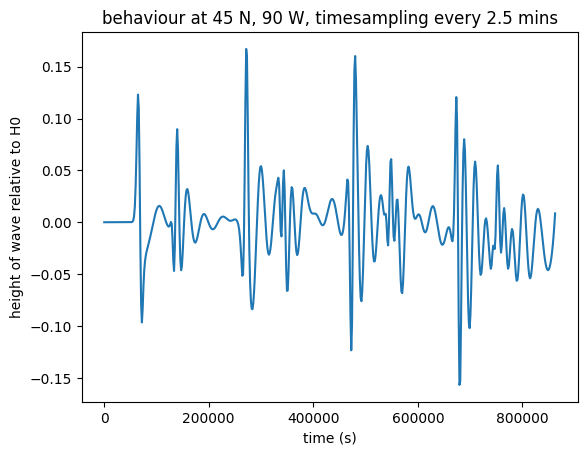

In [7]:
timestep=150 * second

phi, theta = dist.local_grids(basis) # Longitude and colatitude
lat = 360*(np.pi / 2 - theta)/(2*np.pi)  # latitude in degrees

# Fields
u = dist.VectorField(coords, name='u', bases=basis)
h = dist.Field(name='h', bases=basis)

# Operators
# First, create an operator to perform the cross product: "z x ", where z is the local vertical unit vector
# The "skew" operator performs a 90 degree rotation of a vector field,
# so that skew([u,v]) = [-v, u].  MulCosine multiplies by the cosine of the latitude
zcross = lambda A: dedalus.MulCosine(dedalus.skew(A))

# Set the initial conditions
h.change_scales(1) # Set values on regular grid
u.change_scales(1)
h['g'] = np.exp(-((phi-phi0)**2+(theta-theta0)**2)/width**2)  # Initialize the dependent variable c with a Gaussian function (note ** is the exponentiation operator)
# Set the initial velocity to zero
u['g'][0] = 0 # the x-component of the velocity
u['g'][1] = 0 # the y-component of the velocity

# Problem
problem = dedalus.IVP([u, h], namespace=locals())
problem.add_equation("dt(u) + g*grad(h) + 2*Omega*zcross(u) = - u@grad(u)")
problem.add_equation("dt(h) + H*div(u) = - div(h*u)")

# Solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

h.change_scales(1)
h_save = [np.copy(h['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            h.change_scales(1)
            h_save.append(np.copy(h['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

h_save = np.array(h_save)

plt.plot(t_save, h_save[:, 96, 16])
plt.title('behaviour at 45 N, 90 W, timesampling every 2.5 mins')
plt.ylabel('height of wave relative to H0')
plt.xlabel('time (s)')
plt.show()


In the time limit, the waves propograte around the 'earth' 4 times which corresponds to the 4 wave packets we can see in the plot. As the wave initially propogates from the start point, the coriolis force, f, decreases which causes the waves to speed up according to the geostrophic balance, assuming that dp/d$\theta$ and dp/d$\phi$ are constant. This causes the wave to bunch up increasing the height h. This maximal height will then propogate backwards through the wave as it spreads out, causing the reduction in h from the plot. This then repeats every time the wave circumnavigates, however the difference in amplitude reduces as the wave interferes with itself due to reflection at the boundaries, causing the wave to approach more of a stationary wave form, seen in the more consistent peaks and troughs seen after around 700,000s.


In the simulation above, the Tsunami wave travels around the planet many times. In reality, the waves will partially dissipate when they reach shorelines. In the spherical shallow water equation code above (or in a new code block below), add a forcing term to the shallow water equations that damps the waves for longitudes larger than $\pm 90^\circ$. Specifically, add a forcing function to the right hand side of the height equation of the following form:

$$ - (1/\tau) f(\phi) h$$

where

$$ f(\phi) = \frac{1}{2}\left(1+tanh\left(\frac{\phi-3\pi/2}{\pi/10}\right)\right) + \frac{1}{2}\left(1-tanh\left(\frac{\phi-\pi/2}{\pi/10}\right)\right) $$

and $\phi$ is the longitude in radians and $\tau$ is a damping timescale. A timescale of $\tau=0.1$ days should be sufficient to damp the waves.

With this damping term active, much more slowly propagating waves should be visible. These are shallow water Rossby waves. Estimate the east/west phase speed of these Rossby waves from the theoretical dispersion relation and compare this estimate with the phase speed that you can infer from the simulation by plotting the height, $h$, as a function of longitude and time. Discuss the spatial structure of the Rossby waves and any discrepancies that you see between your estimated and measured phase speeds.

In [8]:
# ADD CODE HERE TO SOLVE THE SHALLOW WATER EQUATIONS WITH DAMPING.
# YOU CAN START BY COPYING THE CODE ABOVE AND PASTING IT HERE

# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Define the simulation units. This is optional, but will help us keep track of units
meter = 1
kilometer = meter * 1e3
second = 1
minute = 60
hour = 3600
day = hour * 24

# Parameters
Nphi = 128 # Number of gridpoints in phi (longitude)
Ntheta = 64 # Number of gridpoints in theta (colatitude)
R = 6.37122e3 * kilometer
Omega = 2 * np.pi / (1 * day) # Earth's angular velocity in radians per second
g = 9.80616 * meter / second**2 # Gravitational acceleration
H = 4 * kilometer # Depth of the ocean
width = 2*np.pi*10/360 # Width of the initial Gaussian in radians
phi0 = np.pi # Longitude of the initial Gaussian height perturbation in radians
theta0 = np.pi/4 # Colatitude of the initial Gaussian height perturbation in radians

timestep = 600 * second
stop_sim_time = 10 * day

# Bases
coords = dedalus.S2Coordinates('phi', 'theta')
dist = dedalus.Distributor(coords, dtype=np.float64)
basis = dedalus.SphereBasis(coords, (Nphi, Ntheta), radius=R, dealias=3/2, dtype=np.float64)

# Define the coordinates
phi, theta = dist.local_grids(basis) # Longitude and colatitude
lat = 360*(np.pi / 2 - theta)/(2*np.pi)  # latitude in degrees

# Fields
u = dist.VectorField(coords, name='u', bases=basis)
h = dist.Field(name='h', bases=basis)

# Operators
# First, create an operator to perform the cross product: "z x ", where z is the local vertical unit vector
# The "skew" operator performs a 90 degree rotation of a vector field,
# so that skew([u,v]) = [-v, u].  MulCosine multiplies by the cosine of the latitude
zcross = lambda A: dedalus.MulCosine(dedalus.skew(A))

# Set the initial conditions
h.change_scales(1) # Set values on regular grid
u.change_scales(1)

#DAMPING TERM
tau= 0.1* day
damping_factor = dist.Field(name='damping_factor', bases = basis)
damping_factor.change_scales(1)
damping_factor['g']= 0.5*(1+np.tanh((phi-1.5*np.pi)/0.1*np.pi))+0.5*(1-np.tanh((phi-0.5*np.pi)/0.1*np.pi))

h['g'] = np.exp(-((phi-phi0)**2+(theta-theta0)**2)/width**2)  # Initialize the dependent variable c with a Gaussian function (note ** is the exponentiation operator)
# Set the initial velocity to zero
u['g'][0] = 0 # the x-component of the velocity
u['g'][1] = 0 # the y-component of the velocity

# Problem
problem = dedalus.IVP([u, h], namespace=locals())
problem.add_equation("dt(u) + g*grad(h) + 2*Omega*zcross(u) = - u@grad(u)")
problem.add_equation("dt(h) + H*div(u) = - div(h*u) -(1/tau) *damping_factor *h") #NEW DAMPING TERM

# Solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

h.change_scales(1)
h_save = [np.copy(h['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            h.change_scales(1)
            h_save.append(np.copy(h['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

h_save = np.array(h_save)

INFO:subsystems:Building subproblem matrices 1/63 (~2%) Elapsed: 0s, Remaining: 1s, Rate: 6.9e+01/s


2025-11-26 19:09:52,253 subsystems 0/1 INFO :: Building subproblem matrices 1/63 (~2%) Elapsed: 0s, Remaining: 1s, Rate: 6.9e+01/s


INFO:subsystems:Building subproblem matrices 7/63 (~11%) Elapsed: 0s, Remaining: 1s, Rate: 9.4e+01/s


2025-11-26 19:09:52,313 subsystems 0/1 INFO :: Building subproblem matrices 7/63 (~11%) Elapsed: 0s, Remaining: 1s, Rate: 9.4e+01/s


INFO:subsystems:Building subproblem matrices 14/63 (~22%) Elapsed: 0s, Remaining: 1s, Rate: 9.7e+01/s


2025-11-26 19:09:52,383 subsystems 0/1 INFO :: Building subproblem matrices 14/63 (~22%) Elapsed: 0s, Remaining: 1s, Rate: 9.7e+01/s


INFO:subsystems:Building subproblem matrices 21/63 (~33%) Elapsed: 0s, Remaining: 0s, Rate: 9.9e+01/s


2025-11-26 19:09:52,451 subsystems 0/1 INFO :: Building subproblem matrices 21/63 (~33%) Elapsed: 0s, Remaining: 0s, Rate: 9.9e+01/s


INFO:subsystems:Building subproblem matrices 28/63 (~44%) Elapsed: 0s, Remaining: 0s, Rate: 1.0e+02/s


2025-11-26 19:09:52,517 subsystems 0/1 INFO :: Building subproblem matrices 28/63 (~44%) Elapsed: 0s, Remaining: 0s, Rate: 1.0e+02/s


INFO:subsystems:Building subproblem matrices 35/63 (~56%) Elapsed: 0s, Remaining: 0s, Rate: 1.0e+02/s


2025-11-26 19:09:52,584 subsystems 0/1 INFO :: Building subproblem matrices 35/63 (~56%) Elapsed: 0s, Remaining: 0s, Rate: 1.0e+02/s


INFO:subsystems:Building subproblem matrices 42/63 (~67%) Elapsed: 0s, Remaining: 0s, Rate: 1.0e+02/s


2025-11-26 19:09:52,652 subsystems 0/1 INFO :: Building subproblem matrices 42/63 (~67%) Elapsed: 0s, Remaining: 0s, Rate: 1.0e+02/s


INFO:subsystems:Building subproblem matrices 49/63 (~78%) Elapsed: 0s, Remaining: 0s, Rate: 1.0e+02/s


2025-11-26 19:09:52,724 subsystems 0/1 INFO :: Building subproblem matrices 49/63 (~78%) Elapsed: 0s, Remaining: 0s, Rate: 1.0e+02/s


INFO:subsystems:Building subproblem matrices 56/63 (~89%) Elapsed: 1s, Remaining: 0s, Rate: 1.0e+02/s


2025-11-26 19:09:52,798 subsystems 0/1 INFO :: Building subproblem matrices 56/63 (~89%) Elapsed: 1s, Remaining: 0s, Rate: 1.0e+02/s


INFO:subsystems:Building subproblem matrices 63/63 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.0e+02/s


2025-11-26 19:09:52,869 subsystems 0/1 INFO :: Building subproblem matrices 63/63 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.0e+02/s


INFO:__main__:Starting main loop


2025-11-26 19:09:52,875 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=6.000000e+02, dt=6.000000e+02


2025-11-26 19:09:55,277 __main__ 0/1 INFO :: Iteration=1, Time=6.000000e+02, dt=6.000000e+02


INFO:__main__:Iteration=11, Time=6.600000e+03, dt=6.000000e+02


2025-11-26 19:09:55,820 __main__ 0/1 INFO :: Iteration=11, Time=6.600000e+03, dt=6.000000e+02


INFO:__main__:Iteration=21, Time=1.260000e+04, dt=6.000000e+02


2025-11-26 19:09:56,201 __main__ 0/1 INFO :: Iteration=21, Time=1.260000e+04, dt=6.000000e+02


INFO:__main__:Iteration=31, Time=1.860000e+04, dt=6.000000e+02


2025-11-26 19:09:56,555 __main__ 0/1 INFO :: Iteration=31, Time=1.860000e+04, dt=6.000000e+02


INFO:__main__:Iteration=41, Time=2.460000e+04, dt=6.000000e+02


2025-11-26 19:09:56,911 __main__ 0/1 INFO :: Iteration=41, Time=2.460000e+04, dt=6.000000e+02


INFO:__main__:Iteration=51, Time=3.060000e+04, dt=6.000000e+02


2025-11-26 19:09:57,281 __main__ 0/1 INFO :: Iteration=51, Time=3.060000e+04, dt=6.000000e+02


INFO:__main__:Iteration=61, Time=3.660000e+04, dt=6.000000e+02


2025-11-26 19:09:57,651 __main__ 0/1 INFO :: Iteration=61, Time=3.660000e+04, dt=6.000000e+02


INFO:__main__:Iteration=71, Time=4.260000e+04, dt=6.000000e+02


2025-11-26 19:09:58,004 __main__ 0/1 INFO :: Iteration=71, Time=4.260000e+04, dt=6.000000e+02


INFO:__main__:Iteration=81, Time=4.860000e+04, dt=6.000000e+02


2025-11-26 19:09:58,376 __main__ 0/1 INFO :: Iteration=81, Time=4.860000e+04, dt=6.000000e+02


INFO:__main__:Iteration=91, Time=5.460000e+04, dt=6.000000e+02


2025-11-26 19:09:58,723 __main__ 0/1 INFO :: Iteration=91, Time=5.460000e+04, dt=6.000000e+02


INFO:__main__:Iteration=101, Time=6.060000e+04, dt=6.000000e+02


2025-11-26 19:09:59,154 __main__ 0/1 INFO :: Iteration=101, Time=6.060000e+04, dt=6.000000e+02


INFO:__main__:Iteration=111, Time=6.660000e+04, dt=6.000000e+02


2025-11-26 19:09:59,680 __main__ 0/1 INFO :: Iteration=111, Time=6.660000e+04, dt=6.000000e+02


INFO:__main__:Iteration=121, Time=7.260000e+04, dt=6.000000e+02


2025-11-26 19:10:00,224 __main__ 0/1 INFO :: Iteration=121, Time=7.260000e+04, dt=6.000000e+02


INFO:__main__:Iteration=131, Time=7.860000e+04, dt=6.000000e+02


2025-11-26 19:10:00,636 __main__ 0/1 INFO :: Iteration=131, Time=7.860000e+04, dt=6.000000e+02


INFO:__main__:Iteration=141, Time=8.460000e+04, dt=6.000000e+02


2025-11-26 19:10:00,958 __main__ 0/1 INFO :: Iteration=141, Time=8.460000e+04, dt=6.000000e+02


INFO:__main__:Iteration=151, Time=9.060000e+04, dt=6.000000e+02


2025-11-26 19:10:01,290 __main__ 0/1 INFO :: Iteration=151, Time=9.060000e+04, dt=6.000000e+02


INFO:__main__:Iteration=161, Time=9.660000e+04, dt=6.000000e+02


2025-11-26 19:10:01,647 __main__ 0/1 INFO :: Iteration=161, Time=9.660000e+04, dt=6.000000e+02


INFO:__main__:Iteration=171, Time=1.026000e+05, dt=6.000000e+02


2025-11-26 19:10:02,006 __main__ 0/1 INFO :: Iteration=171, Time=1.026000e+05, dt=6.000000e+02


INFO:__main__:Iteration=181, Time=1.086000e+05, dt=6.000000e+02


2025-11-26 19:10:02,380 __main__ 0/1 INFO :: Iteration=181, Time=1.086000e+05, dt=6.000000e+02


INFO:__main__:Iteration=191, Time=1.146000e+05, dt=6.000000e+02


2025-11-26 19:10:02,719 __main__ 0/1 INFO :: Iteration=191, Time=1.146000e+05, dt=6.000000e+02


INFO:__main__:Iteration=201, Time=1.206000e+05, dt=6.000000e+02


2025-11-26 19:10:03,072 __main__ 0/1 INFO :: Iteration=201, Time=1.206000e+05, dt=6.000000e+02


INFO:__main__:Iteration=211, Time=1.266000e+05, dt=6.000000e+02


2025-11-26 19:10:03,455 __main__ 0/1 INFO :: Iteration=211, Time=1.266000e+05, dt=6.000000e+02


INFO:__main__:Iteration=221, Time=1.326000e+05, dt=6.000000e+02


2025-11-26 19:10:03,870 __main__ 0/1 INFO :: Iteration=221, Time=1.326000e+05, dt=6.000000e+02


INFO:__main__:Iteration=231, Time=1.386000e+05, dt=6.000000e+02


2025-11-26 19:10:04,279 __main__ 0/1 INFO :: Iteration=231, Time=1.386000e+05, dt=6.000000e+02


INFO:__main__:Iteration=241, Time=1.446000e+05, dt=6.000000e+02


2025-11-26 19:10:04,669 __main__ 0/1 INFO :: Iteration=241, Time=1.446000e+05, dt=6.000000e+02


INFO:__main__:Iteration=251, Time=1.506000e+05, dt=6.000000e+02


2025-11-26 19:10:05,028 __main__ 0/1 INFO :: Iteration=251, Time=1.506000e+05, dt=6.000000e+02


INFO:__main__:Iteration=261, Time=1.566000e+05, dt=6.000000e+02


2025-11-26 19:10:05,404 __main__ 0/1 INFO :: Iteration=261, Time=1.566000e+05, dt=6.000000e+02


INFO:__main__:Iteration=271, Time=1.626000e+05, dt=6.000000e+02


2025-11-26 19:10:05,768 __main__ 0/1 INFO :: Iteration=271, Time=1.626000e+05, dt=6.000000e+02


INFO:__main__:Iteration=281, Time=1.686000e+05, dt=6.000000e+02


2025-11-26 19:10:06,129 __main__ 0/1 INFO :: Iteration=281, Time=1.686000e+05, dt=6.000000e+02


INFO:__main__:Iteration=291, Time=1.746000e+05, dt=6.000000e+02


2025-11-26 19:10:06,493 __main__ 0/1 INFO :: Iteration=291, Time=1.746000e+05, dt=6.000000e+02


INFO:__main__:Iteration=301, Time=1.806000e+05, dt=6.000000e+02


2025-11-26 19:10:06,857 __main__ 0/1 INFO :: Iteration=301, Time=1.806000e+05, dt=6.000000e+02


INFO:__main__:Iteration=311, Time=1.866000e+05, dt=6.000000e+02


2025-11-26 19:10:07,218 __main__ 0/1 INFO :: Iteration=311, Time=1.866000e+05, dt=6.000000e+02


INFO:__main__:Iteration=321, Time=1.926000e+05, dt=6.000000e+02


2025-11-26 19:10:07,600 __main__ 0/1 INFO :: Iteration=321, Time=1.926000e+05, dt=6.000000e+02


INFO:__main__:Iteration=331, Time=1.986000e+05, dt=6.000000e+02


2025-11-26 19:10:07,950 __main__ 0/1 INFO :: Iteration=331, Time=1.986000e+05, dt=6.000000e+02


INFO:__main__:Iteration=341, Time=2.046000e+05, dt=6.000000e+02


2025-11-26 19:10:08,316 __main__ 0/1 INFO :: Iteration=341, Time=2.046000e+05, dt=6.000000e+02


INFO:__main__:Iteration=351, Time=2.106000e+05, dt=6.000000e+02


2025-11-26 19:10:08,725 __main__ 0/1 INFO :: Iteration=351, Time=2.106000e+05, dt=6.000000e+02


INFO:__main__:Iteration=361, Time=2.166000e+05, dt=6.000000e+02


2025-11-26 19:10:09,149 __main__ 0/1 INFO :: Iteration=361, Time=2.166000e+05, dt=6.000000e+02


INFO:__main__:Iteration=371, Time=2.226000e+05, dt=6.000000e+02


2025-11-26 19:10:09,576 __main__ 0/1 INFO :: Iteration=371, Time=2.226000e+05, dt=6.000000e+02


INFO:__main__:Iteration=381, Time=2.286000e+05, dt=6.000000e+02


2025-11-26 19:10:09,993 __main__ 0/1 INFO :: Iteration=381, Time=2.286000e+05, dt=6.000000e+02


INFO:__main__:Iteration=391, Time=2.346000e+05, dt=6.000000e+02


2025-11-26 19:10:10,410 __main__ 0/1 INFO :: Iteration=391, Time=2.346000e+05, dt=6.000000e+02


INFO:__main__:Iteration=401, Time=2.406000e+05, dt=6.000000e+02


2025-11-26 19:10:10,990 __main__ 0/1 INFO :: Iteration=401, Time=2.406000e+05, dt=6.000000e+02


INFO:__main__:Iteration=411, Time=2.466000e+05, dt=6.000000e+02


2025-11-26 19:10:11,526 __main__ 0/1 INFO :: Iteration=411, Time=2.466000e+05, dt=6.000000e+02


INFO:__main__:Iteration=421, Time=2.526000e+05, dt=6.000000e+02


2025-11-26 19:10:12,002 __main__ 0/1 INFO :: Iteration=421, Time=2.526000e+05, dt=6.000000e+02


INFO:__main__:Iteration=431, Time=2.586000e+05, dt=6.000000e+02


2025-11-26 19:10:12,361 __main__ 0/1 INFO :: Iteration=431, Time=2.586000e+05, dt=6.000000e+02


INFO:__main__:Iteration=441, Time=2.646000e+05, dt=6.000000e+02


2025-11-26 19:10:12,730 __main__ 0/1 INFO :: Iteration=441, Time=2.646000e+05, dt=6.000000e+02


INFO:__main__:Iteration=451, Time=2.706000e+05, dt=6.000000e+02


2025-11-26 19:10:13,416 __main__ 0/1 INFO :: Iteration=451, Time=2.706000e+05, dt=6.000000e+02


INFO:__main__:Iteration=461, Time=2.766000e+05, dt=6.000000e+02


2025-11-26 19:10:14,456 __main__ 0/1 INFO :: Iteration=461, Time=2.766000e+05, dt=6.000000e+02


INFO:__main__:Iteration=471, Time=2.826000e+05, dt=6.000000e+02


2025-11-26 19:10:15,256 __main__ 0/1 INFO :: Iteration=471, Time=2.826000e+05, dt=6.000000e+02


INFO:__main__:Iteration=481, Time=2.886000e+05, dt=6.000000e+02


2025-11-26 19:10:16,150 __main__ 0/1 INFO :: Iteration=481, Time=2.886000e+05, dt=6.000000e+02


INFO:__main__:Iteration=491, Time=2.946000e+05, dt=6.000000e+02


2025-11-26 19:10:16,948 __main__ 0/1 INFO :: Iteration=491, Time=2.946000e+05, dt=6.000000e+02


INFO:__main__:Iteration=501, Time=3.006000e+05, dt=6.000000e+02


2025-11-26 19:10:17,762 __main__ 0/1 INFO :: Iteration=501, Time=3.006000e+05, dt=6.000000e+02


INFO:__main__:Iteration=511, Time=3.066000e+05, dt=6.000000e+02


2025-11-26 19:10:18,630 __main__ 0/1 INFO :: Iteration=511, Time=3.066000e+05, dt=6.000000e+02


INFO:__main__:Iteration=521, Time=3.126000e+05, dt=6.000000e+02


2025-11-26 19:10:19,304 __main__ 0/1 INFO :: Iteration=521, Time=3.126000e+05, dt=6.000000e+02


INFO:__main__:Iteration=531, Time=3.186000e+05, dt=6.000000e+02


2025-11-26 19:10:20,037 __main__ 0/1 INFO :: Iteration=531, Time=3.186000e+05, dt=6.000000e+02


INFO:__main__:Iteration=541, Time=3.246000e+05, dt=6.000000e+02


2025-11-26 19:10:20,637 __main__ 0/1 INFO :: Iteration=541, Time=3.246000e+05, dt=6.000000e+02


INFO:__main__:Iteration=551, Time=3.306000e+05, dt=6.000000e+02


2025-11-26 19:10:20,990 __main__ 0/1 INFO :: Iteration=551, Time=3.306000e+05, dt=6.000000e+02


INFO:__main__:Iteration=561, Time=3.366000e+05, dt=6.000000e+02


2025-11-26 19:10:21,368 __main__ 0/1 INFO :: Iteration=561, Time=3.366000e+05, dt=6.000000e+02


INFO:__main__:Iteration=571, Time=3.426000e+05, dt=6.000000e+02


2025-11-26 19:10:21,717 __main__ 0/1 INFO :: Iteration=571, Time=3.426000e+05, dt=6.000000e+02


INFO:__main__:Iteration=581, Time=3.486000e+05, dt=6.000000e+02


2025-11-26 19:10:22,361 __main__ 0/1 INFO :: Iteration=581, Time=3.486000e+05, dt=6.000000e+02


INFO:__main__:Iteration=591, Time=3.546000e+05, dt=6.000000e+02


2025-11-26 19:10:22,940 __main__ 0/1 INFO :: Iteration=591, Time=3.546000e+05, dt=6.000000e+02


INFO:__main__:Iteration=601, Time=3.606000e+05, dt=6.000000e+02


2025-11-26 19:10:23,432 __main__ 0/1 INFO :: Iteration=601, Time=3.606000e+05, dt=6.000000e+02


INFO:__main__:Iteration=611, Time=3.666000e+05, dt=6.000000e+02


2025-11-26 19:10:23,795 __main__ 0/1 INFO :: Iteration=611, Time=3.666000e+05, dt=6.000000e+02


INFO:__main__:Iteration=621, Time=3.726000e+05, dt=6.000000e+02


2025-11-26 19:10:24,156 __main__ 0/1 INFO :: Iteration=621, Time=3.726000e+05, dt=6.000000e+02


INFO:__main__:Iteration=631, Time=3.786000e+05, dt=6.000000e+02


2025-11-26 19:10:24,524 __main__ 0/1 INFO :: Iteration=631, Time=3.786000e+05, dt=6.000000e+02


INFO:__main__:Iteration=641, Time=3.846000e+05, dt=6.000000e+02


2025-11-26 19:10:24,885 __main__ 0/1 INFO :: Iteration=641, Time=3.846000e+05, dt=6.000000e+02


INFO:__main__:Iteration=651, Time=3.906000e+05, dt=6.000000e+02


2025-11-26 19:10:25,331 __main__ 0/1 INFO :: Iteration=651, Time=3.906000e+05, dt=6.000000e+02


INFO:__main__:Iteration=661, Time=3.966000e+05, dt=6.000000e+02


2025-11-26 19:10:25,749 __main__ 0/1 INFO :: Iteration=661, Time=3.966000e+05, dt=6.000000e+02


INFO:__main__:Iteration=671, Time=4.026000e+05, dt=6.000000e+02


2025-11-26 19:10:26,136 __main__ 0/1 INFO :: Iteration=671, Time=4.026000e+05, dt=6.000000e+02


INFO:__main__:Iteration=681, Time=4.086000e+05, dt=6.000000e+02


2025-11-26 19:10:26,490 __main__ 0/1 INFO :: Iteration=681, Time=4.086000e+05, dt=6.000000e+02


INFO:__main__:Iteration=691, Time=4.146000e+05, dt=6.000000e+02


2025-11-26 19:10:26,848 __main__ 0/1 INFO :: Iteration=691, Time=4.146000e+05, dt=6.000000e+02


INFO:__main__:Iteration=701, Time=4.206000e+05, dt=6.000000e+02


2025-11-26 19:10:27,216 __main__ 0/1 INFO :: Iteration=701, Time=4.206000e+05, dt=6.000000e+02


INFO:__main__:Iteration=711, Time=4.266000e+05, dt=6.000000e+02


2025-11-26 19:10:27,577 __main__ 0/1 INFO :: Iteration=711, Time=4.266000e+05, dt=6.000000e+02


INFO:__main__:Iteration=721, Time=4.326000e+05, dt=6.000000e+02


2025-11-26 19:10:27,922 __main__ 0/1 INFO :: Iteration=721, Time=4.326000e+05, dt=6.000000e+02


INFO:__main__:Iteration=731, Time=4.386000e+05, dt=6.000000e+02


2025-11-26 19:10:28,293 __main__ 0/1 INFO :: Iteration=731, Time=4.386000e+05, dt=6.000000e+02


INFO:__main__:Iteration=741, Time=4.446000e+05, dt=6.000000e+02


2025-11-26 19:10:28,656 __main__ 0/1 INFO :: Iteration=741, Time=4.446000e+05, dt=6.000000e+02


INFO:__main__:Iteration=751, Time=4.506000e+05, dt=6.000000e+02


2025-11-26 19:10:29,009 __main__ 0/1 INFO :: Iteration=751, Time=4.506000e+05, dt=6.000000e+02


INFO:__main__:Iteration=761, Time=4.566000e+05, dt=6.000000e+02


2025-11-26 19:10:29,451 __main__ 0/1 INFO :: Iteration=761, Time=4.566000e+05, dt=6.000000e+02


INFO:__main__:Iteration=771, Time=4.626000e+05, dt=6.000000e+02


2025-11-26 19:10:29,873 __main__ 0/1 INFO :: Iteration=771, Time=4.626000e+05, dt=6.000000e+02


INFO:__main__:Iteration=781, Time=4.686000e+05, dt=6.000000e+02


2025-11-26 19:10:30,278 __main__ 0/1 INFO :: Iteration=781, Time=4.686000e+05, dt=6.000000e+02


INFO:__main__:Iteration=791, Time=4.746000e+05, dt=6.000000e+02


2025-11-26 19:10:30,717 __main__ 0/1 INFO :: Iteration=791, Time=4.746000e+05, dt=6.000000e+02


INFO:__main__:Iteration=801, Time=4.806000e+05, dt=6.000000e+02


2025-11-26 19:10:31,135 __main__ 0/1 INFO :: Iteration=801, Time=4.806000e+05, dt=6.000000e+02


INFO:__main__:Iteration=811, Time=4.866000e+05, dt=6.000000e+02


2025-11-26 19:10:31,507 __main__ 0/1 INFO :: Iteration=811, Time=4.866000e+05, dt=6.000000e+02


INFO:__main__:Iteration=821, Time=4.926000e+05, dt=6.000000e+02


2025-11-26 19:10:31,854 __main__ 0/1 INFO :: Iteration=821, Time=4.926000e+05, dt=6.000000e+02


INFO:__main__:Iteration=831, Time=4.986000e+05, dt=6.000000e+02


2025-11-26 19:10:32,230 __main__ 0/1 INFO :: Iteration=831, Time=4.986000e+05, dt=6.000000e+02


INFO:__main__:Iteration=841, Time=5.046000e+05, dt=6.000000e+02


2025-11-26 19:10:32,638 __main__ 0/1 INFO :: Iteration=841, Time=5.046000e+05, dt=6.000000e+02


INFO:__main__:Iteration=851, Time=5.106000e+05, dt=6.000000e+02


2025-11-26 19:10:33,040 __main__ 0/1 INFO :: Iteration=851, Time=5.106000e+05, dt=6.000000e+02


INFO:__main__:Iteration=861, Time=5.166000e+05, dt=6.000000e+02


2025-11-26 19:10:33,579 __main__ 0/1 INFO :: Iteration=861, Time=5.166000e+05, dt=6.000000e+02


INFO:__main__:Iteration=871, Time=5.226000e+05, dt=6.000000e+02


2025-11-26 19:10:34,090 __main__ 0/1 INFO :: Iteration=871, Time=5.226000e+05, dt=6.000000e+02


INFO:__main__:Iteration=881, Time=5.286000e+05, dt=6.000000e+02


2025-11-26 19:10:34,667 __main__ 0/1 INFO :: Iteration=881, Time=5.286000e+05, dt=6.000000e+02


INFO:__main__:Iteration=891, Time=5.346000e+05, dt=6.000000e+02


2025-11-26 19:10:35,010 __main__ 0/1 INFO :: Iteration=891, Time=5.346000e+05, dt=6.000000e+02


INFO:__main__:Iteration=901, Time=5.406000e+05, dt=6.000000e+02


2025-11-26 19:10:35,391 __main__ 0/1 INFO :: Iteration=901, Time=5.406000e+05, dt=6.000000e+02


INFO:__main__:Iteration=911, Time=5.466000e+05, dt=6.000000e+02


2025-11-26 19:10:35,757 __main__ 0/1 INFO :: Iteration=911, Time=5.466000e+05, dt=6.000000e+02


INFO:__main__:Iteration=921, Time=5.526000e+05, dt=6.000000e+02


2025-11-26 19:10:36,112 __main__ 0/1 INFO :: Iteration=921, Time=5.526000e+05, dt=6.000000e+02


INFO:__main__:Iteration=931, Time=5.586000e+05, dt=6.000000e+02


2025-11-26 19:10:36,550 __main__ 0/1 INFO :: Iteration=931, Time=5.586000e+05, dt=6.000000e+02


INFO:__main__:Iteration=941, Time=5.646000e+05, dt=6.000000e+02


2025-11-26 19:10:36,972 __main__ 0/1 INFO :: Iteration=941, Time=5.646000e+05, dt=6.000000e+02


INFO:__main__:Iteration=951, Time=5.706000e+05, dt=6.000000e+02


2025-11-26 19:10:37,370 __main__ 0/1 INFO :: Iteration=951, Time=5.706000e+05, dt=6.000000e+02


INFO:__main__:Iteration=961, Time=5.766000e+05, dt=6.000000e+02


2025-11-26 19:10:37,739 __main__ 0/1 INFO :: Iteration=961, Time=5.766000e+05, dt=6.000000e+02


INFO:__main__:Iteration=971, Time=5.826000e+05, dt=6.000000e+02


2025-11-26 19:10:38,099 __main__ 0/1 INFO :: Iteration=971, Time=5.826000e+05, dt=6.000000e+02


INFO:__main__:Iteration=981, Time=5.886000e+05, dt=6.000000e+02


2025-11-26 19:10:38,462 __main__ 0/1 INFO :: Iteration=981, Time=5.886000e+05, dt=6.000000e+02


INFO:__main__:Iteration=991, Time=5.946000e+05, dt=6.000000e+02


2025-11-26 19:10:38,819 __main__ 0/1 INFO :: Iteration=991, Time=5.946000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1001, Time=6.006000e+05, dt=6.000000e+02


2025-11-26 19:10:39,169 __main__ 0/1 INFO :: Iteration=1001, Time=6.006000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1011, Time=6.066000e+05, dt=6.000000e+02


2025-11-26 19:10:39,530 __main__ 0/1 INFO :: Iteration=1011, Time=6.066000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1021, Time=6.126000e+05, dt=6.000000e+02


2025-11-26 19:10:39,908 __main__ 0/1 INFO :: Iteration=1021, Time=6.126000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1031, Time=6.186000e+05, dt=6.000000e+02


2025-11-26 19:10:40,276 __main__ 0/1 INFO :: Iteration=1031, Time=6.186000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1041, Time=6.246000e+05, dt=6.000000e+02


2025-11-26 19:10:40,640 __main__ 0/1 INFO :: Iteration=1041, Time=6.246000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1051, Time=6.306000e+05, dt=6.000000e+02


2025-11-26 19:10:41,004 __main__ 0/1 INFO :: Iteration=1051, Time=6.306000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1061, Time=6.366000e+05, dt=6.000000e+02


2025-11-26 19:10:41,372 __main__ 0/1 INFO :: Iteration=1061, Time=6.366000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1071, Time=6.426000e+05, dt=6.000000e+02


2025-11-26 19:10:41,737 __main__ 0/1 INFO :: Iteration=1071, Time=6.426000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1081, Time=6.486000e+05, dt=6.000000e+02


2025-11-26 19:10:42,090 __main__ 0/1 INFO :: Iteration=1081, Time=6.486000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1091, Time=6.546000e+05, dt=6.000000e+02


2025-11-26 19:10:42,478 __main__ 0/1 INFO :: Iteration=1091, Time=6.546000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1101, Time=6.606000e+05, dt=6.000000e+02


2025-11-26 19:10:42,902 __main__ 0/1 INFO :: Iteration=1101, Time=6.606000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1111, Time=6.666000e+05, dt=6.000000e+02


2025-11-26 19:10:43,310 __main__ 0/1 INFO :: Iteration=1111, Time=6.666000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1121, Time=6.726000e+05, dt=6.000000e+02


2025-11-26 19:10:43,666 __main__ 0/1 INFO :: Iteration=1121, Time=6.726000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1131, Time=6.786000e+05, dt=6.000000e+02


2025-11-26 19:10:44,024 __main__ 0/1 INFO :: Iteration=1131, Time=6.786000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1141, Time=6.846000e+05, dt=6.000000e+02


2025-11-26 19:10:44,400 __main__ 0/1 INFO :: Iteration=1141, Time=6.846000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1151, Time=6.906000e+05, dt=6.000000e+02


2025-11-26 19:10:44,938 __main__ 0/1 INFO :: Iteration=1151, Time=6.906000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1161, Time=6.966000e+05, dt=6.000000e+02


2025-11-26 19:10:45,523 __main__ 0/1 INFO :: Iteration=1161, Time=6.966000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1171, Time=7.026000e+05, dt=6.000000e+02


2025-11-26 19:10:46,087 __main__ 0/1 INFO :: Iteration=1171, Time=7.026000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1181, Time=7.086000e+05, dt=6.000000e+02


2025-11-26 19:10:46,468 __main__ 0/1 INFO :: Iteration=1181, Time=7.086000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1191, Time=7.146000e+05, dt=6.000000e+02


2025-11-26 19:10:46,895 __main__ 0/1 INFO :: Iteration=1191, Time=7.146000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1201, Time=7.206000e+05, dt=6.000000e+02


2025-11-26 19:10:47,310 __main__ 0/1 INFO :: Iteration=1201, Time=7.206000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1211, Time=7.266000e+05, dt=6.000000e+02


2025-11-26 19:10:47,688 __main__ 0/1 INFO :: Iteration=1211, Time=7.266000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1221, Time=7.326000e+05, dt=6.000000e+02


2025-11-26 19:10:48,052 __main__ 0/1 INFO :: Iteration=1221, Time=7.326000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1231, Time=7.386000e+05, dt=6.000000e+02


2025-11-26 19:10:48,426 __main__ 0/1 INFO :: Iteration=1231, Time=7.386000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1241, Time=7.446000e+05, dt=6.000000e+02


2025-11-26 19:10:48,842 __main__ 0/1 INFO :: Iteration=1241, Time=7.446000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1251, Time=7.506000e+05, dt=6.000000e+02


2025-11-26 19:10:49,258 __main__ 0/1 INFO :: Iteration=1251, Time=7.506000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1261, Time=7.566000e+05, dt=6.000000e+02


2025-11-26 19:10:49,675 __main__ 0/1 INFO :: Iteration=1261, Time=7.566000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1271, Time=7.626000e+05, dt=6.000000e+02


2025-11-26 19:10:50,113 __main__ 0/1 INFO :: Iteration=1271, Time=7.626000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1281, Time=7.686000e+05, dt=6.000000e+02


2025-11-26 19:10:50,557 __main__ 0/1 INFO :: Iteration=1281, Time=7.686000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1291, Time=7.746000e+05, dt=6.000000e+02


2025-11-26 19:10:51,096 __main__ 0/1 INFO :: Iteration=1291, Time=7.746000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1301, Time=7.806000e+05, dt=6.000000e+02


2025-11-26 19:10:51,654 __main__ 0/1 INFO :: Iteration=1301, Time=7.806000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1311, Time=7.866000e+05, dt=6.000000e+02


2025-11-26 19:10:51,995 __main__ 0/1 INFO :: Iteration=1311, Time=7.866000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1321, Time=7.926000e+05, dt=6.000000e+02


2025-11-26 19:10:52,387 __main__ 0/1 INFO :: Iteration=1321, Time=7.926000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1331, Time=7.986000e+05, dt=6.000000e+02


2025-11-26 19:10:52,790 __main__ 0/1 INFO :: Iteration=1331, Time=7.986000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1341, Time=8.046000e+05, dt=6.000000e+02


2025-11-26 19:10:53,221 __main__ 0/1 INFO :: Iteration=1341, Time=8.046000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1351, Time=8.106000e+05, dt=6.000000e+02


2025-11-26 19:10:53,642 __main__ 0/1 INFO :: Iteration=1351, Time=8.106000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1361, Time=8.166000e+05, dt=6.000000e+02


2025-11-26 19:10:53,994 __main__ 0/1 INFO :: Iteration=1361, Time=8.166000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1371, Time=8.226000e+05, dt=6.000000e+02


2025-11-26 19:10:54,376 __main__ 0/1 INFO :: Iteration=1371, Time=8.226000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1381, Time=8.286000e+05, dt=6.000000e+02


2025-11-26 19:10:54,751 __main__ 0/1 INFO :: Iteration=1381, Time=8.286000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1391, Time=8.346000e+05, dt=6.000000e+02


2025-11-26 19:10:55,129 __main__ 0/1 INFO :: Iteration=1391, Time=8.346000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1401, Time=8.406000e+05, dt=6.000000e+02


2025-11-26 19:10:55,480 __main__ 0/1 INFO :: Iteration=1401, Time=8.406000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1411, Time=8.466000e+05, dt=6.000000e+02


2025-11-26 19:10:55,895 __main__ 0/1 INFO :: Iteration=1411, Time=8.466000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1421, Time=8.526000e+05, dt=6.000000e+02


2025-11-26 19:10:56,535 __main__ 0/1 INFO :: Iteration=1421, Time=8.526000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1431, Time=8.586000e+05, dt=6.000000e+02


2025-11-26 19:10:57,073 __main__ 0/1 INFO :: Iteration=1431, Time=8.586000e+05, dt=6.000000e+02


INFO:solvers:Simulation stop time reached.


2025-11-26 19:10:57,589 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 1440


2025-11-26 19:10:57,590 solvers 0/1 INFO :: Final iteration: 1440


INFO:solvers:Final sim time: 864000.0


2025-11-26 19:10:57,591 solvers 0/1 INFO :: Final sim time: 864000.0


INFO:solvers:Setup time (init - iter 0): 0.6667 sec


2025-11-26 19:10:57,592 solvers 0/1 INFO :: Setup time (init - iter 0): 0.6667 sec


INFO:solvers:Warmup time (iter 0-10): 2.91 sec


2025-11-26 19:10:57,594 solvers 0/1 INFO :: Warmup time (iter 0-10): 2.91 sec


INFO:solvers:Run time (iter 10-end): 61.8 sec


2025-11-26 19:10:57,596 solvers 0/1 INFO :: Run time (iter 10-end): 61.8 sec


INFO:solvers:CPU time (iter 10-end): 0.01717 cpu-hr


2025-11-26 19:10:57,597 solvers 0/1 INFO :: CPU time (iter 10-end): 0.01717 cpu-hr


INFO:solvers:Speed: 5.595e+05 mode-stages/cpu-sec


2025-11-26 19:10:57,598 solvers 0/1 INFO :: Speed: 5.595e+05 mode-stages/cpu-sec


INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2025-11-26 19:10:57,865 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1200x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpq2xl2pw_/temp.m4v


2025-11-26 19:10:57,866 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1200x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpq2xl2pw_/temp.m4v


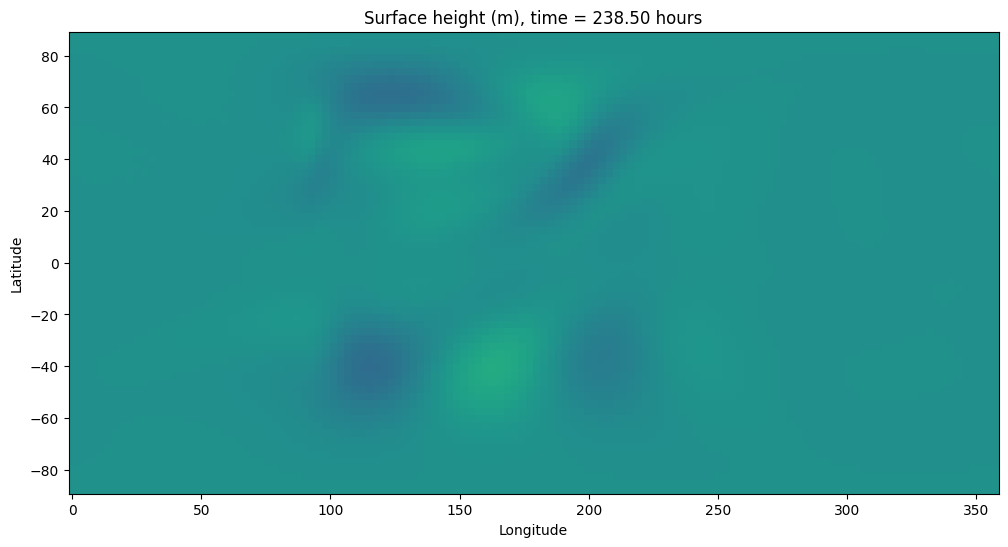

In [9]:
# create a figure and axes
fig = plt.figure(figsize=(12,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(np.pi/2 - theta)*360/2/np.pi, np.squeeze(phi)*360/2/np.pi)

# Define an animation function
def drawframe(n):
    plt.clf()
    height = plt.pcolor(Y, X, h_save[n,:,:], vmin=-0.1, vmax=0.1)
    # Specify the axis limits and labels
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Surface height (m), time = {0:.2f} hours'.format(t_save[n]/(1*hour)))
    return (height,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

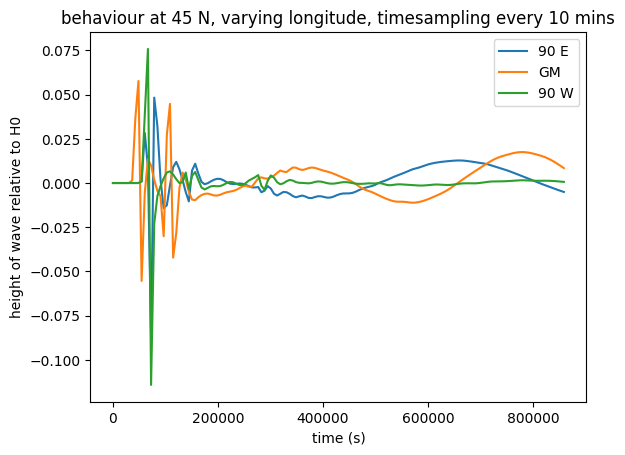

In [13]:
h_save = np.array(h_save)

plt.plot(t_save, h_save[:, 32, 16], label='90 E')
plt.plot(t_save, h_save[:, 64, 16], label= 'GM')
plt.plot(t_save, h_save[:, 96, 16], label= '90 W')
plt.legend()
plt.title('behaviour at 45 N, varying longitude, timesampling every 10 mins')
plt.ylabel('height of wave relative to H0')
plt.xlabel('time (s)')
plt.show()

From video, wave remnants seem to drift leftwards, producing the oscilation in 90 E that we dont see in 90 W. As seen in lectures, analysis tells us that shallow water rosby waves propogate westwards in both hemispheres, hence the lack of oscilation in 90E. We can also see the formation of stationary waves. As the waves reflect and interfere, they reach stationary wave solutions that propogate at set wavespeeds which seem comparable but out of phase for gm vs 90w.

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


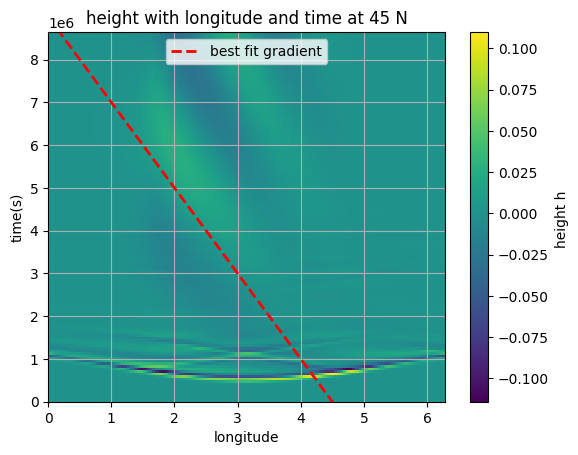

In [11]:
from dedalus.extras import plot_tools

X=np.linspace(0, 2*np.pi, 128)
T=np.linspace(0, 8640000,145)
X, T= np.meshgrid(X, T)
plt.figure()

plt.pcolor(X, T, h_save[:,:,16])

plt.title('height with longitude and time at 45 N')
plt.xlabel('longitude')
plt.ylabel('time(s)')
line_x= np.linspace(0, 2*np.pi, 128)
line_y= - line_x *2e6 +9e6

plt.plot(line_x, line_y, color='red', linewidth=2, linestyle='--', label='best fit gradient' )
plt.xlim(0,2*np.pi)
plt.ylim(0, 8640000)


plt.colorbar(label='height h ')
plt.legend()
plt.grid(True)
plt.show()

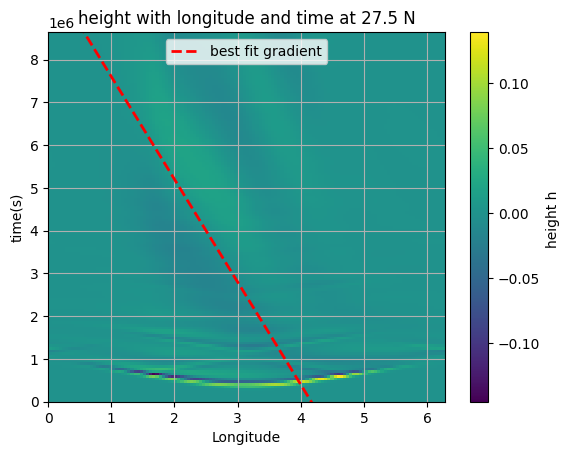

In [15]:
X=np.linspace(0, 2*np.pi, 128)
T=np.linspace(0, 8640000,145)
X, T= np.meshgrid(X, T)
plt.figure()
plt.pcolor(X, T, h_save[:,:,24])

plt.title('height with longitude and time at 27.5 N')
plt.xlabel('Longitude')
plt.ylabel('time(s)')
line_x= np.linspace(0, 2*np.pi, 128)
line_y= - line_x *2.4e6 +10e6
plt.plot(line_x, line_y, color='red', linewidth=2, linestyle='--', label='best fit gradient' )
plt.xlim(0,2*np.pi)
plt.ylim(0, 8640000)

plt.colorbar(label='height h ')
plt.legend()
plt.grid(True)
plt.show()

Theory:
As seen in lectures, the dispersion relation for shallow water Rossby waves is $$w=\frac{-\beta}{k^2+l^2+\frac{f_0^2}{gH_0}}$$
where $\beta = \frac{df}{dy} = \frac{2\Omega cos \theta}{R_e}$ and $k$=(k,l) is the wave vector.

Since c=$\frac{w}{k}$ the theory predicts that the phase speed will increase with latitude as f increases and should stay constant in time so long as the wavelength does no increase. From the plots we can see that c is roughly constant with time and varies slightly with lattitude with a time/longitude gradient of $2 \times 10^6$ for 45 N and $2.4 \times 10^6$ for 27.5 N. This supports the theory but could be further verified by sampling at more lattitudes.


## 4. Optional further investigations

* In the example of the shallow water equations on a sphere, introduce bathymetry by making $H$ a function of latitude and longitude. Make sure that you modify the equations in Dedalus appropriately. How do the waves behave when they encounter shallow water (e.g. a localized seamount)?

* It is quite difficult to simulate changing sea level (sometimes called wetting and drying), which is why the examples above do not include land. However, we can estimate the distance that a Tsunami will propagate using physical and dimensional arguments. Consider, for example, a flat, sloping beach. In the absence of energy dissipation, estimate the distance that a wave will propagate onshore. How could you modify this estimate to include energy dissipation (or drag)?